In [1]:
import sys
sys.path.insert(0,'..')

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import training as tr
import emnet
import emsim_utils

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.autograd import Variable

import cv2

from unet import UNet
import scipy.optimize as optimize
from scipy.optimize import curve_fit

# Regression net with line events

In [2]:
modeldir = '/home/jrenner/local/jerenner/emsim/models/regression_line'
lrate       = 1e-3   # Learning rate to use in the training.
load_model  = False   # Load an existing model
tr.augment  = False  # Enable/disable data augmentation
epoch_start = 0      # Number of initial epoch
epoch_end   = 300    # Number of final epoch
model_load_checkpoint = "{}/rl_L_31.pt".format(modeldir)

line_m = -2
line_b = 15

# "Real-data-like" dataset: occupancy 11, noise_mean=683, noise_sigma=11.2
dset_train = tr.EMDataset("../dataframes/EM_5um_front_3M_100keV.pkl",noise_mean=0,noise_sigma=20,add_noise=False,add_shift=-1,nstart=20000, Ltest=True)
dset_val = tr.EMDataset("../dataframes/EM_5um_front_3M_100keV.pkl",noise_mean=0,noise_sigma=20,add_noise=False,add_shift=-1,nstart=0,nend=20000, Ltest=True)

dataset_train = tr.EMFrameDataset(dset_train,frame_size=11,nelec_mean=2,nelec_sigma=0.1,noise_mean=683,noise_sigma=11.2,m_line=-2.0,b_line=15.0,res_factor=1,lside=-1)
dataset_val = tr.EMFrameDataset(dset_val,frame_size=11,nelec_mean=2,nelec_sigma=0.1,noise_mean=683,noise_sigma=11.2,m_line=-2.0,b_line=15.0,res_factor=1,lside=-1)

# Create the loaders.
train_loader = DataLoader(dataset_train, batch_size=50, shuffle=False, collate_fn=tr.my_collate_reg_line, num_workers=1)

# Define the model.
model = emnet.basicCNN_reg()
model.cuda()

optimizer = optim.Adam(model.parameters(), lr=lrate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
#optimizer = optim.RMSprop(model.parameters(), lr=lrate, weight_decay=1e-8, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=20)

# Load the model from file.
if(load_model):
    model.load_state_dict(torch.load(model_load_checkpoint))
    #model.load_state_dict(torch.load(model_load_checkpoint,map_location=torch.device('cpu')))
    model.eval()

Created dataset for events from 20000 to 178917
Created dataset for events from 0 to 20000


## Train the network (regression with line)

In [3]:
# Run the training.
for epoch in range(epoch_start,epoch_end):
    print("Epoch: ",epoch)
    model.train()
    train_loss = tr.train_regression_line(model, epoch, train_loader, optimizer, line_m, line_b, 50)
    scheduler.step(train_loss)
    #if(epoch % 50 == 0):
    torch.save(model.state_dict(), "{}/model_init_{}.pt".format(modeldir,epoch))

Epoch:  0


/home/jrenner/miniconda3/envs/tf2/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train Epoch: 0 [0/1000 (0%)]	Loss: 0.872908	 score_max: 2.350171	 score_min: -1.610669; Accuracy 0.000; LR 0.001
Train Epoch: 0 [50/1000 (5%)]	Loss: 35.729905	 score_max: 2.442272	 score_min: -11.121574; Accuracy 0.000; LR 0.001
Train Epoch: 0 [100/1000 (10%)]	Loss: 1.139363	 score_max: 4.379467	 score_min: -4.069735; Accuracy 0.000; LR 0.001
Train Epoch: 0 [150/1000 (15%)]	Loss: 7.142445	 score_max: 5.183334	 score_min: -0.774102; Accuracy 0.000; LR 0.001
Train Epoch: 0 [200/1000 (20%)]	Loss: 3.192604	 score_max: 4.370244	 score_min: -1.172616; Accuracy 0.000; LR 0.001
Train Epoch: 0 [250/1000 (25%)]	Loss: 0.730226	 score_max: 2.750265	 score_min: -1.934523; Accuracy 0.000; LR 0.001
Train Epoch: 0 [300/1000 (30%)]	Loss: 0.652531	 score_max: 1.627828	 score_min: -2.423343; Accuracy 0.000; LR 0.001
Train Epoch: 0 [350/1000 (35%)]	Loss: 0.706776	 score_max: 1.619056	 score_min: -2.833795; Accuracy 0.000; LR 0.001
Train Epoch: 0 [400/1000 (40%)]	Loss: 0.996377	 score_max: 2.174386	 score_

Train Epoch: 3 [400/1000 (40%)]	Loss: 0.587908	 score_max: 2.530978	 score_min: -1.854461; Accuracy 0.000; LR 0.001
Train Epoch: 3 [450/1000 (45%)]	Loss: 0.701941	 score_max: 2.982642	 score_min: -2.318560; Accuracy 0.000; LR 0.001
Train Epoch: 3 [500/1000 (50%)]	Loss: 0.534508	 score_max: 1.807240	 score_min: -2.597025; Accuracy 0.000; LR 0.001
Train Epoch: 3 [550/1000 (55%)]	Loss: 0.643813	 score_max: 2.089676	 score_min: -2.859016; Accuracy 0.000; LR 0.001
Train Epoch: 3 [600/1000 (60%)]	Loss: 0.582397	 score_max: 1.608991	 score_min: -2.581031; Accuracy 0.000; LR 0.001
Train Epoch: 3 [650/1000 (65%)]	Loss: 0.650013	 score_max: 1.713595	 score_min: -2.578336; Accuracy 0.020; LR 0.001
Train Epoch: 3 [700/1000 (70%)]	Loss: 0.591809	 score_max: 1.819930	 score_min: -2.331017; Accuracy 0.000; LR 0.001
Train Epoch: 3 [750/1000 (75%)]	Loss: 0.549937	 score_max: 2.282614	 score_min: -2.177049; Accuracy 0.000; LR 0.001
Train Epoch: 3 [800/1000 (80%)]	Loss: 0.505276	 score_max: 2.107606	 sco

Train Epoch: 6 [800/1000 (80%)]	Loss: 0.477608	 score_max: 1.841837	 score_min: -2.889050; Accuracy 0.000; LR 0.001
Train Epoch: 6 [850/1000 (85%)]	Loss: 0.559118	 score_max: 2.937224	 score_min: -2.983107; Accuracy 0.000; LR 0.001
Train Epoch: 6 [900/1000 (90%)]	Loss: 0.542650	 score_max: 2.737303	 score_min: -2.932412; Accuracy 0.000; LR 0.001
Train Epoch: 6 [950/1000 (95%)]	Loss: 0.532755	 score_max: 1.935230	 score_min: -2.495987; Accuracy 0.000; LR 0.001
---EPOCH AVG TRAIN LOSS: 0.5342136254471225 (VEC: 0.02447253520902825 , DIST: 0.5097410902380943 ) ACCURACY: 0.004999999888241291
Epoch:  7
Train Epoch: 7 [0/1000 (0%)]	Loss: 0.479392	 score_max: 2.969894	 score_min: -3.085270; Accuracy 0.000; LR 0.001
Train Epoch: 7 [50/1000 (5%)]	Loss: 0.490672	 score_max: 2.981731	 score_min: -2.421288; Accuracy 0.000; LR 0.001
Train Epoch: 7 [100/1000 (10%)]	Loss: 0.356845	 score_max: 2.723220	 score_min: -2.801636; Accuracy 0.020; LR 0.001
Train Epoch: 7 [150/1000 (15%)]	Loss: 0.466992	 score

Train Epoch: 10 [100/1000 (10%)]	Loss: 0.452670	 score_max: 2.235287	 score_min: -2.617215; Accuracy 0.000; LR 0.001
Train Epoch: 10 [150/1000 (15%)]	Loss: 0.518171	 score_max: 2.237756	 score_min: -2.582580; Accuracy 0.060; LR 0.001
Train Epoch: 10 [200/1000 (20%)]	Loss: 0.547280	 score_max: 2.120587	 score_min: -2.747764; Accuracy 0.000; LR 0.001
Train Epoch: 10 [250/1000 (25%)]	Loss: 0.530443	 score_max: 2.079535	 score_min: -2.781893; Accuracy 0.040; LR 0.001
Train Epoch: 10 [300/1000 (30%)]	Loss: 0.562983	 score_max: 1.563506	 score_min: -2.122331; Accuracy 0.000; LR 0.001
Train Epoch: 10 [350/1000 (35%)]	Loss: 0.553740	 score_max: 2.215219	 score_min: -2.649901; Accuracy 0.000; LR 0.001
Train Epoch: 10 [400/1000 (40%)]	Loss: 0.515953	 score_max: 2.298404	 score_min: -2.336292; Accuracy 0.000; LR 0.001
Train Epoch: 10 [450/1000 (45%)]	Loss: 0.480902	 score_max: 2.107564	 score_min: -2.991441; Accuracy 0.040; LR 0.001
Train Epoch: 10 [500/1000 (50%)]	Loss: 0.599826	 score_max: 2.51

Train Epoch: 13 [450/1000 (45%)]	Loss: 0.531616	 score_max: 2.591588	 score_min: -3.511006; Accuracy 0.000; LR 0.001
Train Epoch: 13 [500/1000 (50%)]	Loss: 0.551838	 score_max: 1.890391	 score_min: -2.830887; Accuracy 0.000; LR 0.001
Train Epoch: 13 [550/1000 (55%)]	Loss: 0.507014	 score_max: 1.921676	 score_min: -2.465275; Accuracy 0.020; LR 0.001
Train Epoch: 13 [600/1000 (60%)]	Loss: 0.495165	 score_max: 2.560094	 score_min: -2.499815; Accuracy 0.060; LR 0.001
Train Epoch: 13 [650/1000 (65%)]	Loss: 0.450340	 score_max: 2.212695	 score_min: -2.341937; Accuracy 0.000; LR 0.001
Train Epoch: 13 [700/1000 (70%)]	Loss: 0.527704	 score_max: 2.396722	 score_min: -2.349207; Accuracy 0.000; LR 0.001
Train Epoch: 13 [750/1000 (75%)]	Loss: 0.572287	 score_max: 2.378399	 score_min: -2.034743; Accuracy 0.040; LR 0.001
Train Epoch: 13 [800/1000 (80%)]	Loss: 0.481743	 score_max: 2.673952	 score_min: -2.957628; Accuracy 0.020; LR 0.001
Train Epoch: 13 [850/1000 (85%)]	Loss: 0.490414	 score_max: 2.80

Train Epoch: 16 [800/1000 (80%)]	Loss: 0.492919	 score_max: 3.026760	 score_min: -2.746393; Accuracy 0.040; LR 0.001
Train Epoch: 16 [850/1000 (85%)]	Loss: 0.565986	 score_max: 2.699999	 score_min: -3.130795; Accuracy 0.000; LR 0.001
Train Epoch: 16 [900/1000 (90%)]	Loss: 0.512163	 score_max: 2.572413	 score_min: -3.015563; Accuracy 0.000; LR 0.001
Train Epoch: 16 [950/1000 (95%)]	Loss: 0.515659	 score_max: 2.653737	 score_min: -2.928640; Accuracy 0.000; LR 0.001
---EPOCH AVG TRAIN LOSS: 0.506327464480891 (VEC: 0.01502037723828754 , DIST: 0.4913070872426033 ) ACCURACY: 0.014999999664723873
Epoch:  17
Train Epoch: 17 [0/1000 (0%)]	Loss: 0.455545	 score_max: 2.666471	 score_min: -3.137614; Accuracy 0.000; LR 0.001
Train Epoch: 17 [50/1000 (5%)]	Loss: 0.430902	 score_max: 2.486291	 score_min: -2.475168; Accuracy 0.040; LR 0.001
Train Epoch: 17 [100/1000 (10%)]	Loss: 0.513364	 score_max: 2.786517	 score_min: -2.383131; Accuracy 0.000; LR 0.001
Train Epoch: 17 [150/1000 (15%)]	Loss: 0.45959

Train Epoch: 20 [100/1000 (10%)]	Loss: 0.604332	 score_max: 2.738414	 score_min: -2.719824; Accuracy 0.040; LR 0.001
Train Epoch: 20 [150/1000 (15%)]	Loss: 0.467828	 score_max: 2.761628	 score_min: -2.343688; Accuracy 0.040; LR 0.001
Train Epoch: 20 [200/1000 (20%)]	Loss: 0.472852	 score_max: 2.832465	 score_min: -2.563844; Accuracy 0.040; LR 0.001
Train Epoch: 20 [250/1000 (25%)]	Loss: 0.568328	 score_max: 2.175440	 score_min: -2.488115; Accuracy 0.000; LR 0.001
Train Epoch: 20 [300/1000 (30%)]	Loss: 0.544529	 score_max: 2.175776	 score_min: -2.413024; Accuracy 0.000; LR 0.001
Train Epoch: 20 [350/1000 (35%)]	Loss: 0.521909	 score_max: 2.014295	 score_min: -2.510459; Accuracy 0.000; LR 0.001
Train Epoch: 20 [400/1000 (40%)]	Loss: 0.472429	 score_max: 2.430399	 score_min: -2.496523; Accuracy 0.020; LR 0.001
Train Epoch: 20 [450/1000 (45%)]	Loss: 0.600386	 score_max: 2.253725	 score_min: -2.784894; Accuracy 0.000; LR 0.001
Train Epoch: 20 [500/1000 (50%)]	Loss: 0.464828	 score_max: 2.46

Train Epoch: 23 [450/1000 (45%)]	Loss: 0.408712	 score_max: 2.573524	 score_min: -2.555020; Accuracy 0.020; LR 0.001
Train Epoch: 23 [500/1000 (50%)]	Loss: 0.548331	 score_max: 2.438404	 score_min: -2.730606; Accuracy 0.000; LR 0.001
Train Epoch: 23 [550/1000 (55%)]	Loss: 0.546092	 score_max: 2.627434	 score_min: -3.768354; Accuracy 0.020; LR 0.001
Train Epoch: 23 [600/1000 (60%)]	Loss: 0.411881	 score_max: 2.678385	 score_min: -2.759629; Accuracy 0.020; LR 0.001
Train Epoch: 23 [650/1000 (65%)]	Loss: 0.483770	 score_max: 2.418950	 score_min: -2.615973; Accuracy 0.020; LR 0.001
Train Epoch: 23 [700/1000 (70%)]	Loss: 0.475303	 score_max: 2.631868	 score_min: -2.623809; Accuracy 0.040; LR 0.001
Train Epoch: 23 [750/1000 (75%)]	Loss: 0.517652	 score_max: 2.002390	 score_min: -2.845542; Accuracy 0.000; LR 0.001
Train Epoch: 23 [800/1000 (80%)]	Loss: 0.397980	 score_max: 2.183059	 score_min: -2.490627; Accuracy 0.000; LR 0.001
Train Epoch: 23 [850/1000 (85%)]	Loss: 0.496673	 score_max: 2.32

Train Epoch: 26 [800/1000 (80%)]	Loss: 0.478508	 score_max: 2.218922	 score_min: -2.447443; Accuracy 0.000; LR 0.001
Train Epoch: 26 [850/1000 (85%)]	Loss: 0.437147	 score_max: 2.228873	 score_min: -2.425662; Accuracy 0.020; LR 0.001
Train Epoch: 26 [900/1000 (90%)]	Loss: 0.473157	 score_max: 2.356436	 score_min: -2.682338; Accuracy 0.020; LR 0.001
Train Epoch: 26 [950/1000 (95%)]	Loss: 0.525358	 score_max: 2.544211	 score_min: -2.749999; Accuracy 0.020; LR 0.001
---EPOCH AVG TRAIN LOSS: 0.4735388643062605 (VEC: 0.009761903337289332 , DIST: 0.46377696096897125 ) ACCURACY: 0.010999999754130841
Epoch:  27
Train Epoch: 27 [0/1000 (0%)]	Loss: 0.507492	 score_max: 2.521627	 score_min: -2.369941; Accuracy 0.000; LR 0.001
Train Epoch: 27 [50/1000 (5%)]	Loss: 0.502892	 score_max: 2.372853	 score_min: -2.912951; Accuracy 0.040; LR 0.001
Train Epoch: 27 [100/1000 (10%)]	Loss: 0.480023	 score_max: 2.779635	 score_min: -2.258508; Accuracy 0.000; LR 0.001
Train Epoch: 27 [150/1000 (15%)]	Loss: 0.50

Train Epoch: 30 [100/1000 (10%)]	Loss: 0.461382	 score_max: 2.332358	 score_min: -2.800925; Accuracy 0.020; LR 0.001
Train Epoch: 30 [150/1000 (15%)]	Loss: 0.474507	 score_max: 2.546404	 score_min: -2.849071; Accuracy 0.040; LR 0.001
Train Epoch: 30 [200/1000 (20%)]	Loss: 0.459902	 score_max: 2.543434	 score_min: -2.334843; Accuracy 0.020; LR 0.001
Train Epoch: 30 [250/1000 (25%)]	Loss: 0.511441	 score_max: 2.711834	 score_min: -2.538507; Accuracy 0.000; LR 0.001
Train Epoch: 30 [300/1000 (30%)]	Loss: 0.477678	 score_max: 2.342688	 score_min: -2.515680; Accuracy 0.080; LR 0.001
Train Epoch: 30 [350/1000 (35%)]	Loss: 0.478471	 score_max: 2.674360	 score_min: -2.536054; Accuracy 0.080; LR 0.001
Train Epoch: 30 [400/1000 (40%)]	Loss: 0.445200	 score_max: 2.596673	 score_min: -2.409799; Accuracy 0.000; LR 0.001
Train Epoch: 30 [450/1000 (45%)]	Loss: 0.480955	 score_max: 2.558250	 score_min: -2.723062; Accuracy 0.000; LR 0.001
Train Epoch: 30 [500/1000 (50%)]	Loss: 0.464809	 score_max: 2.63

Train Epoch: 33 [450/1000 (45%)]	Loss: 0.521722	 score_max: 2.401908	 score_min: -3.167351; Accuracy 0.000; LR 0.001
Train Epoch: 33 [500/1000 (50%)]	Loss: 0.481009	 score_max: 2.466326	 score_min: -2.702820; Accuracy 0.000; LR 0.001
Train Epoch: 33 [550/1000 (55%)]	Loss: 0.401968	 score_max: 2.366125	 score_min: -2.748253; Accuracy 0.040; LR 0.001
Train Epoch: 33 [600/1000 (60%)]	Loss: 0.456646	 score_max: 2.541410	 score_min: -2.480662; Accuracy 0.000; LR 0.001
Train Epoch: 33 [650/1000 (65%)]	Loss: 0.633027	 score_max: 2.899293	 score_min: -2.336815; Accuracy 0.000; LR 0.001
Train Epoch: 33 [700/1000 (70%)]	Loss: 0.416245	 score_max: 3.024065	 score_min: -2.721952; Accuracy 0.020; LR 0.001
Train Epoch: 33 [750/1000 (75%)]	Loss: 0.493093	 score_max: 2.753781	 score_min: -2.678066; Accuracy 0.000; LR 0.001
Train Epoch: 33 [800/1000 (80%)]	Loss: 0.484109	 score_max: 2.609107	 score_min: -2.854955; Accuracy 0.000; LR 0.001
Train Epoch: 33 [850/1000 (85%)]	Loss: 0.480525	 score_max: 2.39

Train Epoch: 36 [800/1000 (80%)]	Loss: 0.456269	 score_max: 2.452435	 score_min: -2.550826; Accuracy 0.000; LR 0.001
Train Epoch: 36 [850/1000 (85%)]	Loss: 0.458691	 score_max: 2.861640	 score_min: -2.765215; Accuracy 0.000; LR 0.001
Train Epoch: 36 [900/1000 (90%)]	Loss: 0.509254	 score_max: 2.675271	 score_min: -2.486657; Accuracy 0.060; LR 0.001
Train Epoch: 36 [950/1000 (95%)]	Loss: 0.472790	 score_max: 2.831898	 score_min: -2.565554; Accuracy 0.020; LR 0.001
---EPOCH AVG TRAIN LOSS: 0.4716087261949874 (VEC: 0.003872876874098947 , DIST: 0.4677358493208885 ) ACCURACY: 0.014999999664723873
Epoch:  37
Train Epoch: 37 [0/1000 (0%)]	Loss: 0.444412	 score_max: 2.490994	 score_min: -2.582839; Accuracy 0.020; LR 0.001
Train Epoch: 37 [50/1000 (5%)]	Loss: 0.499501	 score_max: 3.051861	 score_min: -2.464154; Accuracy 0.000; LR 0.001
Train Epoch: 37 [100/1000 (10%)]	Loss: 0.512670	 score_max: 2.549640	 score_min: -2.427123; Accuracy 0.060; LR 0.001
Train Epoch: 37 [150/1000 (15%)]	Loss: 0.429

Train Epoch: 40 [100/1000 (10%)]	Loss: 0.483771	 score_max: 2.637500	 score_min: -2.267222; Accuracy 0.060; LR 0.001
Train Epoch: 40 [150/1000 (15%)]	Loss: 0.482447	 score_max: 2.775309	 score_min: -2.459070; Accuracy 0.040; LR 0.001
Train Epoch: 40 [200/1000 (20%)]	Loss: 0.580095	 score_max: 2.662089	 score_min: -2.385983; Accuracy 0.080; LR 0.001
Train Epoch: 40 [250/1000 (25%)]	Loss: 0.454645	 score_max: 2.554455	 score_min: -1.938334; Accuracy 0.020; LR 0.001
Train Epoch: 40 [300/1000 (30%)]	Loss: 0.465725	 score_max: 2.497661	 score_min: -2.120034; Accuracy 0.060; LR 0.001
Train Epoch: 40 [350/1000 (35%)]	Loss: 0.467130	 score_max: 2.537752	 score_min: -2.443592; Accuracy 0.140; LR 0.001
Train Epoch: 40 [400/1000 (40%)]	Loss: 0.517008	 score_max: 2.517605	 score_min: -2.353748; Accuracy 0.040; LR 0.001
Train Epoch: 40 [450/1000 (45%)]	Loss: 0.518612	 score_max: 2.446675	 score_min: -2.505502; Accuracy 0.120; LR 0.001
Train Epoch: 40 [500/1000 (50%)]	Loss: 0.444001	 score_max: 2.28

Train Epoch: 43 [450/1000 (45%)]	Loss: 0.481237	 score_max: 2.229609	 score_min: -2.962739; Accuracy 0.000; LR 0.001
Train Epoch: 43 [500/1000 (50%)]	Loss: 0.481026	 score_max: 1.939507	 score_min: -2.865475; Accuracy 0.000; LR 0.001
Train Epoch: 43 [550/1000 (55%)]	Loss: 0.445711	 score_max: 2.149477	 score_min: -3.032795; Accuracy 0.000; LR 0.001
Train Epoch: 43 [600/1000 (60%)]	Loss: 0.451232	 score_max: 2.385139	 score_min: -2.774908; Accuracy 0.020; LR 0.001
Train Epoch: 43 [650/1000 (65%)]	Loss: 0.401589	 score_max: 2.432788	 score_min: -2.460797; Accuracy 0.020; LR 0.001
Train Epoch: 43 [700/1000 (70%)]	Loss: 0.493602	 score_max: 2.456060	 score_min: -2.262188; Accuracy 0.040; LR 0.001
Train Epoch: 43 [750/1000 (75%)]	Loss: 0.456680	 score_max: 2.377463	 score_min: -2.397567; Accuracy 0.040; LR 0.001
Train Epoch: 43 [800/1000 (80%)]	Loss: 0.471668	 score_max: 2.677482	 score_min: -2.156665; Accuracy 0.020; LR 0.001
Train Epoch: 43 [850/1000 (85%)]	Loss: 0.540186	 score_max: 2.71

Train Epoch: 46 [800/1000 (80%)]	Loss: 0.465416	 score_max: 2.548781	 score_min: -2.915412; Accuracy 0.000; LR 0.001
Train Epoch: 46 [850/1000 (85%)]	Loss: 0.444512	 score_max: 2.600552	 score_min: -2.645405; Accuracy 0.020; LR 0.001
Train Epoch: 46 [900/1000 (90%)]	Loss: 0.477523	 score_max: 2.519322	 score_min: -2.230252; Accuracy 0.040; LR 0.001
Train Epoch: 46 [950/1000 (95%)]	Loss: 0.482082	 score_max: 2.804142	 score_min: -2.437829; Accuracy 0.000; LR 0.001
---EPOCH AVG TRAIN LOSS: 0.4769015282880248 (VEC: 0.004070510018962735 , DIST: 0.47283101826906204 ) ACCURACY: 0.018999999575316905
Epoch:  47
Train Epoch: 47 [0/1000 (0%)]	Loss: 0.447969	 score_max: 2.660483	 score_min: -2.403850; Accuracy 0.020; LR 0.001
Train Epoch: 47 [50/1000 (5%)]	Loss: 0.485259	 score_max: 2.756207	 score_min: -2.415530; Accuracy 0.060; LR 0.001
Train Epoch: 47 [100/1000 (10%)]	Loss: 0.405242	 score_max: 2.666598	 score_min: -2.388764; Accuracy 0.040; LR 0.001
Train Epoch: 47 [150/1000 (15%)]	Loss: 0.47

Train Epoch: 50 [100/1000 (10%)]	Loss: 0.415543	 score_max: 2.751912	 score_min: -2.406587; Accuracy 0.000; LR 0.001
Train Epoch: 50 [150/1000 (15%)]	Loss: 0.453303	 score_max: 2.719493	 score_min: -2.181179; Accuracy 0.000; LR 0.001
Train Epoch: 50 [200/1000 (20%)]	Loss: 0.571322	 score_max: 2.730397	 score_min: -2.430073; Accuracy 0.040; LR 0.001
Train Epoch: 50 [250/1000 (25%)]	Loss: 0.456664	 score_max: 2.674483	 score_min: -2.575029; Accuracy 0.020; LR 0.001
Train Epoch: 50 [300/1000 (30%)]	Loss: 0.496731	 score_max: 2.324053	 score_min: -2.637867; Accuracy 0.020; LR 0.001
Train Epoch: 50 [350/1000 (35%)]	Loss: 0.507743	 score_max: 2.352064	 score_min: -2.666903; Accuracy 0.020; LR 0.001
Train Epoch: 50 [400/1000 (40%)]	Loss: 0.488223	 score_max: 2.454321	 score_min: -2.729811; Accuracy 0.020; LR 0.001
Train Epoch: 50 [450/1000 (45%)]	Loss: 0.512870	 score_max: 2.232378	 score_min: -2.719367; Accuracy 0.020; LR 0.001
Train Epoch: 50 [500/1000 (50%)]	Loss: 0.527523	 score_max: 2.16

Train Epoch: 53 [450/1000 (45%)]	Loss: 0.505830	 score_max: 2.658865	 score_min: -2.906027; Accuracy 0.020; LR 0.001
Train Epoch: 53 [500/1000 (50%)]	Loss: 0.449709	 score_max: 2.250792	 score_min: -2.734286; Accuracy 0.040; LR 0.001
Train Epoch: 53 [550/1000 (55%)]	Loss: 0.543391	 score_max: 2.739059	 score_min: -2.764420; Accuracy 0.060; LR 0.001
Train Epoch: 53 [600/1000 (60%)]	Loss: 0.479087	 score_max: 2.707239	 score_min: -2.623991; Accuracy 0.020; LR 0.001
Train Epoch: 53 [650/1000 (65%)]	Loss: 0.482081	 score_max: 2.671231	 score_min: -2.553840; Accuracy 0.060; LR 0.001
Train Epoch: 53 [700/1000 (70%)]	Loss: 0.445922	 score_max: 2.892858	 score_min: -2.494164; Accuracy 0.040; LR 0.001
Train Epoch: 53 [750/1000 (75%)]	Loss: 0.440943	 score_max: 3.103207	 score_min: -2.495618; Accuracy 0.020; LR 0.001
Train Epoch: 53 [800/1000 (80%)]	Loss: 0.341010	 score_max: 2.568425	 score_min: -2.657475; Accuracy 0.020; LR 0.001
Train Epoch: 53 [850/1000 (85%)]	Loss: 0.463723	 score_max: 2.47

Train Epoch: 56 [800/1000 (80%)]	Loss: 0.489768	 score_max: 1.852850	 score_min: -2.755799; Accuracy 0.020; LR 0.001
Train Epoch: 56 [850/1000 (85%)]	Loss: 0.445364	 score_max: 2.562292	 score_min: -2.814066; Accuracy 0.020; LR 0.001
Train Epoch: 56 [900/1000 (90%)]	Loss: 0.476985	 score_max: 2.455309	 score_min: -2.661665; Accuracy 0.060; LR 0.001
Train Epoch: 56 [950/1000 (95%)]	Loss: 0.441527	 score_max: 2.020300	 score_min: -2.584926; Accuracy 0.040; LR 0.001
---EPOCH AVG TRAIN LOSS: 0.4608022568357929 (VEC: 0.0038120550645336154 , DIST: 0.4569902017712593 ) ACCURACY: 0.028999999351799487
Epoch:  57
Train Epoch: 57 [0/1000 (0%)]	Loss: 0.473823	 score_max: 2.342503	 score_min: -2.449278; Accuracy 0.020; LR 0.001
Train Epoch: 57 [50/1000 (5%)]	Loss: 0.500769	 score_max: 2.819327	 score_min: -2.641937; Accuracy 0.080; LR 0.001
Train Epoch: 57 [100/1000 (10%)]	Loss: 0.465451	 score_max: 2.652155	 score_min: -2.563099; Accuracy 0.040; LR 0.001
Train Epoch: 57 [150/1000 (15%)]	Loss: 0.40

Train Epoch: 60 [100/1000 (10%)]	Loss: 0.537940	 score_max: 2.440063	 score_min: -2.853893; Accuracy 0.040; LR 0.001
Train Epoch: 60 [150/1000 (15%)]	Loss: 0.492915	 score_max: 2.590415	 score_min: -2.765817; Accuracy 0.040; LR 0.001
Train Epoch: 60 [200/1000 (20%)]	Loss: 0.443489	 score_max: 2.774643	 score_min: -2.577783; Accuracy 0.040; LR 0.001
Train Epoch: 60 [250/1000 (25%)]	Loss: 0.500309	 score_max: 2.576210	 score_min: -2.547589; Accuracy 0.020; LR 0.001
Train Epoch: 60 [300/1000 (30%)]	Loss: 0.470293	 score_max: 2.845352	 score_min: -2.732207; Accuracy 0.040; LR 0.001
Train Epoch: 60 [350/1000 (35%)]	Loss: 0.473035	 score_max: 2.612017	 score_min: -2.738108; Accuracy 0.040; LR 0.001
Train Epoch: 60 [400/1000 (40%)]	Loss: 0.475197	 score_max: 2.370757	 score_min: -2.814948; Accuracy 0.080; LR 0.001
Train Epoch: 60 [450/1000 (45%)]	Loss: 0.439140	 score_max: 2.437546	 score_min: -2.790632; Accuracy 0.020; LR 0.001
Train Epoch: 60 [500/1000 (50%)]	Loss: 0.511407	 score_max: 2.19

Train Epoch: 63 [450/1000 (45%)]	Loss: 0.486149	 score_max: 2.318291	 score_min: -2.395656; Accuracy 0.020; LR 0.001
Train Epoch: 63 [500/1000 (50%)]	Loss: 0.475342	 score_max: 2.190336	 score_min: -2.663007; Accuracy 0.020; LR 0.001
Train Epoch: 63 [550/1000 (55%)]	Loss: 0.439655	 score_max: 2.163738	 score_min: -2.619490; Accuracy 0.040; LR 0.001
Train Epoch: 63 [600/1000 (60%)]	Loss: 0.545303	 score_max: 2.330161	 score_min: -2.705457; Accuracy 0.000; LR 0.001
Train Epoch: 63 [650/1000 (65%)]	Loss: 0.450662	 score_max: 2.482845	 score_min: -2.667471; Accuracy 0.020; LR 0.001
Train Epoch: 63 [700/1000 (70%)]	Loss: 0.439105	 score_max: 2.704062	 score_min: -2.576766; Accuracy 0.060; LR 0.001
Train Epoch: 63 [750/1000 (75%)]	Loss: 0.452605	 score_max: 3.032307	 score_min: -2.543866; Accuracy 0.040; LR 0.001
Train Epoch: 63 [800/1000 (80%)]	Loss: 0.511174	 score_max: 3.041374	 score_min: -2.552700; Accuracy 0.080; LR 0.001
Train Epoch: 63 [850/1000 (85%)]	Loss: 0.479419	 score_max: 2.51

Train Epoch: 66 [800/1000 (80%)]	Loss: 0.464348	 score_max: 2.404935	 score_min: -2.723285; Accuracy 0.020; LR 0.001
Train Epoch: 66 [850/1000 (85%)]	Loss: 0.457142	 score_max: 2.517667	 score_min: -2.223623; Accuracy 0.020; LR 0.001
Train Epoch: 66 [900/1000 (90%)]	Loss: 0.446695	 score_max: 2.371311	 score_min: -2.137099; Accuracy 0.040; LR 0.001
Train Epoch: 66 [950/1000 (95%)]	Loss: 0.494703	 score_max: 2.342279	 score_min: -2.411566; Accuracy 0.040; LR 0.001
---EPOCH AVG TRAIN LOSS: 0.46265918469439987 (VEC: 0.0027721658946181183 , DIST: 0.4598870187997818 ) ACCURACY: 0.03399999924004078
Epoch:  67
Train Epoch: 67 [0/1000 (0%)]	Loss: 0.465652	 score_max: 2.593270	 score_min: -2.277438; Accuracy 0.020; LR 0.001
Train Epoch: 67 [50/1000 (5%)]	Loss: 0.473588	 score_max: 2.504409	 score_min: -2.624145; Accuracy 0.060; LR 0.001
Train Epoch: 67 [100/1000 (10%)]	Loss: 0.486814	 score_max: 2.345032	 score_min: -2.532115; Accuracy 0.020; LR 0.001
Train Epoch: 67 [150/1000 (15%)]	Loss: 0.46

Train Epoch: 70 [100/1000 (10%)]	Loss: 0.424742	 score_max: 2.428406	 score_min: -2.837211; Accuracy 0.060; LR 0.001
Train Epoch: 70 [150/1000 (15%)]	Loss: 0.516680	 score_max: 2.834473	 score_min: -2.582353; Accuracy 0.020; LR 0.001
Train Epoch: 70 [200/1000 (20%)]	Loss: 0.431733	 score_max: 2.619241	 score_min: -2.604768; Accuracy 0.020; LR 0.001
Train Epoch: 70 [250/1000 (25%)]	Loss: 0.439159	 score_max: 2.838481	 score_min: -2.780241; Accuracy 0.000; LR 0.001
Train Epoch: 70 [300/1000 (30%)]	Loss: 0.457014	 score_max: 2.748519	 score_min: -2.671530; Accuracy 0.080; LR 0.001
Train Epoch: 70 [350/1000 (35%)]	Loss: 0.498470	 score_max: 2.650462	 score_min: -2.828695; Accuracy 0.020; LR 0.001
Train Epoch: 70 [400/1000 (40%)]	Loss: 0.396360	 score_max: 2.943937	 score_min: -2.817445; Accuracy 0.000; LR 0.001
Train Epoch: 70 [450/1000 (45%)]	Loss: 0.430212	 score_max: 2.514761	 score_min: -2.735955; Accuracy 0.040; LR 0.001
Train Epoch: 70 [500/1000 (50%)]	Loss: 0.445138	 score_max: 2.42

Train Epoch: 73 [450/1000 (45%)]	Loss: 0.409030	 score_max: 2.338498	 score_min: -2.671846; Accuracy 0.040; LR 0.001
Train Epoch: 73 [500/1000 (50%)]	Loss: 0.466746	 score_max: 2.510725	 score_min: -2.766038; Accuracy 0.020; LR 0.001
Train Epoch: 73 [550/1000 (55%)]	Loss: 0.427065	 score_max: 2.463490	 score_min: -2.800343; Accuracy 0.000; LR 0.001
Train Epoch: 73 [600/1000 (60%)]	Loss: 0.407581	 score_max: 2.143896	 score_min: -3.015462; Accuracy 0.060; LR 0.001
Train Epoch: 73 [650/1000 (65%)]	Loss: 0.443094	 score_max: 2.318258	 score_min: -2.801116; Accuracy 0.020; LR 0.001
Train Epoch: 73 [700/1000 (70%)]	Loss: 0.500192	 score_max: 2.419338	 score_min: -2.839997; Accuracy 0.000; LR 0.001
Train Epoch: 73 [750/1000 (75%)]	Loss: 0.472334	 score_max: 2.760072	 score_min: -2.675032; Accuracy 0.060; LR 0.001
Train Epoch: 73 [800/1000 (80%)]	Loss: 0.423696	 score_max: 2.604479	 score_min: -2.621202; Accuracy 0.000; LR 0.001
Train Epoch: 73 [850/1000 (85%)]	Loss: 0.431197	 score_max: 2.71

Train Epoch: 76 [800/1000 (80%)]	Loss: 0.538262	 score_max: 2.476718	 score_min: -2.579397; Accuracy 0.080; LR 0.001
Train Epoch: 76 [850/1000 (85%)]	Loss: 0.457846	 score_max: 2.570311	 score_min: -2.791715; Accuracy 0.020; LR 0.001
Train Epoch: 76 [900/1000 (90%)]	Loss: 0.386564	 score_max: 2.294103	 score_min: -2.757924; Accuracy 0.020; LR 0.001
Train Epoch: 76 [950/1000 (95%)]	Loss: 0.390658	 score_max: 2.429808	 score_min: -2.837583; Accuracy 0.040; LR 0.001
---EPOCH AVG TRAIN LOSS: 0.4760800334872865 (VEC: 0.0007823142470978993 , DIST: 0.4752977192401886 ) ACCURACY: 0.030999999307096005
Epoch:  77
Train Epoch: 77 [0/1000 (0%)]	Loss: 0.422924	 score_max: 2.387340	 score_min: -2.633237; Accuracy 0.060; LR 0.001
Train Epoch: 77 [50/1000 (5%)]	Loss: 0.462049	 score_max: 2.407069	 score_min: -2.747398; Accuracy 0.000; LR 0.001
Train Epoch: 77 [100/1000 (10%)]	Loss: 0.440164	 score_max: 2.359498	 score_min: -2.956980; Accuracy 0.060; LR 0.001
Train Epoch: 77 [150/1000 (15%)]	Loss: 0.46

Train Epoch: 80 [100/1000 (10%)]	Loss: 0.433920	 score_max: 2.790056	 score_min: -2.503911; Accuracy 0.020; LR 0.001
Train Epoch: 80 [150/1000 (15%)]	Loss: 0.441441	 score_max: 2.731147	 score_min: -2.354306; Accuracy 0.020; LR 0.001
Train Epoch: 80 [200/1000 (20%)]	Loss: 0.457575	 score_max: 2.939138	 score_min: -2.316181; Accuracy 0.060; LR 0.001
Train Epoch: 80 [250/1000 (25%)]	Loss: 0.485052	 score_max: 2.502417	 score_min: -2.731469; Accuracy 0.000; LR 0.001
Train Epoch: 80 [300/1000 (30%)]	Loss: 0.433948	 score_max: 2.691238	 score_min: -2.630203; Accuracy 0.040; LR 0.001
Train Epoch: 80 [350/1000 (35%)]	Loss: 0.442686	 score_max: 2.495371	 score_min: -2.476041; Accuracy 0.000; LR 0.001
Train Epoch: 80 [400/1000 (40%)]	Loss: 0.441024	 score_max: 2.315136	 score_min: -2.695293; Accuracy 0.040; LR 0.001
Train Epoch: 80 [450/1000 (45%)]	Loss: 0.471825	 score_max: 2.388214	 score_min: -2.756829; Accuracy 0.000; LR 0.001
Train Epoch: 80 [500/1000 (50%)]	Loss: 0.411221	 score_max: 2.49

Train Epoch: 83 [450/1000 (45%)]	Loss: 0.467297	 score_max: 2.366513	 score_min: -2.438298; Accuracy 0.040; LR 0.001
Train Epoch: 83 [500/1000 (50%)]	Loss: 0.484608	 score_max: 2.184486	 score_min: -2.353044; Accuracy 0.020; LR 0.001
Train Epoch: 83 [550/1000 (55%)]	Loss: 0.412127	 score_max: 2.259662	 score_min: -2.593153; Accuracy 0.020; LR 0.001
Train Epoch: 83 [600/1000 (60%)]	Loss: 0.439915	 score_max: 2.061517	 score_min: -2.649868; Accuracy 0.020; LR 0.001
Train Epoch: 83 [650/1000 (65%)]	Loss: 0.518430	 score_max: 2.132092	 score_min: -2.543571; Accuracy 0.040; LR 0.001
Train Epoch: 83 [700/1000 (70%)]	Loss: 0.415550	 score_max: 2.216818	 score_min: -2.753556; Accuracy 0.020; LR 0.001
Train Epoch: 83 [750/1000 (75%)]	Loss: 0.519901	 score_max: 2.221162	 score_min: -2.735919; Accuracy 0.000; LR 0.001
Train Epoch: 83 [800/1000 (80%)]	Loss: 0.505586	 score_max: 2.561712	 score_min: -2.506760; Accuracy 0.060; LR 0.001
Train Epoch: 83 [850/1000 (85%)]	Loss: 0.476455	 score_max: 2.57

Train Epoch: 86 [800/1000 (80%)]	Loss: 0.372406	 score_max: 2.206430	 score_min: -2.874405; Accuracy 0.040; LR 0.001
Train Epoch: 86 [850/1000 (85%)]	Loss: 0.379494	 score_max: 2.226390	 score_min: -2.591641; Accuracy 0.000; LR 0.001
Train Epoch: 86 [900/1000 (90%)]	Loss: 0.467211	 score_max: 2.286533	 score_min: -2.819643; Accuracy 0.000; LR 0.001
Train Epoch: 86 [950/1000 (95%)]	Loss: 0.502862	 score_max: 2.689053	 score_min: -2.762822; Accuracy 0.020; LR 0.001
---EPOCH AVG TRAIN LOSS: 0.4519066628266092 (VEC: 0.0007678102899308622 , DIST: 0.4511388525366783 ) ACCURACY: 0.023999999463558196
Epoch:  87
Train Epoch: 87 [0/1000 (0%)]	Loss: 0.449274	 score_max: 2.336582	 score_min: -2.854125; Accuracy 0.080; LR 0.001
Train Epoch: 87 [50/1000 (5%)]	Loss: 0.393788	 score_max: 2.319362	 score_min: -2.730515; Accuracy 0.020; LR 0.001
Train Epoch: 87 [100/1000 (10%)]	Loss: 0.420311	 score_max: 2.411633	 score_min: -2.954519; Accuracy 0.000; LR 0.001
Train Epoch: 87 [150/1000 (15%)]	Loss: 0.41

Train Epoch: 90 [100/1000 (10%)]	Loss: 0.450371	 score_max: 2.069880	 score_min: -2.615603; Accuracy 0.040; LR 0.001
Train Epoch: 90 [150/1000 (15%)]	Loss: 0.428062	 score_max: 2.129230	 score_min: -2.612525; Accuracy 0.000; LR 0.001
Train Epoch: 90 [200/1000 (20%)]	Loss: 0.469829	 score_max: 2.174503	 score_min: -2.631058; Accuracy 0.040; LR 0.001
Train Epoch: 90 [250/1000 (25%)]	Loss: 0.481482	 score_max: 2.231534	 score_min: -2.807935; Accuracy 0.060; LR 0.001
Train Epoch: 90 [300/1000 (30%)]	Loss: 0.463940	 score_max: 2.458653	 score_min: -2.624929; Accuracy 0.080; LR 0.001
Train Epoch: 90 [350/1000 (35%)]	Loss: 0.417433	 score_max: 2.346528	 score_min: -2.582207; Accuracy 0.000; LR 0.001
Train Epoch: 90 [400/1000 (40%)]	Loss: 0.444351	 score_max: 2.472446	 score_min: -2.706371; Accuracy 0.020; LR 0.001
Train Epoch: 90 [450/1000 (45%)]	Loss: 0.456967	 score_max: 2.794838	 score_min: -2.672658; Accuracy 0.020; LR 0.001
Train Epoch: 90 [500/1000 (50%)]	Loss: 0.445944	 score_max: 2.63

Train Epoch: 93 [450/1000 (45%)]	Loss: 0.415157	 score_max: 2.687300	 score_min: -2.619668; Accuracy 0.020; LR 0.001
Train Epoch: 93 [500/1000 (50%)]	Loss: 0.438905	 score_max: 2.512923	 score_min: -2.746230; Accuracy 0.060; LR 0.001
Train Epoch: 93 [550/1000 (55%)]	Loss: 0.473676	 score_max: 2.360668	 score_min: -2.588272; Accuracy 0.000; LR 0.001
Train Epoch: 93 [600/1000 (60%)]	Loss: 0.447205	 score_max: 2.637696	 score_min: -2.494829; Accuracy 0.060; LR 0.001
Train Epoch: 93 [650/1000 (65%)]	Loss: 0.529779	 score_max: 2.643502	 score_min: -2.622252; Accuracy 0.020; LR 0.001
Train Epoch: 93 [700/1000 (70%)]	Loss: 0.396803	 score_max: 2.442758	 score_min: -2.568838; Accuracy 0.040; LR 0.001
Train Epoch: 93 [750/1000 (75%)]	Loss: 0.432184	 score_max: 2.626416	 score_min: -2.608935; Accuracy 0.000; LR 0.001
Train Epoch: 93 [800/1000 (80%)]	Loss: 0.474310	 score_max: 2.741340	 score_min: -2.777433; Accuracy 0.000; LR 0.001
Train Epoch: 93 [850/1000 (85%)]	Loss: 0.490730	 score_max: 2.40

Train Epoch: 96 [800/1000 (80%)]	Loss: 0.490188	 score_max: 2.542126	 score_min: -2.617944; Accuracy 0.000; LR 0.001
Train Epoch: 96 [850/1000 (85%)]	Loss: 0.479340	 score_max: 2.520609	 score_min: -2.308963; Accuracy 0.000; LR 0.001
Train Epoch: 96 [900/1000 (90%)]	Loss: 0.469062	 score_max: 2.635469	 score_min: -2.749840; Accuracy 0.020; LR 0.001
Train Epoch: 96 [950/1000 (95%)]	Loss: 0.507247	 score_max: 2.596400	 score_min: -2.375683; Accuracy 0.040; LR 0.001
---EPOCH AVG TRAIN LOSS: 0.4730661081515491 (VEC: 0.0015966462336718887 , DIST: 0.4714694619178772 ) ACCURACY: 0.021999999508261682
Epoch:  97
Train Epoch: 97 [0/1000 (0%)]	Loss: 0.477349	 score_max: 2.697204	 score_min: -2.341228; Accuracy 0.000; LR 0.001
Train Epoch: 97 [50/1000 (5%)]	Loss: 0.473762	 score_max: 2.677558	 score_min: -2.303589; Accuracy 0.040; LR 0.001
Train Epoch: 97 [100/1000 (10%)]	Loss: 0.416592	 score_max: 2.521985	 score_min: -2.492427; Accuracy 0.000; LR 0.001
Train Epoch: 97 [150/1000 (15%)]	Loss: 0.48

Train Epoch: 100 [100/1000 (10%)]	Loss: 0.388942	 score_max: 2.382350	 score_min: -2.835798; Accuracy 0.000; LR 0.001
Train Epoch: 100 [150/1000 (15%)]	Loss: 0.450437	 score_max: 2.018612	 score_min: -2.800315; Accuracy 0.020; LR 0.001
Train Epoch: 100 [200/1000 (20%)]	Loss: 0.436200	 score_max: 2.151965	 score_min: -2.622118; Accuracy 0.040; LR 0.001
Train Epoch: 100 [250/1000 (25%)]	Loss: 0.512601	 score_max: 2.619242	 score_min: -2.737478; Accuracy 0.000; LR 0.001
Train Epoch: 100 [300/1000 (30%)]	Loss: 0.477031	 score_max: 2.353436	 score_min: -2.641733; Accuracy 0.080; LR 0.001
Train Epoch: 100 [350/1000 (35%)]	Loss: 0.470570	 score_max: 1.946963	 score_min: -2.387972; Accuracy 0.000; LR 0.001
Train Epoch: 100 [400/1000 (40%)]	Loss: 0.514437	 score_max: 2.430827	 score_min: -2.624790; Accuracy 0.020; LR 0.001
Train Epoch: 100 [450/1000 (45%)]	Loss: 0.436793	 score_max: 2.013947	 score_min: -2.490046; Accuracy 0.020; LR 0.001
Train Epoch: 100 [500/1000 (50%)]	Loss: 0.471142	 score_

Train Epoch: 103 [400/1000 (40%)]	Loss: 0.414073	 score_max: 2.416166	 score_min: -2.476896; Accuracy 0.020; LR 0.0001
Train Epoch: 103 [450/1000 (45%)]	Loss: 0.438279	 score_max: 2.497636	 score_min: -2.714182; Accuracy 0.040; LR 0.0001
Train Epoch: 103 [500/1000 (50%)]	Loss: 0.427550	 score_max: 2.623217	 score_min: -2.841821; Accuracy 0.020; LR 0.0001
Train Epoch: 103 [550/1000 (55%)]	Loss: 0.517009	 score_max: 2.651498	 score_min: -2.510275; Accuracy 0.060; LR 0.0001
Train Epoch: 103 [600/1000 (60%)]	Loss: 0.447484	 score_max: 2.682302	 score_min: -2.390498; Accuracy 0.000; LR 0.0001
Train Epoch: 103 [650/1000 (65%)]	Loss: 0.400505	 score_max: 2.419225	 score_min: -2.644576; Accuracy 0.000; LR 0.0001
Train Epoch: 103 [700/1000 (70%)]	Loss: 0.450771	 score_max: 2.332395	 score_min: -2.904759; Accuracy 0.000; LR 0.0001
Train Epoch: 103 [750/1000 (75%)]	Loss: 0.507296	 score_max: 2.469201	 score_min: -2.780070; Accuracy 0.020; LR 0.0001
Train Epoch: 103 [800/1000 (80%)]	Loss: 0.514545

Train Epoch: 106 [700/1000 (70%)]	Loss: 0.421767	 score_max: 2.495262	 score_min: -2.669059; Accuracy 0.000; LR 0.0001
Train Epoch: 106 [750/1000 (75%)]	Loss: 0.452382	 score_max: 2.510641	 score_min: -2.602379; Accuracy 0.020; LR 0.0001
Train Epoch: 106 [800/1000 (80%)]	Loss: 0.491873	 score_max: 2.565275	 score_min: -2.645396; Accuracy 0.080; LR 0.0001
Train Epoch: 106 [850/1000 (85%)]	Loss: 0.487138	 score_max: 2.525499	 score_min: -2.572105; Accuracy 0.020; LR 0.0001
Train Epoch: 106 [900/1000 (90%)]	Loss: 0.478575	 score_max: 2.624592	 score_min: -2.717261; Accuracy 0.020; LR 0.0001
Train Epoch: 106 [950/1000 (95%)]	Loss: 0.514494	 score_max: 2.702224	 score_min: -2.639497; Accuracy 0.060; LR 0.0001
---EPOCH AVG TRAIN LOSS: 0.45565683526967576 (VEC: 0.00045503510211512865 , DIST: 0.45520180016756057 ) ACCURACY: 0.03399999924004078
Epoch:  107
Train Epoch: 107 [0/1000 (0%)]	Loss: 0.425979	 score_max: 2.555043	 score_min: -2.874128; Accuracy 0.040; LR 0.0001
Train Epoch: 107 [50/100

Train Epoch: 110 [0/1000 (0%)]	Loss: 0.466226	 score_max: 2.734825	 score_min: -2.605246; Accuracy 0.020; LR 0.0001
Train Epoch: 110 [50/1000 (5%)]	Loss: 0.459131	 score_max: 2.645669	 score_min: -2.642613; Accuracy 0.000; LR 0.0001
Train Epoch: 110 [100/1000 (10%)]	Loss: 0.457990	 score_max: 2.733357	 score_min: -2.662868; Accuracy 0.000; LR 0.0001
Train Epoch: 110 [150/1000 (15%)]	Loss: 0.491079	 score_max: 2.620667	 score_min: -2.589894; Accuracy 0.060; LR 0.0001
Train Epoch: 110 [200/1000 (20%)]	Loss: 0.478100	 score_max: 2.652951	 score_min: -2.567663; Accuracy 0.040; LR 0.0001
Train Epoch: 110 [250/1000 (25%)]	Loss: 0.433359	 score_max: 3.102174	 score_min: -2.663082; Accuracy 0.060; LR 0.0001
Train Epoch: 110 [300/1000 (30%)]	Loss: 0.456605	 score_max: 2.420218	 score_min: -2.544063; Accuracy 0.000; LR 0.0001
Train Epoch: 110 [350/1000 (35%)]	Loss: 0.492977	 score_max: 2.888291	 score_min: -2.595951; Accuracy 0.120; LR 0.0001
Train Epoch: 110 [400/1000 (40%)]	Loss: 0.422529	 sco

Train Epoch: 113 [300/1000 (30%)]	Loss: 0.450623	 score_max: 2.494055	 score_min: -2.759990; Accuracy 0.060; LR 0.0001
Train Epoch: 113 [350/1000 (35%)]	Loss: 0.484343	 score_max: 2.765610	 score_min: -2.599801; Accuracy 0.000; LR 0.0001
Train Epoch: 113 [400/1000 (40%)]	Loss: 0.442064	 score_max: 2.619133	 score_min: -2.625548; Accuracy 0.020; LR 0.0001
Train Epoch: 113 [450/1000 (45%)]	Loss: 0.485856	 score_max: 2.517127	 score_min: -2.727149; Accuracy 0.020; LR 0.0001
Train Epoch: 113 [500/1000 (50%)]	Loss: 0.423638	 score_max: 2.867263	 score_min: -2.597411; Accuracy 0.000; LR 0.0001
Train Epoch: 113 [550/1000 (55%)]	Loss: 0.450346	 score_max: 2.689330	 score_min: -2.717312; Accuracy 0.100; LR 0.0001
Train Epoch: 113 [600/1000 (60%)]	Loss: 0.414285	 score_max: 2.658198	 score_min: -2.566369; Accuracy 0.020; LR 0.0001
Train Epoch: 113 [650/1000 (65%)]	Loss: 0.436516	 score_max: 2.617302	 score_min: -2.608627; Accuracy 0.060; LR 0.0001
Train Epoch: 113 [700/1000 (70%)]	Loss: 0.494126

Train Epoch: 116 [600/1000 (60%)]	Loss: 0.466682	 score_max: 2.426135	 score_min: -2.646157; Accuracy 0.020; LR 0.0001
Train Epoch: 116 [650/1000 (65%)]	Loss: 0.416656	 score_max: 2.582549	 score_min: -2.600003; Accuracy 0.020; LR 0.0001
Train Epoch: 116 [700/1000 (70%)]	Loss: 0.501882	 score_max: 2.704817	 score_min: -2.824525; Accuracy 0.020; LR 0.0001
Train Epoch: 116 [750/1000 (75%)]	Loss: 0.485493	 score_max: 2.714653	 score_min: -2.632678; Accuracy 0.000; LR 0.0001
Train Epoch: 116 [800/1000 (80%)]	Loss: 0.455637	 score_max: 2.704771	 score_min: -2.791711; Accuracy 0.020; LR 0.0001
Train Epoch: 116 [850/1000 (85%)]	Loss: 0.437935	 score_max: 2.814449	 score_min: -2.602492; Accuracy 0.020; LR 0.0001
Train Epoch: 116 [900/1000 (90%)]	Loss: 0.478714	 score_max: 2.888605	 score_min: -2.655007; Accuracy 0.020; LR 0.0001
Train Epoch: 116 [950/1000 (95%)]	Loss: 0.419255	 score_max: 2.708315	 score_min: -2.693041; Accuracy 0.000; LR 0.0001
---EPOCH AVG TRAIN LOSS: 0.4621231290773097 (VEC

Train Epoch: 119 [900/1000 (90%)]	Loss: 0.391541	 score_max: 2.364223	 score_min: -2.630454; Accuracy 0.040; LR 0.0001
Train Epoch: 119 [950/1000 (95%)]	Loss: 0.439330	 score_max: 2.390801	 score_min: -2.693402; Accuracy 0.000; LR 0.0001
---EPOCH AVG TRAIN LOSS: 0.45582714953931436 (VEC: 0.000409880071006798 , DIST: 0.4554172694683075 ) ACCURACY: 0.009999999776482582
Epoch:  120
Train Epoch: 120 [0/1000 (0%)]	Loss: 0.438881	 score_max: 2.489449	 score_min: -2.718216; Accuracy 0.040; LR 0.0001
Train Epoch: 120 [50/1000 (5%)]	Loss: 0.486124	 score_max: 2.502438	 score_min: -2.608217; Accuracy 0.040; LR 0.0001
Train Epoch: 120 [100/1000 (10%)]	Loss: 0.428799	 score_max: 2.632058	 score_min: -2.702112; Accuracy 0.000; LR 0.0001
Train Epoch: 120 [150/1000 (15%)]	Loss: 0.450098	 score_max: 2.284665	 score_min: -2.629729; Accuracy 0.020; LR 0.0001
Train Epoch: 120 [200/1000 (20%)]	Loss: 0.499043	 score_max: 2.589886	 score_min: -2.701278; Accuracy 0.020; LR 0.0001
Train Epoch: 120 [250/1000 (

Train Epoch: 123 [150/1000 (15%)]	Loss: 0.488041	 score_max: 2.768445	 score_min: -2.504637; Accuracy 0.020; LR 1e-05
Train Epoch: 123 [200/1000 (20%)]	Loss: 0.439839	 score_max: 2.910762	 score_min: -2.605473; Accuracy 0.040; LR 1e-05
Train Epoch: 123 [250/1000 (25%)]	Loss: 0.458150	 score_max: 2.790977	 score_min: -2.675532; Accuracy 0.040; LR 1e-05
Train Epoch: 123 [300/1000 (30%)]	Loss: 0.426292	 score_max: 2.684454	 score_min: -2.661216; Accuracy 0.040; LR 1e-05
Train Epoch: 123 [350/1000 (35%)]	Loss: 0.425302	 score_max: 2.640843	 score_min: -2.536422; Accuracy 0.000; LR 1e-05
Train Epoch: 123 [400/1000 (40%)]	Loss: 0.493853	 score_max: 2.562403	 score_min: -2.535401; Accuracy 0.040; LR 1e-05
Train Epoch: 123 [450/1000 (45%)]	Loss: 0.449677	 score_max: 2.675361	 score_min: -2.799467; Accuracy 0.040; LR 1e-05
Train Epoch: 123 [500/1000 (50%)]	Loss: 0.463713	 score_max: 2.843372	 score_min: -2.647740; Accuracy 0.000; LR 1e-05
Train Epoch: 123 [550/1000 (55%)]	Loss: 0.397619	 score_

Train Epoch: 126 [450/1000 (45%)]	Loss: 0.458054	 score_max: 2.721623	 score_min: -2.572424; Accuracy 0.000; LR 1e-05
Train Epoch: 126 [500/1000 (50%)]	Loss: 0.389640	 score_max: 2.736911	 score_min: -2.787683; Accuracy 0.000; LR 1e-05
Train Epoch: 126 [550/1000 (55%)]	Loss: 0.507697	 score_max: 2.420742	 score_min: -2.764805; Accuracy 0.020; LR 1e-05
Train Epoch: 126 [600/1000 (60%)]	Loss: 0.511066	 score_max: 2.630761	 score_min: -2.589398; Accuracy 0.040; LR 1e-05
Train Epoch: 126 [650/1000 (65%)]	Loss: 0.454538	 score_max: 2.693128	 score_min: -2.609488; Accuracy 0.020; LR 1e-05
Train Epoch: 126 [700/1000 (70%)]	Loss: 0.484957	 score_max: 2.526209	 score_min: -2.693541; Accuracy 0.060; LR 1e-05
Train Epoch: 126 [750/1000 (75%)]	Loss: 0.403005	 score_max: 2.563813	 score_min: -2.802079; Accuracy 0.020; LR 1e-05
Train Epoch: 126 [800/1000 (80%)]	Loss: 0.489558	 score_max: 2.627591	 score_min: -2.762925; Accuracy 0.060; LR 1e-05
Train Epoch: 126 [850/1000 (85%)]	Loss: 0.416653	 score_

Train Epoch: 129 [750/1000 (75%)]	Loss: 0.486129	 score_max: 2.605707	 score_min: -2.603845; Accuracy 0.020; LR 1e-05
Train Epoch: 129 [800/1000 (80%)]	Loss: 0.457982	 score_max: 2.610888	 score_min: -2.672085; Accuracy 0.060; LR 1e-05
Train Epoch: 129 [850/1000 (85%)]	Loss: 0.475759	 score_max: 2.673078	 score_min: -2.611284; Accuracy 0.000; LR 1e-05
Train Epoch: 129 [900/1000 (90%)]	Loss: 0.504600	 score_max: 2.381036	 score_min: -2.718568; Accuracy 0.040; LR 1e-05
Train Epoch: 129 [950/1000 (95%)]	Loss: 0.471765	 score_max: 2.712697	 score_min: -2.617838; Accuracy 0.020; LR 1e-05
---EPOCH AVG TRAIN LOSS: 0.4697292225727997 (VEC: 0.00041962138509368737 , DIST: 0.469309601187706 ) ACCURACY: 0.03099999912083149
Epoch:  130
Train Epoch: 130 [0/1000 (0%)]	Loss: 0.536944	 score_max: 2.547893	 score_min: -2.586328; Accuracy 0.060; LR 1e-05
Train Epoch: 130 [50/1000 (5%)]	Loss: 0.385680	 score_max: 2.708542	 score_min: -2.709160; Accuracy 0.020; LR 1e-05
Train Epoch: 130 [100/1000 (10%)]	Lo

Train Epoch: 133 [0/1000 (0%)]	Loss: 0.456922	 score_max: 2.572365	 score_min: -2.663767; Accuracy 0.000; LR 1e-05
Train Epoch: 133 [50/1000 (5%)]	Loss: 0.404901	 score_max: 2.583197	 score_min: -2.695208; Accuracy 0.000; LR 1e-05
Train Epoch: 133 [100/1000 (10%)]	Loss: 0.420562	 score_max: 2.354235	 score_min: -2.783997; Accuracy 0.000; LR 1e-05
Train Epoch: 133 [150/1000 (15%)]	Loss: 0.413039	 score_max: 2.564214	 score_min: -2.733885; Accuracy 0.020; LR 1e-05
Train Epoch: 133 [200/1000 (20%)]	Loss: 0.514020	 score_max: 2.738961	 score_min: -2.648578; Accuracy 0.020; LR 1e-05
Train Epoch: 133 [250/1000 (25%)]	Loss: 0.515054	 score_max: 2.705096	 score_min: -2.579494; Accuracy 0.040; LR 1e-05
Train Epoch: 133 [300/1000 (30%)]	Loss: 0.453852	 score_max: 2.670876	 score_min: -2.840480; Accuracy 0.060; LR 1e-05
Train Epoch: 133 [350/1000 (35%)]	Loss: 0.408154	 score_max: 2.641970	 score_min: -2.780625; Accuracy 0.040; LR 1e-05
Train Epoch: 133 [400/1000 (40%)]	Loss: 0.433657	 score_max: 

Train Epoch: 136 [300/1000 (30%)]	Loss: 0.436384	 score_max: 2.702474	 score_min: -2.588538; Accuracy 0.040; LR 1e-05
Train Epoch: 136 [350/1000 (35%)]	Loss: 0.417733	 score_max: 2.486958	 score_min: -2.606333; Accuracy 0.000; LR 1e-05
Train Epoch: 136 [400/1000 (40%)]	Loss: 0.480751	 score_max: 2.276371	 score_min: -2.541827; Accuracy 0.020; LR 1e-05
Train Epoch: 136 [450/1000 (45%)]	Loss: 0.433593	 score_max: 2.105238	 score_min: -2.530656; Accuracy 0.020; LR 1e-05
Train Epoch: 136 [500/1000 (50%)]	Loss: 0.436870	 score_max: 2.627029	 score_min: -2.598129; Accuracy 0.080; LR 1e-05
Train Epoch: 136 [550/1000 (55%)]	Loss: 0.493147	 score_max: 2.430246	 score_min: -2.511453; Accuracy 0.020; LR 1e-05
Train Epoch: 136 [600/1000 (60%)]	Loss: 0.479265	 score_max: 2.527209	 score_min: -2.718386; Accuracy 0.000; LR 1e-05
Train Epoch: 136 [650/1000 (65%)]	Loss: 0.516274	 score_max: 2.485576	 score_min: -2.727909; Accuracy 0.040; LR 1e-05
Train Epoch: 136 [700/1000 (70%)]	Loss: 0.487737	 score_

Train Epoch: 139 [600/1000 (60%)]	Loss: 0.421667	 score_max: 2.657627	 score_min: -2.698216; Accuracy 0.060; LR 1e-05
Train Epoch: 139 [650/1000 (65%)]	Loss: 0.483866	 score_max: 2.785421	 score_min: -2.577677; Accuracy 0.000; LR 1e-05
Train Epoch: 139 [700/1000 (70%)]	Loss: 0.408903	 score_max: 2.585716	 score_min: -2.767689; Accuracy 0.020; LR 1e-05
Train Epoch: 139 [750/1000 (75%)]	Loss: 0.477103	 score_max: 2.560346	 score_min: -2.795553; Accuracy 0.000; LR 1e-05
Train Epoch: 139 [800/1000 (80%)]	Loss: 0.494805	 score_max: 2.614903	 score_min: -2.745224; Accuracy 0.060; LR 1e-05
Train Epoch: 139 [850/1000 (85%)]	Loss: 0.465445	 score_max: 2.329430	 score_min: -2.843432; Accuracy 0.020; LR 1e-05
Train Epoch: 139 [900/1000 (90%)]	Loss: 0.407278	 score_max: 2.580352	 score_min: -2.589888; Accuracy 0.040; LR 1e-05
Train Epoch: 139 [950/1000 (95%)]	Loss: 0.500002	 score_max: 2.677007	 score_min: -2.693934; Accuracy 0.020; LR 1e-05
---EPOCH AVG TRAIN LOSS: 0.4661370087847536 (VEC: 0.0003

Train Epoch: 142 [900/1000 (90%)]	Loss: 0.464782	 score_max: 2.569988	 score_min: -2.586093; Accuracy 0.040; LR 1e-05
Train Epoch: 142 [950/1000 (95%)]	Loss: 0.429549	 score_max: 2.412262	 score_min: -2.625754; Accuracy 0.000; LR 1e-05
---EPOCH AVG TRAIN LOSS: 0.44941817446795546 (VEC: 0.0005338616594416915 , DIST: 0.44888431280851365 ) ACCURACY: 0.01699999962002039
Epoch:  143
Train Epoch: 143 [0/1000 (0%)]	Loss: 0.458613	 score_max: 2.581664	 score_min: -2.708798; Accuracy 0.040; LR 1e-05
Train Epoch: 143 [50/1000 (5%)]	Loss: 0.477981	 score_max: 2.631907	 score_min: -2.839607; Accuracy 0.060; LR 1e-05
Train Epoch: 143 [100/1000 (10%)]	Loss: 0.426506	 score_max: 2.455523	 score_min: -2.610783; Accuracy 0.020; LR 1e-05
Train Epoch: 143 [150/1000 (15%)]	Loss: 0.424828	 score_max: 2.458940	 score_min: -2.732734; Accuracy 0.040; LR 1e-05
Train Epoch: 143 [200/1000 (20%)]	Loss: 0.489371	 score_max: 2.708640	 score_min: -2.545192; Accuracy 0.020; LR 1e-05
Train Epoch: 143 [250/1000 (25%)]	

Train Epoch: 145 [950/1000 (95%)]	Loss: 0.410333	 score_max: 2.623658	 score_min: -2.597835; Accuracy 0.040; LR 1.0000000000000002e-06
---EPOCH AVG TRAIN LOSS: 0.45183804271887046 (VEC: 0.000511095804674541 , DIST: 0.451326946914196 ) ACCURACY: 0.018999999575316905
Epoch:  146
Train Epoch: 146 [0/1000 (0%)]	Loss: 0.469563	 score_max: 2.639694	 score_min: -2.606092; Accuracy 0.060; LR 1.0000000000000002e-06
Train Epoch: 146 [50/1000 (5%)]	Loss: 0.419509	 score_max: 2.662359	 score_min: -2.656736; Accuracy 0.000; LR 1.0000000000000002e-06
Train Epoch: 146 [100/1000 (10%)]	Loss: 0.481590	 score_max: 2.662662	 score_min: -2.577777; Accuracy 0.000; LR 1.0000000000000002e-06
Train Epoch: 146 [150/1000 (15%)]	Loss: 0.467740	 score_max: 2.407725	 score_min: -2.720848; Accuracy 0.040; LR 1.0000000000000002e-06
Train Epoch: 146 [200/1000 (20%)]	Loss: 0.468966	 score_max: 2.550876	 score_min: -2.603743; Accuracy 0.060; LR 1.0000000000000002e-06
Train Epoch: 146 [250/1000 (25%)]	Loss: 0.522973	 sc

Train Epoch: 148 [850/1000 (85%)]	Loss: 0.554370	 score_max: 2.613127	 score_min: -2.638274; Accuracy 0.020; LR 1.0000000000000002e-06
Train Epoch: 148 [900/1000 (90%)]	Loss: 0.511795	 score_max: 2.613234	 score_min: -2.526732; Accuracy 0.020; LR 1.0000000000000002e-06
Train Epoch: 148 [950/1000 (95%)]	Loss: 0.439505	 score_max: 2.612931	 score_min: -2.599105; Accuracy 0.000; LR 1.0000000000000002e-06
---EPOCH AVG TRAIN LOSS: 0.47499913828366125 (VEC: 0.0003565620064052403 , DIST: 0.47464257627725603 ) ACCURACY: 0.03299999926239252
Epoch:  149
Train Epoch: 149 [0/1000 (0%)]	Loss: 0.429039	 score_max: 2.655935	 score_min: -2.657916; Accuracy 0.000; LR 1.0000000000000002e-06
Train Epoch: 149 [50/1000 (5%)]	Loss: 0.488962	 score_max: 2.704649	 score_min: -2.591972; Accuracy 0.040; LR 1.0000000000000002e-06
Train Epoch: 149 [100/1000 (10%)]	Loss: 0.466734	 score_max: 2.612455	 score_min: -2.512849; Accuracy 0.020; LR 1.0000000000000002e-06
Train Epoch: 149 [150/1000 (15%)]	Loss: 0.425788	 

Train Epoch: 151 [750/1000 (75%)]	Loss: 0.358289	 score_max: 2.566448	 score_min: -2.636023; Accuracy 0.000; LR 1.0000000000000002e-06
Train Epoch: 151 [800/1000 (80%)]	Loss: 0.503083	 score_max: 2.725217	 score_min: -2.727145; Accuracy 0.020; LR 1.0000000000000002e-06
Train Epoch: 151 [850/1000 (85%)]	Loss: 0.474573	 score_max: 2.593348	 score_min: -2.629286; Accuracy 0.000; LR 1.0000000000000002e-06
Train Epoch: 151 [900/1000 (90%)]	Loss: 0.422075	 score_max: 2.533566	 score_min: -2.559213; Accuracy 0.040; LR 1.0000000000000002e-06
Train Epoch: 151 [950/1000 (95%)]	Loss: 0.481550	 score_max: 2.445517	 score_min: -2.683015; Accuracy 0.000; LR 1.0000000000000002e-06
---EPOCH AVG TRAIN LOSS: 0.4430475886871001 (VEC: 0.0001755308319708673 , DIST: 0.44287205785512923 ) ACCURACY: 0.012999999709427357
Epoch:  152
Train Epoch: 152 [0/1000 (0%)]	Loss: 0.413990	 score_max: 2.487867	 score_min: -2.693885; Accuracy 0.020; LR 1.0000000000000002e-06
Train Epoch: 152 [50/1000 (5%)]	Loss: 0.427435	 

Train Epoch: 154 [650/1000 (65%)]	Loss: 0.522003	 score_max: 2.707446	 score_min: -2.771795; Accuracy 0.040; LR 1.0000000000000002e-06
Train Epoch: 154 [700/1000 (70%)]	Loss: 0.458448	 score_max: 2.555481	 score_min: -2.707251; Accuracy 0.000; LR 1.0000000000000002e-06
Train Epoch: 154 [750/1000 (75%)]	Loss: 0.474953	 score_max: 2.660815	 score_min: -2.621849; Accuracy 0.000; LR 1.0000000000000002e-06
Train Epoch: 154 [800/1000 (80%)]	Loss: 0.476182	 score_max: 2.529160	 score_min: -2.676026; Accuracy 0.020; LR 1.0000000000000002e-06
Train Epoch: 154 [850/1000 (85%)]	Loss: 0.404697	 score_max: 2.706499	 score_min: -2.589327; Accuracy 0.000; LR 1.0000000000000002e-06
Train Epoch: 154 [900/1000 (90%)]	Loss: 0.441560	 score_max: 2.437708	 score_min: -2.663304; Accuracy 0.020; LR 1.0000000000000002e-06
Train Epoch: 154 [950/1000 (95%)]	Loss: 0.483326	 score_max: 2.749790	 score_min: -2.668944; Accuracy 0.000; LR 1.0000000000000002e-06
---EPOCH AVG TRAIN LOSS: 0.47996622085077184 (VEC: 0.00

Train Epoch: 157 [550/1000 (55%)]	Loss: 0.472082	 score_max: 2.644390	 score_min: -2.620845; Accuracy 0.020; LR 1.0000000000000002e-06
Train Epoch: 157 [600/1000 (60%)]	Loss: 0.453986	 score_max: 2.598608	 score_min: -2.686326; Accuracy 0.040; LR 1.0000000000000002e-06
Train Epoch: 157 [650/1000 (65%)]	Loss: 0.551638	 score_max: 2.764829	 score_min: -2.758709; Accuracy 0.000; LR 1.0000000000000002e-06
Train Epoch: 157 [700/1000 (70%)]	Loss: 0.459843	 score_max: 2.566347	 score_min: -2.655015; Accuracy 0.020; LR 1.0000000000000002e-06
Train Epoch: 157 [750/1000 (75%)]	Loss: 0.493432	 score_max: 2.466485	 score_min: -2.640597; Accuracy 0.020; LR 1.0000000000000002e-06
Train Epoch: 157 [800/1000 (80%)]	Loss: 0.383264	 score_max: 2.416873	 score_min: -2.593012; Accuracy 0.000; LR 1.0000000000000002e-06
Train Epoch: 157 [850/1000 (85%)]	Loss: 0.475531	 score_max: 2.555058	 score_min: -2.572017; Accuracy 0.040; LR 1.0000000000000002e-06
Train Epoch: 157 [900/1000 (90%)]	Loss: 0.473886	 score

Train Epoch: 160 [450/1000 (45%)]	Loss: 0.465415	 score_max: 2.795321	 score_min: -2.549528; Accuracy 0.040; LR 1.0000000000000002e-06
Train Epoch: 160 [500/1000 (50%)]	Loss: 0.477124	 score_max: 2.779168	 score_min: -2.705878; Accuracy 0.000; LR 1.0000000000000002e-06
Train Epoch: 160 [550/1000 (55%)]	Loss: 0.468227	 score_max: 2.750483	 score_min: -2.623099; Accuracy 0.020; LR 1.0000000000000002e-06
Train Epoch: 160 [600/1000 (60%)]	Loss: 0.495841	 score_max: 2.495071	 score_min: -2.688261; Accuracy 0.100; LR 1.0000000000000002e-06
Train Epoch: 160 [650/1000 (65%)]	Loss: 0.455282	 score_max: 2.572964	 score_min: -2.500284; Accuracy 0.000; LR 1.0000000000000002e-06
Train Epoch: 160 [700/1000 (70%)]	Loss: 0.378043	 score_max: 2.591530	 score_min: -2.835422; Accuracy 0.060; LR 1.0000000000000002e-06
Train Epoch: 160 [750/1000 (75%)]	Loss: 0.522311	 score_max: 2.536340	 score_min: -2.603669; Accuracy 0.020; LR 1.0000000000000002e-06
Train Epoch: 160 [800/1000 (80%)]	Loss: 0.507604	 score

Train Epoch: 163 [350/1000 (35%)]	Loss: 0.437537	 score_max: 2.646225	 score_min: -2.766928; Accuracy 0.000; LR 1.0000000000000002e-06
Train Epoch: 163 [400/1000 (40%)]	Loss: 0.448747	 score_max: 2.531955	 score_min: -2.669355; Accuracy 0.000; LR 1.0000000000000002e-06
Train Epoch: 163 [450/1000 (45%)]	Loss: 0.436330	 score_max: 2.385526	 score_min: -2.807093; Accuracy 0.020; LR 1.0000000000000002e-06
Train Epoch: 163 [500/1000 (50%)]	Loss: 0.451387	 score_max: 2.561613	 score_min: -2.567851; Accuracy 0.020; LR 1.0000000000000002e-06
Train Epoch: 163 [550/1000 (55%)]	Loss: 0.388860	 score_max: 2.723219	 score_min: -2.667442; Accuracy 0.020; LR 1.0000000000000002e-06
Train Epoch: 163 [600/1000 (60%)]	Loss: 0.447574	 score_max: 2.746050	 score_min: -2.718220; Accuracy 0.020; LR 1.0000000000000002e-06
Train Epoch: 163 [650/1000 (65%)]	Loss: 0.355782	 score_max: 2.769021	 score_min: -2.793658; Accuracy 0.000; LR 1.0000000000000002e-06
Train Epoch: 163 [700/1000 (70%)]	Loss: 0.439932	 score

Train Epoch: 166 [250/1000 (25%)]	Loss: 0.535692	 score_max: 2.711724	 score_min: -2.725958; Accuracy 0.020; LR 1.0000000000000002e-06
Train Epoch: 166 [300/1000 (30%)]	Loss: 0.413147	 score_max: 2.552478	 score_min: -2.704867; Accuracy 0.000; LR 1.0000000000000002e-06
Train Epoch: 166 [350/1000 (35%)]	Loss: 0.428688	 score_max: 2.458191	 score_min: -2.706481; Accuracy 0.000; LR 1.0000000000000002e-06
Train Epoch: 166 [400/1000 (40%)]	Loss: 0.435155	 score_max: 2.710146	 score_min: -2.604187; Accuracy 0.000; LR 1.0000000000000002e-06
Train Epoch: 166 [450/1000 (45%)]	Loss: 0.409473	 score_max: 2.664110	 score_min: -2.519448; Accuracy 0.020; LR 1.0000000000000002e-06
Train Epoch: 166 [500/1000 (50%)]	Loss: 0.429416	 score_max: 2.642787	 score_min: -2.678405; Accuracy 0.040; LR 1.0000000000000002e-06
Train Epoch: 166 [550/1000 (55%)]	Loss: 0.503618	 score_max: 2.538050	 score_min: -2.697708; Accuracy 0.020; LR 1.0000000000000002e-06
Train Epoch: 166 [600/1000 (60%)]	Loss: 0.465492	 score

Train Epoch: 169 [150/1000 (15%)]	Loss: 0.466984	 score_max: 2.479383	 score_min: -2.559492; Accuracy 0.020; LR 1.0000000000000002e-06
Train Epoch: 169 [200/1000 (20%)]	Loss: 0.492187	 score_max: 2.638314	 score_min: -2.613569; Accuracy 0.000; LR 1.0000000000000002e-06
Train Epoch: 169 [250/1000 (25%)]	Loss: 0.425364	 score_max: 2.656481	 score_min: -2.553661; Accuracy 0.040; LR 1.0000000000000002e-06
Train Epoch: 169 [300/1000 (30%)]	Loss: 0.509761	 score_max: 2.438093	 score_min: -2.655036; Accuracy 0.020; LR 1.0000000000000002e-06
Train Epoch: 169 [350/1000 (35%)]	Loss: 0.420927	 score_max: 2.447045	 score_min: -2.709244; Accuracy 0.020; LR 1.0000000000000002e-06
Train Epoch: 169 [400/1000 (40%)]	Loss: 0.425728	 score_max: 2.708734	 score_min: -2.721068; Accuracy 0.020; LR 1.0000000000000002e-06
Train Epoch: 169 [450/1000 (45%)]	Loss: 0.423224	 score_max: 2.366184	 score_min: -2.686340; Accuracy 0.020; LR 1.0000000000000002e-06
Train Epoch: 169 [500/1000 (50%)]	Loss: 0.432981	 score

Train Epoch: 172 [50/1000 (5%)]	Loss: 0.477800	 score_max: 2.703908	 score_min: -2.700316; Accuracy 0.000; LR 1.0000000000000002e-06
Train Epoch: 172 [100/1000 (10%)]	Loss: 0.424156	 score_max: 2.514874	 score_min: -2.645648; Accuracy 0.020; LR 1.0000000000000002e-06
Train Epoch: 172 [150/1000 (15%)]	Loss: 0.411873	 score_max: 2.453309	 score_min: -2.589051; Accuracy 0.000; LR 1.0000000000000002e-06
Train Epoch: 172 [200/1000 (20%)]	Loss: 0.432028	 score_max: 2.614482	 score_min: -2.714260; Accuracy 0.060; LR 1.0000000000000002e-06
Train Epoch: 172 [250/1000 (25%)]	Loss: 0.413879	 score_max: 2.694320	 score_min: -2.832481; Accuracy 0.000; LR 1.0000000000000002e-06
Train Epoch: 172 [300/1000 (30%)]	Loss: 0.525006	 score_max: 2.566513	 score_min: -2.665422; Accuracy 0.000; LR 1.0000000000000002e-06
Train Epoch: 172 [350/1000 (35%)]	Loss: 0.431557	 score_max: 2.401885	 score_min: -2.619546; Accuracy 0.040; LR 1.0000000000000002e-06
Train Epoch: 172 [400/1000 (40%)]	Loss: 0.502220	 score_m

Train Epoch: 175 [0/1000 (0%)]	Loss: 0.481127	 score_max: 2.671778	 score_min: -2.594739; Accuracy 0.020; LR 1.0000000000000002e-07
Train Epoch: 175 [50/1000 (5%)]	Loss: 0.488446	 score_max: 2.534085	 score_min: -2.665523; Accuracy 0.040; LR 1.0000000000000002e-07
Train Epoch: 175 [100/1000 (10%)]	Loss: 0.415843	 score_max: 2.480821	 score_min: -2.682266; Accuracy 0.000; LR 1.0000000000000002e-07
Train Epoch: 175 [150/1000 (15%)]	Loss: 0.446612	 score_max: 2.568114	 score_min: -2.657188; Accuracy 0.020; LR 1.0000000000000002e-07
Train Epoch: 175 [200/1000 (20%)]	Loss: 0.386605	 score_max: 2.539897	 score_min: -2.728670; Accuracy 0.060; LR 1.0000000000000002e-07
Train Epoch: 175 [250/1000 (25%)]	Loss: 0.459353	 score_max: 2.507688	 score_min: -2.616005; Accuracy 0.040; LR 1.0000000000000002e-07
Train Epoch: 175 [300/1000 (30%)]	Loss: 0.412854	 score_max: 2.623748	 score_min: -2.720360; Accuracy 0.020; LR 1.0000000000000002e-07
Train Epoch: 175 [350/1000 (35%)]	Loss: 0.451713	 score_max:

Train Epoch: 177 [950/1000 (95%)]	Loss: 0.475921	 score_max: 2.644279	 score_min: -2.640004; Accuracy 0.060; LR 1.0000000000000002e-07
---EPOCH AVG TRAIN LOSS: 0.45825549387225645 (VEC: 0.00024431967029109704 , DIST: 0.45801117420196535 ) ACCURACY: 0.025999999418854714
Epoch:  178
Train Epoch: 178 [0/1000 (0%)]	Loss: 0.456861	 score_max: 2.649704	 score_min: -2.623027; Accuracy 0.040; LR 1.0000000000000002e-07
Train Epoch: 178 [50/1000 (5%)]	Loss: 0.355033	 score_max: 2.548599	 score_min: -2.625604; Accuracy 0.000; LR 1.0000000000000002e-07
Train Epoch: 178 [100/1000 (10%)]	Loss: 0.483477	 score_max: 2.230876	 score_min: -2.524086; Accuracy 0.060; LR 1.0000000000000002e-07
Train Epoch: 178 [150/1000 (15%)]	Loss: 0.450554	 score_max: 2.542211	 score_min: -2.705898; Accuracy 0.080; LR 1.0000000000000002e-07
Train Epoch: 178 [200/1000 (20%)]	Loss: 0.421542	 score_max: 2.505404	 score_min: -2.755265; Accuracy 0.020; LR 1.0000000000000002e-07
Train Epoch: 178 [250/1000 (25%)]	Loss: 0.394155

Train Epoch: 180 [850/1000 (85%)]	Loss: 0.543001	 score_max: 2.483097	 score_min: -2.742924; Accuracy 0.000; LR 1.0000000000000002e-07
Train Epoch: 180 [900/1000 (90%)]	Loss: 0.446328	 score_max: 2.642164	 score_min: -2.740564; Accuracy 0.000; LR 1.0000000000000002e-07
Train Epoch: 180 [950/1000 (95%)]	Loss: 0.542139	 score_max: 2.674551	 score_min: -2.673865; Accuracy 0.040; LR 1.0000000000000002e-07
---EPOCH AVG TRAIN LOSS: 0.4737964379400088 (VEC: 0.00035223688781995115 , DIST: 0.4734442010521889 ) ACCURACY: 0.022999999299645423
Epoch:  181
Train Epoch: 181 [0/1000 (0%)]	Loss: 0.481292	 score_max: 2.474041	 score_min: -2.736473; Accuracy 0.000; LR 1.0000000000000002e-07
Train Epoch: 181 [50/1000 (5%)]	Loss: 0.518089	 score_max: 2.470454	 score_min: -2.567837; Accuracy 0.020; LR 1.0000000000000002e-07
Train Epoch: 181 [100/1000 (10%)]	Loss: 0.459170	 score_max: 2.490571	 score_min: -2.685262; Accuracy 0.060; LR 1.0000000000000002e-07
Train Epoch: 181 [150/1000 (15%)]	Loss: 0.472068	 

Train Epoch: 183 [750/1000 (75%)]	Loss: 0.400452	 score_max: 2.763914	 score_min: -2.671320; Accuracy 0.040; LR 1.0000000000000002e-07
Train Epoch: 183 [800/1000 (80%)]	Loss: 0.433355	 score_max: 2.777732	 score_min: -2.612896; Accuracy 0.000; LR 1.0000000000000002e-07
Train Epoch: 183 [850/1000 (85%)]	Loss: 0.525321	 score_max: 2.635658	 score_min: -2.817735; Accuracy 0.000; LR 1.0000000000000002e-07
Train Epoch: 183 [900/1000 (90%)]	Loss: 0.468158	 score_max: 2.424698	 score_min: -2.646854; Accuracy 0.000; LR 1.0000000000000002e-07
Train Epoch: 183 [950/1000 (95%)]	Loss: 0.393265	 score_max: 2.495660	 score_min: -2.715966; Accuracy 0.020; LR 1.0000000000000002e-07
---EPOCH AVG TRAIN LOSS: 0.46883350675661334 (VEC: 0.0004410809810854044 , DIST: 0.468392425775528 ) ACCURACY: 0.021999999508261682
Epoch:  184
Train Epoch: 184 [0/1000 (0%)]	Loss: 0.440301	 score_max: 2.701778	 score_min: -2.587723; Accuracy 0.000; LR 1.0000000000000002e-07
Train Epoch: 184 [50/1000 (5%)]	Loss: 0.524949	 s

Train Epoch: 186 [650/1000 (65%)]	Loss: 0.455373	 score_max: 2.701230	 score_min: -2.678251; Accuracy 0.020; LR 1.0000000000000002e-07
Train Epoch: 186 [700/1000 (70%)]	Loss: 0.464070	 score_max: 2.548399	 score_min: -2.694751; Accuracy 0.060; LR 1.0000000000000002e-07
Train Epoch: 186 [750/1000 (75%)]	Loss: 0.395302	 score_max: 2.763001	 score_min: -2.624977; Accuracy 0.000; LR 1.0000000000000002e-07
Train Epoch: 186 [800/1000 (80%)]	Loss: 0.483199	 score_max: 2.553127	 score_min: -2.461670; Accuracy 0.000; LR 1.0000000000000002e-07
Train Epoch: 186 [850/1000 (85%)]	Loss: 0.493028	 score_max: 2.423383	 score_min: -2.588354; Accuracy 0.060; LR 1.0000000000000002e-07
Train Epoch: 186 [900/1000 (90%)]	Loss: 0.466520	 score_max: 2.733912	 score_min: -2.836601; Accuracy 0.020; LR 1.0000000000000002e-07
Train Epoch: 186 [950/1000 (95%)]	Loss: 0.505632	 score_max: 2.527594	 score_min: -2.669099; Accuracy 0.000; LR 1.0000000000000002e-07
---EPOCH AVG TRAIN LOSS: 0.45052293789219666 (VEC: 0.00

Train Epoch: 189 [550/1000 (55%)]	Loss: 0.443405	 score_max: 2.650682	 score_min: -2.768271; Accuracy 0.020; LR 1.0000000000000002e-07
Train Epoch: 189 [600/1000 (60%)]	Loss: 0.485966	 score_max: 2.420786	 score_min: -2.547330; Accuracy 0.060; LR 1.0000000000000002e-07
Train Epoch: 189 [650/1000 (65%)]	Loss: 0.473749	 score_max: 2.612680	 score_min: -2.664855; Accuracy 0.020; LR 1.0000000000000002e-07
Train Epoch: 189 [700/1000 (70%)]	Loss: 0.472435	 score_max: 2.595210	 score_min: -2.642343; Accuracy 0.060; LR 1.0000000000000002e-07
Train Epoch: 189 [750/1000 (75%)]	Loss: 0.490340	 score_max: 2.493625	 score_min: -2.710721; Accuracy 0.020; LR 1.0000000000000002e-07
Train Epoch: 189 [800/1000 (80%)]	Loss: 0.451137	 score_max: 2.323809	 score_min: -2.783732; Accuracy 0.020; LR 1.0000000000000002e-07
Train Epoch: 189 [850/1000 (85%)]	Loss: 0.497720	 score_max: 2.575974	 score_min: -2.697237; Accuracy 0.040; LR 1.0000000000000002e-07
Train Epoch: 189 [900/1000 (90%)]	Loss: 0.419050	 score

Train Epoch: 192 [450/1000 (45%)]	Loss: 0.411875	 score_max: 2.595634	 score_min: -2.712510; Accuracy 0.020; LR 1.0000000000000002e-07
Train Epoch: 192 [500/1000 (50%)]	Loss: 0.417065	 score_max: 2.643696	 score_min: -2.621870; Accuracy 0.000; LR 1.0000000000000002e-07
Train Epoch: 192 [550/1000 (55%)]	Loss: 0.428471	 score_max: 2.619514	 score_min: -2.580649; Accuracy 0.000; LR 1.0000000000000002e-07
Train Epoch: 192 [600/1000 (60%)]	Loss: 0.484113	 score_max: 2.675784	 score_min: -2.645456; Accuracy 0.060; LR 1.0000000000000002e-07
Train Epoch: 192 [650/1000 (65%)]	Loss: 0.428479	 score_max: 2.443519	 score_min: -2.695940; Accuracy 0.020; LR 1.0000000000000002e-07
Train Epoch: 192 [700/1000 (70%)]	Loss: 0.417359	 score_max: 2.516917	 score_min: -2.611036; Accuracy 0.020; LR 1.0000000000000002e-07
Train Epoch: 192 [750/1000 (75%)]	Loss: 0.470052	 score_max: 2.666433	 score_min: -2.662699; Accuracy 0.040; LR 1.0000000000000002e-07
Train Epoch: 192 [800/1000 (80%)]	Loss: 0.378892	 score

Train Epoch: 195 [350/1000 (35%)]	Loss: 0.415205	 score_max: 2.570281	 score_min: -2.644562; Accuracy 0.020; LR 1.0000000000000004e-08
Train Epoch: 195 [400/1000 (40%)]	Loss: 0.437835	 score_max: 2.573355	 score_min: -2.620677; Accuracy 0.040; LR 1.0000000000000004e-08
Train Epoch: 195 [450/1000 (45%)]	Loss: 0.468724	 score_max: 2.555317	 score_min: -2.521053; Accuracy 0.060; LR 1.0000000000000004e-08
Train Epoch: 195 [500/1000 (50%)]	Loss: 0.554606	 score_max: 2.620224	 score_min: -2.610825; Accuracy 0.020; LR 1.0000000000000004e-08
Train Epoch: 195 [550/1000 (55%)]	Loss: 0.428604	 score_max: 2.435093	 score_min: -2.638841; Accuracy 0.000; LR 1.0000000000000004e-08
Train Epoch: 195 [600/1000 (60%)]	Loss: 0.410806	 score_max: 2.408558	 score_min: -2.668567; Accuracy 0.000; LR 1.0000000000000004e-08
Train Epoch: 195 [650/1000 (65%)]	Loss: 0.411406	 score_max: 2.658859	 score_min: -2.602346; Accuracy 0.040; LR 1.0000000000000004e-08
Train Epoch: 195 [700/1000 (70%)]	Loss: 0.442598	 score

Train Epoch: 198 [250/1000 (25%)]	Loss: 0.414543	 score_max: 2.629012	 score_min: -2.681289; Accuracy 0.020; LR 1.0000000000000004e-08
Train Epoch: 198 [300/1000 (30%)]	Loss: 0.412765	 score_max: 2.522462	 score_min: -2.783146; Accuracy 0.000; LR 1.0000000000000004e-08
Train Epoch: 198 [350/1000 (35%)]	Loss: 0.427897	 score_max: 2.670326	 score_min: -2.627077; Accuracy 0.040; LR 1.0000000000000004e-08
Train Epoch: 198 [400/1000 (40%)]	Loss: 0.394651	 score_max: 2.783298	 score_min: -2.683716; Accuracy 0.000; LR 1.0000000000000004e-08
Train Epoch: 198 [450/1000 (45%)]	Loss: 0.466505	 score_max: 2.374608	 score_min: -2.670426; Accuracy 0.020; LR 1.0000000000000004e-08
Train Epoch: 198 [500/1000 (50%)]	Loss: 0.384176	 score_max: 2.614692	 score_min: -2.649709; Accuracy 0.000; LR 1.0000000000000004e-08
Train Epoch: 198 [550/1000 (55%)]	Loss: 0.507040	 score_max: 2.552577	 score_min: -2.847503; Accuracy 0.000; LR 1.0000000000000004e-08
Train Epoch: 198 [600/1000 (60%)]	Loss: 0.462321	 score

Train Epoch: 201 [150/1000 (15%)]	Loss: 0.461445	 score_max: 2.593433	 score_min: -2.789514; Accuracy 0.000; LR 1.0000000000000004e-08
Train Epoch: 201 [200/1000 (20%)]	Loss: 0.449967	 score_max: 2.405535	 score_min: -2.666512; Accuracy 0.040; LR 1.0000000000000004e-08
Train Epoch: 201 [250/1000 (25%)]	Loss: 0.450567	 score_max: 2.511209	 score_min: -2.626412; Accuracy 0.020; LR 1.0000000000000004e-08
Train Epoch: 201 [300/1000 (30%)]	Loss: 0.440188	 score_max: 2.672407	 score_min: -2.901772; Accuracy 0.000; LR 1.0000000000000004e-08
Train Epoch: 201 [350/1000 (35%)]	Loss: 0.521309	 score_max: 2.584758	 score_min: -2.640935; Accuracy 0.020; LR 1.0000000000000004e-08
Train Epoch: 201 [400/1000 (40%)]	Loss: 0.479997	 score_max: 2.512121	 score_min: -2.718752; Accuracy 0.020; LR 1.0000000000000004e-08
Train Epoch: 201 [450/1000 (45%)]	Loss: 0.479572	 score_max: 2.584596	 score_min: -2.653021; Accuracy 0.000; LR 1.0000000000000004e-08
Train Epoch: 201 [500/1000 (50%)]	Loss: 0.486718	 score

Train Epoch: 204 [50/1000 (5%)]	Loss: 0.465992	 score_max: 2.595526	 score_min: -2.757132; Accuracy 0.000; LR 1.0000000000000004e-08
Train Epoch: 204 [100/1000 (10%)]	Loss: 0.423736	 score_max: 2.189210	 score_min: -2.599306; Accuracy 0.020; LR 1.0000000000000004e-08
Train Epoch: 204 [150/1000 (15%)]	Loss: 0.374324	 score_max: 2.537079	 score_min: -2.739578; Accuracy 0.040; LR 1.0000000000000004e-08
Train Epoch: 204 [200/1000 (20%)]	Loss: 0.489250	 score_max: 2.353923	 score_min: -2.695809; Accuracy 0.000; LR 1.0000000000000004e-08
Train Epoch: 204 [250/1000 (25%)]	Loss: 0.479461	 score_max: 2.517177	 score_min: -2.663150; Accuracy 0.040; LR 1.0000000000000004e-08
Train Epoch: 204 [300/1000 (30%)]	Loss: 0.418067	 score_max: 2.573821	 score_min: -2.724592; Accuracy 0.040; LR 1.0000000000000004e-08
Train Epoch: 204 [350/1000 (35%)]	Loss: 0.474927	 score_max: 2.683569	 score_min: -2.683609; Accuracy 0.020; LR 1.0000000000000004e-08
Train Epoch: 204 [400/1000 (40%)]	Loss: 0.433367	 score_m

Train Epoch: 207 [0/1000 (0%)]	Loss: 0.468883	 score_max: 2.419590	 score_min: -2.754390; Accuracy 0.000; LR 1.0000000000000004e-08
Train Epoch: 207 [50/1000 (5%)]	Loss: 0.432702	 score_max: 2.589470	 score_min: -2.669823; Accuracy 0.000; LR 1.0000000000000004e-08
Train Epoch: 207 [100/1000 (10%)]	Loss: 0.439621	 score_max: 2.540888	 score_min: -2.687934; Accuracy 0.000; LR 1.0000000000000004e-08
Train Epoch: 207 [150/1000 (15%)]	Loss: 0.449183	 score_max: 2.693049	 score_min: -2.601584; Accuracy 0.000; LR 1.0000000000000004e-08
Train Epoch: 207 [200/1000 (20%)]	Loss: 0.458807	 score_max: 2.641476	 score_min: -2.762420; Accuracy 0.000; LR 1.0000000000000004e-08
Train Epoch: 207 [250/1000 (25%)]	Loss: 0.432762	 score_max: 2.711129	 score_min: -2.658511; Accuracy 0.000; LR 1.0000000000000004e-08
Train Epoch: 207 [300/1000 (30%)]	Loss: 0.415216	 score_max: 2.295110	 score_min: -2.869293; Accuracy 0.040; LR 1.0000000000000004e-08
Train Epoch: 207 [350/1000 (35%)]	Loss: 0.431157	 score_max:

Train Epoch: 209 [950/1000 (95%)]	Loss: 0.515131	 score_max: 2.623798	 score_min: -2.740255; Accuracy 0.000; LR 1.0000000000000004e-08
---EPOCH AVG TRAIN LOSS: 0.47384502752433233 (VEC: 0.00044265999207908704 , DIST: 0.4734023675322533 ) ACCURACY: 0.023999999463558196
Epoch:  210
Train Epoch: 210 [0/1000 (0%)]	Loss: 0.478639	 score_max: 2.677404	 score_min: -2.497587; Accuracy 0.000; LR 1.0000000000000004e-08
Train Epoch: 210 [50/1000 (5%)]	Loss: 0.444333	 score_max: 2.588915	 score_min: -2.626623; Accuracy 0.040; LR 1.0000000000000004e-08
Train Epoch: 210 [100/1000 (10%)]	Loss: 0.509226	 score_max: 2.610629	 score_min: -2.762424; Accuracy 0.080; LR 1.0000000000000004e-08
Train Epoch: 210 [150/1000 (15%)]	Loss: 0.510474	 score_max: 2.702708	 score_min: -2.581601; Accuracy 0.040; LR 1.0000000000000004e-08
Train Epoch: 210 [200/1000 (20%)]	Loss: 0.477865	 score_max: 2.785576	 score_min: -2.671740; Accuracy 0.020; LR 1.0000000000000004e-08
Train Epoch: 210 [250/1000 (25%)]	Loss: 0.526042	

Train Epoch: 212 [850/1000 (85%)]	Loss: 0.428349	 score_max: 2.724536	 score_min: -2.719656; Accuracy 0.020; LR 1.0000000000000004e-08
Train Epoch: 212 [900/1000 (90%)]	Loss: 0.555814	 score_max: 2.738811	 score_min: -2.519089; Accuracy 0.100; LR 1.0000000000000004e-08
Train Epoch: 212 [950/1000 (95%)]	Loss: 0.502907	 score_max: 2.667528	 score_min: -2.620082; Accuracy 0.060; LR 1.0000000000000004e-08
---EPOCH AVG TRAIN LOSS: 0.4538089889952225 (VEC: 0.0002533260652107335 , DIST: 0.45355566293001176 ) ACCURACY: 0.03499999903142452
Epoch:  213
Train Epoch: 213 [0/1000 (0%)]	Loss: 0.353272	 score_max: 2.708106	 score_min: -2.487015; Accuracy 0.040; LR 1.0000000000000004e-08
Train Epoch: 213 [50/1000 (5%)]	Loss: 0.421579	 score_max: 2.694371	 score_min: -2.679645; Accuracy 0.000; LR 1.0000000000000004e-08
Train Epoch: 213 [100/1000 (10%)]	Loss: 0.477780	 score_max: 2.375646	 score_min: -2.660264; Accuracy 0.020; LR 1.0000000000000004e-08
Train Epoch: 213 [150/1000 (15%)]	Loss: 0.542057	 s

Train Epoch: 215 [750/1000 (75%)]	Loss: 0.376647	 score_max: 2.585907	 score_min: -2.739470; Accuracy 0.000; LR 1.0000000000000004e-08
Train Epoch: 215 [800/1000 (80%)]	Loss: 0.509891	 score_max: 2.639649	 score_min: -2.573006; Accuracy 0.000; LR 1.0000000000000004e-08
Train Epoch: 215 [850/1000 (85%)]	Loss: 0.443675	 score_max: 2.579079	 score_min: -2.676100; Accuracy 0.040; LR 1.0000000000000004e-08
Train Epoch: 215 [900/1000 (90%)]	Loss: 0.457936	 score_max: 2.524302	 score_min: -2.673800; Accuracy 0.060; LR 1.0000000000000004e-08
Train Epoch: 215 [950/1000 (95%)]	Loss: 0.449109	 score_max: 2.687054	 score_min: -2.583527; Accuracy 0.080; LR 1.0000000000000004e-08
---EPOCH AVG TRAIN LOSS: 0.465956166258554 (VEC: 0.00021280484507521505 , DIST: 0.46574336141347883 ) ACCURACY: 0.018999999575316905
Epoch:  216
Train Epoch: 216 [0/1000 (0%)]	Loss: 0.458867	 score_max: 2.680846	 score_min: -2.854858; Accuracy 0.000; LR 1.0000000000000004e-08
Train Epoch: 216 [50/1000 (5%)]	Loss: 0.494787	 

Train Epoch: 218 [650/1000 (65%)]	Loss: 0.468342	 score_max: 2.687207	 score_min: -2.622241; Accuracy 0.000; LR 1.0000000000000004e-08
Train Epoch: 218 [700/1000 (70%)]	Loss: 0.517216	 score_max: 2.634351	 score_min: -2.726309; Accuracy 0.020; LR 1.0000000000000004e-08
Train Epoch: 218 [750/1000 (75%)]	Loss: 0.357408	 score_max: 2.588522	 score_min: -2.619469; Accuracy 0.000; LR 1.0000000000000004e-08
Train Epoch: 218 [800/1000 (80%)]	Loss: 0.468395	 score_max: 2.699244	 score_min: -2.781748; Accuracy 0.040; LR 1.0000000000000004e-08
Train Epoch: 218 [850/1000 (85%)]	Loss: 0.424645	 score_max: 2.664434	 score_min: -2.734656; Accuracy 0.020; LR 1.0000000000000004e-08
Train Epoch: 218 [900/1000 (90%)]	Loss: 0.417064	 score_max: 2.678341	 score_min: -2.802950; Accuracy 0.040; LR 1.0000000000000004e-08
Train Epoch: 218 [950/1000 (95%)]	Loss: 0.405104	 score_max: 2.515240	 score_min: -2.743780; Accuracy 0.040; LR 1.0000000000000004e-08
---EPOCH AVG TRAIN LOSS: 0.4531439635464918 (VEC: 0.000

Train Epoch: 221 [550/1000 (55%)]	Loss: 0.471815	 score_max: 2.562006	 score_min: -2.616536; Accuracy 0.080; LR 1.0000000000000004e-08
Train Epoch: 221 [600/1000 (60%)]	Loss: 0.485290	 score_max: 2.651414	 score_min: -2.772419; Accuracy 0.020; LR 1.0000000000000004e-08
Train Epoch: 221 [650/1000 (65%)]	Loss: 0.509659	 score_max: 2.514280	 score_min: -2.569213; Accuracy 0.060; LR 1.0000000000000004e-08
Train Epoch: 221 [700/1000 (70%)]	Loss: 0.417720	 score_max: 2.494822	 score_min: -2.688721; Accuracy 0.020; LR 1.0000000000000004e-08
Train Epoch: 221 [750/1000 (75%)]	Loss: 0.501552	 score_max: 2.541817	 score_min: -2.680252; Accuracy 0.020; LR 1.0000000000000004e-08
Train Epoch: 221 [800/1000 (80%)]	Loss: 0.494139	 score_max: 2.739526	 score_min: -2.720572; Accuracy 0.060; LR 1.0000000000000004e-08
Train Epoch: 221 [850/1000 (85%)]	Loss: 0.502605	 score_max: 2.535090	 score_min: -2.558064; Accuracy 0.000; LR 1.0000000000000004e-08
Train Epoch: 221 [900/1000 (90%)]	Loss: 0.448523	 score

Train Epoch: 224 [450/1000 (45%)]	Loss: 0.438194	 score_max: 2.644970	 score_min: -2.635906; Accuracy 0.060; LR 1.0000000000000004e-08
Train Epoch: 224 [500/1000 (50%)]	Loss: 0.502135	 score_max: 2.727890	 score_min: -2.530078; Accuracy 0.040; LR 1.0000000000000004e-08
Train Epoch: 224 [550/1000 (55%)]	Loss: 0.502048	 score_max: 2.619563	 score_min: -2.653476; Accuracy 0.020; LR 1.0000000000000004e-08
Train Epoch: 224 [600/1000 (60%)]	Loss: 0.449215	 score_max: 2.752999	 score_min: -2.632526; Accuracy 0.020; LR 1.0000000000000004e-08
Train Epoch: 224 [650/1000 (65%)]	Loss: 0.472299	 score_max: 2.601367	 score_min: -2.547367; Accuracy 0.020; LR 1.0000000000000004e-08
Train Epoch: 224 [700/1000 (70%)]	Loss: 0.393120	 score_max: 2.664392	 score_min: -2.793801; Accuracy 0.080; LR 1.0000000000000004e-08
Train Epoch: 224 [750/1000 (75%)]	Loss: 0.517146	 score_max: 2.512098	 score_min: -2.691461; Accuracy 0.000; LR 1.0000000000000004e-08
Train Epoch: 224 [800/1000 (80%)]	Loss: 0.430879	 score

Train Epoch: 227 [350/1000 (35%)]	Loss: 0.462939	 score_max: 2.471864	 score_min: -2.856014; Accuracy 0.020; LR 1.0000000000000004e-08
Train Epoch: 227 [400/1000 (40%)]	Loss: 0.427864	 score_max: 2.520236	 score_min: -2.765506; Accuracy 0.020; LR 1.0000000000000004e-08
Train Epoch: 227 [450/1000 (45%)]	Loss: 0.437502	 score_max: 2.656534	 score_min: -2.655659; Accuracy 0.020; LR 1.0000000000000004e-08
Train Epoch: 227 [500/1000 (50%)]	Loss: 0.527045	 score_max: 2.375590	 score_min: -2.643813; Accuracy 0.000; LR 1.0000000000000004e-08
Train Epoch: 227 [550/1000 (55%)]	Loss: 0.433756	 score_max: 2.699720	 score_min: -2.813818; Accuracy 0.060; LR 1.0000000000000004e-08
Train Epoch: 227 [600/1000 (60%)]	Loss: 0.492177	 score_max: 2.371991	 score_min: -2.829597; Accuracy 0.020; LR 1.0000000000000004e-08
Train Epoch: 227 [650/1000 (65%)]	Loss: 0.465173	 score_max: 2.633069	 score_min: -2.601725; Accuracy 0.000; LR 1.0000000000000004e-08
Train Epoch: 227 [700/1000 (70%)]	Loss: 0.433264	 score

Train Epoch: 230 [250/1000 (25%)]	Loss: 0.436933	 score_max: 2.318424	 score_min: -2.705139; Accuracy 0.000; LR 1.0000000000000004e-08
Train Epoch: 230 [300/1000 (30%)]	Loss: 0.490492	 score_max: 2.477737	 score_min: -2.747617; Accuracy 0.040; LR 1.0000000000000004e-08
Train Epoch: 230 [350/1000 (35%)]	Loss: 0.491957	 score_max: 2.627715	 score_min: -2.649857; Accuracy 0.000; LR 1.0000000000000004e-08
Train Epoch: 230 [400/1000 (40%)]	Loss: 0.481384	 score_max: 2.538192	 score_min: -2.626909; Accuracy 0.020; LR 1.0000000000000004e-08
Train Epoch: 230 [450/1000 (45%)]	Loss: 0.489770	 score_max: 2.874117	 score_min: -2.614672; Accuracy 0.040; LR 1.0000000000000004e-08
Train Epoch: 230 [500/1000 (50%)]	Loss: 0.434076	 score_max: 2.638855	 score_min: -2.543019; Accuracy 0.020; LR 1.0000000000000004e-08
Train Epoch: 230 [550/1000 (55%)]	Loss: 0.462759	 score_max: 2.811193	 score_min: -2.550587; Accuracy 0.020; LR 1.0000000000000004e-08
Train Epoch: 230 [600/1000 (60%)]	Loss: 0.521003	 score

Train Epoch: 233 [150/1000 (15%)]	Loss: 0.418414	 score_max: 2.873784	 score_min: -2.776900; Accuracy 0.060; LR 1.0000000000000004e-08
Train Epoch: 233 [200/1000 (20%)]	Loss: 0.464328	 score_max: 2.586678	 score_min: -2.728085; Accuracy 0.020; LR 1.0000000000000004e-08
Train Epoch: 233 [250/1000 (25%)]	Loss: 0.447892	 score_max: 2.773933	 score_min: -2.593190; Accuracy 0.040; LR 1.0000000000000004e-08
Train Epoch: 233 [300/1000 (30%)]	Loss: 0.420741	 score_max: 2.478420	 score_min: -2.688159; Accuracy 0.000; LR 1.0000000000000004e-08
Train Epoch: 233 [350/1000 (35%)]	Loss: 0.511734	 score_max: 2.571640	 score_min: -2.599518; Accuracy 0.060; LR 1.0000000000000004e-08
Train Epoch: 233 [400/1000 (40%)]	Loss: 0.464566	 score_max: 2.528356	 score_min: -2.795753; Accuracy 0.020; LR 1.0000000000000004e-08
Train Epoch: 233 [450/1000 (45%)]	Loss: 0.411419	 score_max: 2.669941	 score_min: -2.749614; Accuracy 0.000; LR 1.0000000000000004e-08
Train Epoch: 233 [500/1000 (50%)]	Loss: 0.431950	 score

Train Epoch: 236 [50/1000 (5%)]	Loss: 0.437594	 score_max: 2.665610	 score_min: -2.745049; Accuracy 0.020; LR 1.0000000000000004e-08
Train Epoch: 236 [100/1000 (10%)]	Loss: 0.419956	 score_max: 2.579483	 score_min: -2.616446; Accuracy 0.020; LR 1.0000000000000004e-08
Train Epoch: 236 [150/1000 (15%)]	Loss: 0.449279	 score_max: 2.566349	 score_min: -2.623115; Accuracy 0.000; LR 1.0000000000000004e-08
Train Epoch: 236 [200/1000 (20%)]	Loss: 0.436428	 score_max: 2.563648	 score_min: -2.698138; Accuracy 0.100; LR 1.0000000000000004e-08
Train Epoch: 236 [250/1000 (25%)]	Loss: 0.477888	 score_max: 2.420274	 score_min: -2.479183; Accuracy 0.040; LR 1.0000000000000004e-08
Train Epoch: 236 [300/1000 (30%)]	Loss: 0.471374	 score_max: 2.759575	 score_min: -2.634733; Accuracy 0.060; LR 1.0000000000000004e-08
Train Epoch: 236 [350/1000 (35%)]	Loss: 0.366694	 score_max: 2.659743	 score_min: -2.628132; Accuracy 0.020; LR 1.0000000000000004e-08
Train Epoch: 236 [400/1000 (40%)]	Loss: 0.535137	 score_m

Train Epoch: 239 [0/1000 (0%)]	Loss: 0.404028	 score_max: 2.711147	 score_min: -2.513220; Accuracy 0.000; LR 1.0000000000000004e-08
Train Epoch: 239 [50/1000 (5%)]	Loss: 0.381040	 score_max: 2.730139	 score_min: -2.765214; Accuracy 0.020; LR 1.0000000000000004e-08
Train Epoch: 239 [100/1000 (10%)]	Loss: 0.405280	 score_max: 2.648474	 score_min: -2.746046; Accuracy 0.060; LR 1.0000000000000004e-08
Train Epoch: 239 [150/1000 (15%)]	Loss: 0.408438	 score_max: 2.498234	 score_min: -2.692507; Accuracy 0.020; LR 1.0000000000000004e-08
Train Epoch: 239 [200/1000 (20%)]	Loss: 0.390841	 score_max: 2.651737	 score_min: -2.676080; Accuracy 0.040; LR 1.0000000000000004e-08
Train Epoch: 239 [250/1000 (25%)]	Loss: 0.440747	 score_max: 2.792982	 score_min: -2.536916; Accuracy 0.080; LR 1.0000000000000004e-08
Train Epoch: 239 [300/1000 (30%)]	Loss: 0.498826	 score_max: 2.724663	 score_min: -2.664988; Accuracy 0.000; LR 1.0000000000000004e-08
Train Epoch: 239 [350/1000 (35%)]	Loss: 0.432162	 score_max:

Train Epoch: 241 [950/1000 (95%)]	Loss: 0.506085	 score_max: 2.621023	 score_min: -2.781590; Accuracy 0.040; LR 1.0000000000000004e-08
---EPOCH AVG TRAIN LOSS: 0.4621011720463571 (VEC: 0.00032894028871630857 , DIST: 0.4617722317576408 ) ACCURACY: 0.028999999351799487
Epoch:  242
Train Epoch: 242 [0/1000 (0%)]	Loss: 0.445747	 score_max: 2.528780	 score_min: -2.583083; Accuracy 0.020; LR 1.0000000000000004e-08
Train Epoch: 242 [50/1000 (5%)]	Loss: 0.548102	 score_max: 2.550287	 score_min: -2.710336; Accuracy 0.000; LR 1.0000000000000004e-08
Train Epoch: 242 [100/1000 (10%)]	Loss: 0.424967	 score_max: 2.612899	 score_min: -2.732781; Accuracy 0.040; LR 1.0000000000000004e-08
Train Epoch: 242 [150/1000 (15%)]	Loss: 0.405728	 score_max: 2.438925	 score_min: -2.860619; Accuracy 0.060; LR 1.0000000000000004e-08
Train Epoch: 242 [200/1000 (20%)]	Loss: 0.490294	 score_max: 2.485283	 score_min: -2.615519; Accuracy 0.060; LR 1.0000000000000004e-08
Train Epoch: 242 [250/1000 (25%)]	Loss: 0.399084	 

Train Epoch: 244 [850/1000 (85%)]	Loss: 0.462279	 score_max: 2.765928	 score_min: -2.637035; Accuracy 0.040; LR 1.0000000000000004e-08
Train Epoch: 244 [900/1000 (90%)]	Loss: 0.430319	 score_max: 2.520662	 score_min: -2.716650; Accuracy 0.020; LR 1.0000000000000004e-08
Train Epoch: 244 [950/1000 (95%)]	Loss: 0.420851	 score_max: 2.485490	 score_min: -2.615147; Accuracy 0.040; LR 1.0000000000000004e-08
---EPOCH AVG TRAIN LOSS: 0.44072308073048977 (VEC: 0.0005511803389111366 , DIST: 0.44017190039157866 ) ACCURACY: 0.031999999284744264
Epoch:  245
Train Epoch: 245 [0/1000 (0%)]	Loss: 0.403359	 score_max: 2.816645	 score_min: -2.665800; Accuracy 0.020; LR 1.0000000000000004e-08
Train Epoch: 245 [50/1000 (5%)]	Loss: 0.446390	 score_max: 2.617611	 score_min: -2.614452; Accuracy 0.000; LR 1.0000000000000004e-08
Train Epoch: 245 [100/1000 (10%)]	Loss: 0.446382	 score_max: 2.641575	 score_min: -2.712855; Accuracy 0.020; LR 1.0000000000000004e-08
Train Epoch: 245 [150/1000 (15%)]	Loss: 0.443289	

Train Epoch: 247 [750/1000 (75%)]	Loss: 0.444161	 score_max: 2.857988	 score_min: -2.788423; Accuracy 0.020; LR 1.0000000000000004e-08
Train Epoch: 247 [800/1000 (80%)]	Loss: 0.464160	 score_max: 2.775687	 score_min: -2.744689; Accuracy 0.000; LR 1.0000000000000004e-08
Train Epoch: 247 [850/1000 (85%)]	Loss: 0.434233	 score_max: 2.485794	 score_min: -2.575201; Accuracy 0.000; LR 1.0000000000000004e-08
Train Epoch: 247 [900/1000 (90%)]	Loss: 0.429409	 score_max: 2.735126	 score_min: -2.644455; Accuracy 0.040; LR 1.0000000000000004e-08
Train Epoch: 247 [950/1000 (95%)]	Loss: 0.445561	 score_max: 2.636293	 score_min: -2.712674; Accuracy 0.020; LR 1.0000000000000004e-08
---EPOCH AVG TRAIN LOSS: 0.4604151847702309 (VEC: 0.0004481795173927232 , DIST: 0.4599670052528381 ) ACCURACY: 0.017999999597668646
Epoch:  248
Train Epoch: 248 [0/1000 (0%)]	Loss: 0.448836	 score_max: 2.660533	 score_min: -2.635932; Accuracy 0.020; LR 1.0000000000000004e-08
Train Epoch: 248 [50/1000 (5%)]	Loss: 0.498046	 s

Train Epoch: 250 [650/1000 (65%)]	Loss: 0.467199	 score_max: 2.456413	 score_min: -2.703266; Accuracy 0.000; LR 1.0000000000000004e-08
Train Epoch: 250 [700/1000 (70%)]	Loss: 0.373618	 score_max: 2.374311	 score_min: -2.538373; Accuracy 0.040; LR 1.0000000000000004e-08
Train Epoch: 250 [750/1000 (75%)]	Loss: 0.520620	 score_max: 2.680219	 score_min: -2.547061; Accuracy 0.040; LR 1.0000000000000004e-08
Train Epoch: 250 [800/1000 (80%)]	Loss: 0.489998	 score_max: 2.615963	 score_min: -2.742806; Accuracy 0.080; LR 1.0000000000000004e-08
Train Epoch: 250 [850/1000 (85%)]	Loss: 0.448951	 score_max: 2.443802	 score_min: -2.480724; Accuracy 0.000; LR 1.0000000000000004e-08
Train Epoch: 250 [900/1000 (90%)]	Loss: 0.428322	 score_max: 2.787998	 score_min: -2.676087; Accuracy 0.020; LR 1.0000000000000004e-08
Train Epoch: 250 [950/1000 (95%)]	Loss: 0.483385	 score_max: 2.638888	 score_min: -2.574318; Accuracy 0.040; LR 1.0000000000000004e-08
---EPOCH AVG TRAIN LOSS: 0.46098086683211986 (VEC: 0.00

Train Epoch: 253 [550/1000 (55%)]	Loss: 0.520335	 score_max: 2.713689	 score_min: -2.638081; Accuracy 0.020; LR 1.0000000000000004e-08
Train Epoch: 253 [600/1000 (60%)]	Loss: 0.458751	 score_max: 2.481272	 score_min: -2.564494; Accuracy 0.040; LR 1.0000000000000004e-08
Train Epoch: 253 [650/1000 (65%)]	Loss: 0.377751	 score_max: 2.602096	 score_min: -2.844096; Accuracy 0.000; LR 1.0000000000000004e-08
Train Epoch: 253 [700/1000 (70%)]	Loss: 0.415873	 score_max: 2.539793	 score_min: -2.660907; Accuracy 0.060; LR 1.0000000000000004e-08
Train Epoch: 253 [750/1000 (75%)]	Loss: 0.433934	 score_max: 2.573499	 score_min: -2.726071; Accuracy 0.000; LR 1.0000000000000004e-08
Train Epoch: 253 [800/1000 (80%)]	Loss: 0.479430	 score_max: 2.575090	 score_min: -2.608097; Accuracy 0.000; LR 1.0000000000000004e-08
Train Epoch: 253 [850/1000 (85%)]	Loss: 0.439516	 score_max: 2.411058	 score_min: -2.735272; Accuracy 0.000; LR 1.0000000000000004e-08
Train Epoch: 253 [900/1000 (90%)]	Loss: 0.524060	 score

Train Epoch: 256 [450/1000 (45%)]	Loss: 0.483884	 score_max: 2.525129	 score_min: -2.654704; Accuracy 0.000; LR 1.0000000000000004e-08
Train Epoch: 256 [500/1000 (50%)]	Loss: 0.477094	 score_max: 2.669601	 score_min: -2.672135; Accuracy 0.020; LR 1.0000000000000004e-08
Train Epoch: 256 [550/1000 (55%)]	Loss: 0.413307	 score_max: 2.538624	 score_min: -2.607978; Accuracy 0.060; LR 1.0000000000000004e-08
Train Epoch: 256 [600/1000 (60%)]	Loss: 0.382233	 score_max: 2.569491	 score_min: -2.557950; Accuracy 0.080; LR 1.0000000000000004e-08
Train Epoch: 256 [650/1000 (65%)]	Loss: 0.478344	 score_max: 2.515729	 score_min: -2.646100; Accuracy 0.020; LR 1.0000000000000004e-08
Train Epoch: 256 [700/1000 (70%)]	Loss: 0.480185	 score_max: 2.520797	 score_min: -2.675027; Accuracy 0.000; LR 1.0000000000000004e-08
Train Epoch: 256 [750/1000 (75%)]	Loss: 0.476873	 score_max: 2.507628	 score_min: -2.666257; Accuracy 0.020; LR 1.0000000000000004e-08
Train Epoch: 256 [800/1000 (80%)]	Loss: 0.518771	 score

Train Epoch: 259 [350/1000 (35%)]	Loss: 0.434036	 score_max: 2.599489	 score_min: -2.705624; Accuracy 0.020; LR 1.0000000000000004e-08
Train Epoch: 259 [400/1000 (40%)]	Loss: 0.476559	 score_max: 2.674049	 score_min: -2.654663; Accuracy 0.120; LR 1.0000000000000004e-08
Train Epoch: 259 [450/1000 (45%)]	Loss: 0.431632	 score_max: 2.567703	 score_min: -2.684825; Accuracy 0.000; LR 1.0000000000000004e-08
Train Epoch: 259 [500/1000 (50%)]	Loss: 0.443148	 score_max: 2.679847	 score_min: -2.611022; Accuracy 0.000; LR 1.0000000000000004e-08
Train Epoch: 259 [550/1000 (55%)]	Loss: 0.437516	 score_max: 2.530929	 score_min: -2.568472; Accuracy 0.000; LR 1.0000000000000004e-08
Train Epoch: 259 [600/1000 (60%)]	Loss: 0.486349	 score_max: 2.575461	 score_min: -2.548575; Accuracy 0.080; LR 1.0000000000000004e-08
Train Epoch: 259 [650/1000 (65%)]	Loss: 0.500794	 score_max: 2.608286	 score_min: -2.581803; Accuracy 0.060; LR 1.0000000000000004e-08
Train Epoch: 259 [700/1000 (70%)]	Loss: 0.428914	 score

Train Epoch: 262 [250/1000 (25%)]	Loss: 0.470035	 score_max: 2.712704	 score_min: -2.684328; Accuracy 0.040; LR 1.0000000000000004e-08
Train Epoch: 262 [300/1000 (30%)]	Loss: 0.544830	 score_max: 2.589544	 score_min: -2.677827; Accuracy 0.020; LR 1.0000000000000004e-08
Train Epoch: 262 [350/1000 (35%)]	Loss: 0.399708	 score_max: 2.449881	 score_min: -2.609409; Accuracy 0.020; LR 1.0000000000000004e-08
Train Epoch: 262 [400/1000 (40%)]	Loss: 0.472689	 score_max: 2.378340	 score_min: -2.589578; Accuracy 0.000; LR 1.0000000000000004e-08
Train Epoch: 262 [450/1000 (45%)]	Loss: 0.452349	 score_max: 2.630521	 score_min: -2.569865; Accuracy 0.000; LR 1.0000000000000004e-08
Train Epoch: 262 [500/1000 (50%)]	Loss: 0.425274	 score_max: 2.610478	 score_min: -2.840171; Accuracy 0.000; LR 1.0000000000000004e-08
Train Epoch: 262 [550/1000 (55%)]	Loss: 0.407421	 score_max: 2.586094	 score_min: -2.853279; Accuracy 0.020; LR 1.0000000000000004e-08
Train Epoch: 262 [600/1000 (60%)]	Loss: 0.491997	 score

Train Epoch: 265 [150/1000 (15%)]	Loss: 0.459768	 score_max: 2.803188	 score_min: -2.619265; Accuracy 0.000; LR 1.0000000000000004e-08
Train Epoch: 265 [200/1000 (20%)]	Loss: 0.451473	 score_max: 2.692686	 score_min: -2.657803; Accuracy 0.040; LR 1.0000000000000004e-08
Train Epoch: 265 [250/1000 (25%)]	Loss: 0.454124	 score_max: 2.626518	 score_min: -2.618068; Accuracy 0.020; LR 1.0000000000000004e-08
Train Epoch: 265 [300/1000 (30%)]	Loss: 0.457547	 score_max: 2.753258	 score_min: -2.651096; Accuracy 0.000; LR 1.0000000000000004e-08
Train Epoch: 265 [350/1000 (35%)]	Loss: 0.455461	 score_max: 2.671321	 score_min: -2.679445; Accuracy 0.020; LR 1.0000000000000004e-08
Train Epoch: 265 [400/1000 (40%)]	Loss: 0.489497	 score_max: 2.519390	 score_min: -2.603198; Accuracy 0.020; LR 1.0000000000000004e-08
Train Epoch: 265 [450/1000 (45%)]	Loss: 0.462017	 score_max: 2.499711	 score_min: -2.511751; Accuracy 0.100; LR 1.0000000000000004e-08
Train Epoch: 265 [500/1000 (50%)]	Loss: 0.432237	 score

Train Epoch: 268 [50/1000 (5%)]	Loss: 0.484564	 score_max: 2.756284	 score_min: -2.603011; Accuracy 0.060; LR 1.0000000000000004e-08
Train Epoch: 268 [100/1000 (10%)]	Loss: 0.452043	 score_max: 2.797878	 score_min: -2.649997; Accuracy 0.020; LR 1.0000000000000004e-08
Train Epoch: 268 [150/1000 (15%)]	Loss: 0.505068	 score_max: 2.591045	 score_min: -2.641568; Accuracy 0.040; LR 1.0000000000000004e-08
Train Epoch: 268 [200/1000 (20%)]	Loss: 0.408331	 score_max: 2.599695	 score_min: -2.631114; Accuracy 0.020; LR 1.0000000000000004e-08
Train Epoch: 268 [250/1000 (25%)]	Loss: 0.471548	 score_max: 2.633723	 score_min: -2.655316; Accuracy 0.020; LR 1.0000000000000004e-08
Train Epoch: 268 [300/1000 (30%)]	Loss: 0.515612	 score_max: 2.617721	 score_min: -2.503071; Accuracy 0.040; LR 1.0000000000000004e-08
Train Epoch: 268 [350/1000 (35%)]	Loss: 0.445419	 score_max: 2.508933	 score_min: -2.770631; Accuracy 0.000; LR 1.0000000000000004e-08
Train Epoch: 268 [400/1000 (40%)]	Loss: 0.463279	 score_m

Train Epoch: 271 [0/1000 (0%)]	Loss: 0.501569	 score_max: 2.512233	 score_min: -2.764118; Accuracy 0.040; LR 1.0000000000000004e-08
Train Epoch: 271 [50/1000 (5%)]	Loss: 0.505669	 score_max: 2.616141	 score_min: -2.564197; Accuracy 0.020; LR 1.0000000000000004e-08
Train Epoch: 271 [100/1000 (10%)]	Loss: 0.453215	 score_max: 2.535606	 score_min: -2.521966; Accuracy 0.040; LR 1.0000000000000004e-08
Train Epoch: 271 [150/1000 (15%)]	Loss: 0.474041	 score_max: 2.619699	 score_min: -2.631055; Accuracy 0.020; LR 1.0000000000000004e-08
Train Epoch: 271 [200/1000 (20%)]	Loss: 0.497684	 score_max: 2.506027	 score_min: -2.662290; Accuracy 0.000; LR 1.0000000000000004e-08
Train Epoch: 271 [250/1000 (25%)]	Loss: 0.428316	 score_max: 2.565185	 score_min: -2.657623; Accuracy 0.020; LR 1.0000000000000004e-08
Train Epoch: 271 [300/1000 (30%)]	Loss: 0.469658	 score_max: 2.554587	 score_min: -2.725230; Accuracy 0.020; LR 1.0000000000000004e-08
Train Epoch: 271 [350/1000 (35%)]	Loss: 0.465330	 score_max:

Train Epoch: 273 [950/1000 (95%)]	Loss: 0.446154	 score_max: 2.600782	 score_min: -2.684327; Accuracy 0.020; LR 1.0000000000000004e-08
---EPOCH AVG TRAIN LOSS: 0.4478610073149568 (VEC: 0.0004450921833878828 , DIST: 0.4474159151315689 ) ACCURACY: 0.024999999441206455
Epoch:  274
Train Epoch: 274 [0/1000 (0%)]	Loss: 0.458161	 score_max: 2.728569	 score_min: -2.783576; Accuracy 0.040; LR 1.0000000000000004e-08
Train Epoch: 274 [50/1000 (5%)]	Loss: 0.466818	 score_max: 2.577396	 score_min: -2.706604; Accuracy 0.020; LR 1.0000000000000004e-08
Train Epoch: 274 [100/1000 (10%)]	Loss: 0.532007	 score_max: 2.586291	 score_min: -2.744876; Accuracy 0.020; LR 1.0000000000000004e-08
Train Epoch: 274 [150/1000 (15%)]	Loss: 0.435468	 score_max: 2.663826	 score_min: -2.734872; Accuracy 0.000; LR 1.0000000000000004e-08
Train Epoch: 274 [200/1000 (20%)]	Loss: 0.565321	 score_max: 2.606337	 score_min: -2.665093; Accuracy 0.060; LR 1.0000000000000004e-08
Train Epoch: 274 [250/1000 (25%)]	Loss: 0.432999	 s

Train Epoch: 276 [850/1000 (85%)]	Loss: 0.448853	 score_max: 2.583642	 score_min: -2.651065; Accuracy 0.000; LR 1.0000000000000004e-08
Train Epoch: 276 [900/1000 (90%)]	Loss: 0.407752	 score_max: 2.381585	 score_min: -2.816988; Accuracy 0.020; LR 1.0000000000000004e-08
Train Epoch: 276 [950/1000 (95%)]	Loss: 0.471789	 score_max: 2.661540	 score_min: -2.685524; Accuracy 0.000; LR 1.0000000000000004e-08
---EPOCH AVG TRAIN LOSS: 0.468677292242048 (VEC: 0.0003485003852822319 , DIST: 0.46832879185676574 ) ACCURACY: 0.021999999508261682
Epoch:  277
Train Epoch: 277 [0/1000 (0%)]	Loss: 0.460079	 score_max: 2.495492	 score_min: -2.806329; Accuracy 0.000; LR 1.0000000000000004e-08
Train Epoch: 277 [50/1000 (5%)]	Loss: 0.425044	 score_max: 2.716094	 score_min: -2.720706; Accuracy 0.060; LR 1.0000000000000004e-08
Train Epoch: 277 [100/1000 (10%)]	Loss: 0.468133	 score_max: 2.632624	 score_min: -2.676562; Accuracy 0.020; LR 1.0000000000000004e-08
Train Epoch: 277 [150/1000 (15%)]	Loss: 0.421564	 s

Train Epoch: 279 [750/1000 (75%)]	Loss: 0.485160	 score_max: 2.591256	 score_min: -2.639639; Accuracy 0.040; LR 1.0000000000000004e-08
Train Epoch: 279 [800/1000 (80%)]	Loss: 0.401744	 score_max: 2.711518	 score_min: -2.737720; Accuracy 0.040; LR 1.0000000000000004e-08
Train Epoch: 279 [850/1000 (85%)]	Loss: 0.421752	 score_max: 2.559151	 score_min: -2.812063; Accuracy 0.000; LR 1.0000000000000004e-08
Train Epoch: 279 [900/1000 (90%)]	Loss: 0.382170	 score_max: 2.715063	 score_min: -2.619827; Accuracy 0.020; LR 1.0000000000000004e-08
Train Epoch: 279 [950/1000 (95%)]	Loss: 0.510685	 score_max: 2.597460	 score_min: -2.541186; Accuracy 0.020; LR 1.0000000000000004e-08
---EPOCH AVG TRAIN LOSS: 0.45878647194133915 (VEC: 0.0003354780458084105 , DIST: 0.4584509938955307 ) ACCURACY: 0.029999999329447746
Epoch:  280
Train Epoch: 280 [0/1000 (0%)]	Loss: 0.522505	 score_max: 2.466019	 score_min: -2.781009; Accuracy 0.000; LR 1.0000000000000004e-08
Train Epoch: 280 [50/1000 (5%)]	Loss: 0.406312	 

Train Epoch: 282 [650/1000 (65%)]	Loss: 0.401203	 score_max: 2.412197	 score_min: -2.851186; Accuracy 0.040; LR 1.0000000000000004e-08
Train Epoch: 282 [700/1000 (70%)]	Loss: 0.547171	 score_max: 2.775480	 score_min: -2.624804; Accuracy 0.020; LR 1.0000000000000004e-08
Train Epoch: 282 [750/1000 (75%)]	Loss: 0.469675	 score_max: 2.825852	 score_min: -2.579914; Accuracy 0.040; LR 1.0000000000000004e-08
Train Epoch: 282 [800/1000 (80%)]	Loss: 0.504452	 score_max: 2.464381	 score_min: -2.702486; Accuracy 0.060; LR 1.0000000000000004e-08
Train Epoch: 282 [850/1000 (85%)]	Loss: 0.519404	 score_max: 2.347633	 score_min: -2.674638; Accuracy 0.060; LR 1.0000000000000004e-08
Train Epoch: 282 [900/1000 (90%)]	Loss: 0.499443	 score_max: 2.739681	 score_min: -2.779756; Accuracy 0.000; LR 1.0000000000000004e-08
Train Epoch: 282 [950/1000 (95%)]	Loss: 0.542758	 score_max: 2.380297	 score_min: -2.698077; Accuracy 0.040; LR 1.0000000000000004e-08
---EPOCH AVG TRAIN LOSS: 0.47850710112178935 (VEC: 0.00

Train Epoch: 285 [550/1000 (55%)]	Loss: 0.523232	 score_max: 2.588806	 score_min: -2.671500; Accuracy 0.000; LR 1.0000000000000004e-08
Train Epoch: 285 [600/1000 (60%)]	Loss: 0.431356	 score_max: 2.682273	 score_min: -2.575016; Accuracy 0.000; LR 1.0000000000000004e-08
Train Epoch: 285 [650/1000 (65%)]	Loss: 0.411175	 score_max: 2.511127	 score_min: -2.680394; Accuracy 0.040; LR 1.0000000000000004e-08
Train Epoch: 285 [700/1000 (70%)]	Loss: 0.418665	 score_max: 2.583096	 score_min: -2.721286; Accuracy 0.000; LR 1.0000000000000004e-08
Train Epoch: 285 [750/1000 (75%)]	Loss: 0.453911	 score_max: 2.655720	 score_min: -2.776648; Accuracy 0.000; LR 1.0000000000000004e-08
Train Epoch: 285 [800/1000 (80%)]	Loss: 0.534915	 score_max: 2.712260	 score_min: -2.745242; Accuracy 0.020; LR 1.0000000000000004e-08
Train Epoch: 285 [850/1000 (85%)]	Loss: 0.462524	 score_max: 2.808473	 score_min: -2.830014; Accuracy 0.020; LR 1.0000000000000004e-08
Train Epoch: 285 [900/1000 (90%)]	Loss: 0.465322	 score

Train Epoch: 288 [450/1000 (45%)]	Loss: 0.436508	 score_max: 2.613767	 score_min: -2.594264; Accuracy 0.000; LR 1.0000000000000004e-08
Train Epoch: 288 [500/1000 (50%)]	Loss: 0.466304	 score_max: 2.615315	 score_min: -2.676598; Accuracy 0.040; LR 1.0000000000000004e-08
Train Epoch: 288 [550/1000 (55%)]	Loss: 0.482272	 score_max: 2.350374	 score_min: -2.565470; Accuracy 0.000; LR 1.0000000000000004e-08
Train Epoch: 288 [600/1000 (60%)]	Loss: 0.428333	 score_max: 2.519792	 score_min: -2.726446; Accuracy 0.040; LR 1.0000000000000004e-08
Train Epoch: 288 [650/1000 (65%)]	Loss: 0.446249	 score_max: 2.670305	 score_min: -2.775673; Accuracy 0.040; LR 1.0000000000000004e-08
Train Epoch: 288 [700/1000 (70%)]	Loss: 0.413096	 score_max: 2.368026	 score_min: -2.768809; Accuracy 0.040; LR 1.0000000000000004e-08
Train Epoch: 288 [750/1000 (75%)]	Loss: 0.424137	 score_max: 2.518121	 score_min: -2.714436; Accuracy 0.020; LR 1.0000000000000004e-08
Train Epoch: 288 [800/1000 (80%)]	Loss: 0.444249	 score

Train Epoch: 291 [350/1000 (35%)]	Loss: 0.505406	 score_max: 2.865893	 score_min: -2.577430; Accuracy 0.000; LR 1.0000000000000004e-08
Train Epoch: 291 [400/1000 (40%)]	Loss: 0.463978	 score_max: 2.481307	 score_min: -2.729162; Accuracy 0.000; LR 1.0000000000000004e-08
Train Epoch: 291 [450/1000 (45%)]	Loss: 0.449402	 score_max: 2.787548	 score_min: -2.655191; Accuracy 0.000; LR 1.0000000000000004e-08
Train Epoch: 291 [500/1000 (50%)]	Loss: 0.531025	 score_max: 2.620461	 score_min: -2.686760; Accuracy 0.000; LR 1.0000000000000004e-08
Train Epoch: 291 [550/1000 (55%)]	Loss: 0.401407	 score_max: 2.512696	 score_min: -2.723728; Accuracy 0.080; LR 1.0000000000000004e-08
Train Epoch: 291 [600/1000 (60%)]	Loss: 0.439955	 score_max: 2.527315	 score_min: -2.604827; Accuracy 0.020; LR 1.0000000000000004e-08
Train Epoch: 291 [650/1000 (65%)]	Loss: 0.448724	 score_max: 2.690436	 score_min: -2.663346; Accuracy 0.020; LR 1.0000000000000004e-08
Train Epoch: 291 [700/1000 (70%)]	Loss: 0.408036	 score

Train Epoch: 294 [250/1000 (25%)]	Loss: 0.421759	 score_max: 2.490334	 score_min: -2.677094; Accuracy 0.000; LR 1.0000000000000004e-08
Train Epoch: 294 [300/1000 (30%)]	Loss: 0.449071	 score_max: 2.512660	 score_min: -2.640776; Accuracy 0.000; LR 1.0000000000000004e-08
Train Epoch: 294 [350/1000 (35%)]	Loss: 0.466293	 score_max: 2.574813	 score_min: -2.640013; Accuracy 0.020; LR 1.0000000000000004e-08
Train Epoch: 294 [400/1000 (40%)]	Loss: 0.441931	 score_max: 2.729688	 score_min: -2.724184; Accuracy 0.040; LR 1.0000000000000004e-08
Train Epoch: 294 [450/1000 (45%)]	Loss: 0.347308	 score_max: 2.461413	 score_min: -2.687727; Accuracy 0.020; LR 1.0000000000000004e-08
Train Epoch: 294 [500/1000 (50%)]	Loss: 0.451688	 score_max: 2.663981	 score_min: -2.664777; Accuracy 0.040; LR 1.0000000000000004e-08
Train Epoch: 294 [550/1000 (55%)]	Loss: 0.455920	 score_max: 2.578939	 score_min: -2.742827; Accuracy 0.020; LR 1.0000000000000004e-08
Train Epoch: 294 [600/1000 (60%)]	Loss: 0.405430	 score

Train Epoch: 297 [150/1000 (15%)]	Loss: 0.433338	 score_max: 2.354575	 score_min: -2.779964; Accuracy 0.020; LR 1.0000000000000004e-08
Train Epoch: 297 [200/1000 (20%)]	Loss: 0.468251	 score_max: 2.493277	 score_min: -2.760257; Accuracy 0.000; LR 1.0000000000000004e-08
Train Epoch: 297 [250/1000 (25%)]	Loss: 0.536133	 score_max: 2.594261	 score_min: -2.577277; Accuracy 0.000; LR 1.0000000000000004e-08
Train Epoch: 297 [300/1000 (30%)]	Loss: 0.500461	 score_max: 2.760510	 score_min: -2.679451; Accuracy 0.000; LR 1.0000000000000004e-08
Train Epoch: 297 [350/1000 (35%)]	Loss: 0.469167	 score_max: 2.619511	 score_min: -2.702389; Accuracy 0.000; LR 1.0000000000000004e-08
Train Epoch: 297 [400/1000 (40%)]	Loss: 0.492407	 score_max: 2.591934	 score_min: -2.762372; Accuracy 0.040; LR 1.0000000000000004e-08
Train Epoch: 297 [450/1000 (45%)]	Loss: 0.429201	 score_max: 2.619806	 score_min: -2.733949; Accuracy 0.020; LR 1.0000000000000004e-08
Train Epoch: 297 [500/1000 (50%)]	Loss: 0.411264	 score

Text(0.5, 1.0, 'Accuracy')

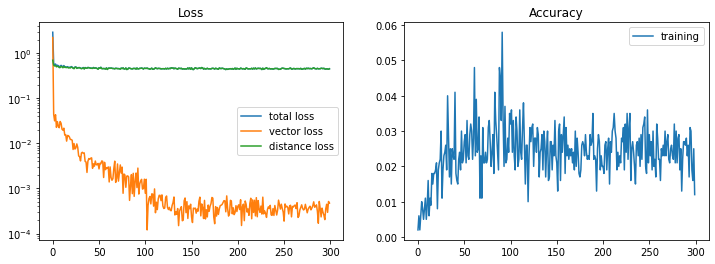

In [4]:
# Plot the training loss and accuracy.
tloss = np.loadtxt("train.txt")

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

ax1 = fig.add_subplot(121);
plt.plot(tloss[:,0],tloss[:,1],label='total loss')
plt.plot(tloss[:,0],tloss[:,2],label='vector loss')
plt.plot(tloss[:,0],tloss[:,3],label='distance loss')
plt.legend()
plt.title("Loss")
plt.yscale('log')

ax2 = fig.add_subplot(122);
plt.plot(tloss[:,0],tloss[:,4],label='training')
plt.legend()
plt.title("Accuracy")

Light side is 0
True point ( 7.5 , 6.5 )
Line drawn: m = -2, b = 15
True distance to the line: -2.9068883707497264
Pred point ( 7.725141763687134 , 6.3725796937942505 )
Pred vector ( -0.77485824 , -0.1274203 )
Predicted distance to the line: -3.0512771927431976
TEST LOSS
-- Test vector loss: tensor(0., device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
-- Test distance loss: tensor(0.2175, device='cuda:0', grad_fn=<MeanBackward0>)
COMPARE LOSS
-- Compare vector loss: 0.6166412208154526
-- Compare distance loss: 0.04729847652658687


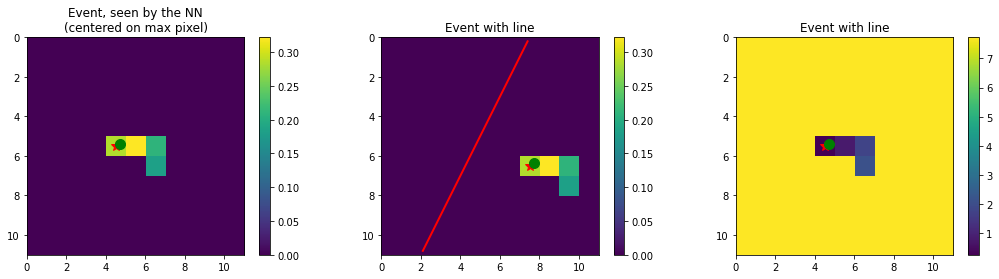

In [41]:
# Look at individual events
evt_plt = 14273
evt_item = dataset_val[evt_plt]
evt_frame_cmax = np.array(evt_item[0])
evt_frame      = np.array(evt_item[1])
evt_argmax     = np.array(evt_item[2])
evt_err        = np.array(evt_item[3])/emnet.PIXEL_SIZE
evt_lside      = np.array(evt_item[4])
print("Light side is",evt_lside)

# Compute the true row and col.
row_true = evt_err[1] + evt_argmax[0] + 0.5
col_true = evt_err[0] + evt_argmax[1] + 0.5
print("True point (",col_true,",",row_true,")")

# Information for drawing the line.
nrows = evt_frame.shape[0]
ncols = evt_frame.shape[1]
indices = np.indices((nrows,ncols))
irows = indices[0]
icols = indices[1]
print("Line drawn: m = {}, b = {}".format(line_m,line_b))

# Compute the distance from the true point to the line.
dist_true = (line_m*col_true - row_true + line_b) / (line_m**2 + 1)**0.5
print("True distance to the line:",dist_true)

# Run the model and compute the reconstructed point.
data = torch.tensor(evt_frame_cmax).float().unsqueeze(0).unsqueeze(1).cuda()
output_score = model(data)
pred_err = np.array(output_score.cpu().detach().numpy()).squeeze()
row_pred = pred_err[1] + evt_argmax[0] + 0.5
col_pred = pred_err[0] + evt_argmax[1] + 0.5
print("Pred point (",col_pred,",",row_pred,")")
print("Pred vector (",pred_err[0],",",pred_err[1],")")

# Compute the distance from the reconstructed point to the line.
dist_pred = (line_m*col_pred - row_pred + line_b) / (line_m**2 + 1)**0.5
print("Predicted distance to the line:",dist_pred)

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(18.0)

ax1 = fig.add_subplot(131)
plt.imshow(evt_frame_cmax,extent=[0,11,11,0])
ax1.plot([evt_err[0]+5.5],[evt_err[1]+5.5],color='red',marker='*',markersize=10)
ax1.plot([pred_err[0]+5.5],[pred_err[1]+5.5],color='green',marker='o',markersize=10)
plt.colorbar()
plt.title("Event, seen by the NN\n(centered on max pixel)")

ax2 = fig.add_subplot(132)
plt.imshow(evt_frame,extent=[0,11,11,0])
ax2.plot([col_true],[row_true],color='red',marker='*',markersize=10)
ax2.plot([col_pred],[row_pred],color='green',marker='o',markersize=10)
plt.colorbar()
plt.title("Event with line")
xfit = np.arange(0,ncols-1,0.1)
yfit = line_m*xfit + line_b
plt.plot(xfit[(yfit > 0) & (yfit < nrows)],yfit[(yfit > 0) & (yfit < nrows)],linewidth=2,color='red')

# Compute a test loss
batch_size = 1
indices = np.indices((emnet.EVT_SIZE,emnet.EVT_SIZE))
row_coords = torch.tensor(indices[0] + 0.5 - ((emnet.EVT_SIZE-1)/2 + 0.5)).repeat([batch_size,1,1]).cuda()
col_coords = torch.tensor(indices[1] + 0.5 - ((emnet.EVT_SIZE-1)/2 + 0.5)).repeat([batch_size,1,1]).cuda()
print("TEST LOSS")
#loss_vec, loss_dist = tr.loss_reg_edge(torch.tensor([[evt_err[0],evt_err[1]]]), np.array([evt_argmax]), line_m, line_b, evt_lside)
loss_vec, loss_dist, dist_reco_masked = tr.loss_reg_edge(data.squeeze(1), torch.tensor(evt_item[3]).unsqueeze(0).cuda(), output_score, row_coords, col_coords, torch.tensor([evt_argmax]).cuda(), line_m, line_b, evt_lside)
print("-- Test vector loss:",loss_vec)
print("-- Test distance loss:",loss_dist)

ax3 = fig.add_subplot(133)
plt.imshow(dist_reco_masked.cpu().detach().squeeze(0).numpy(),extent=[0,11,11,0])
ax3.plot([evt_err[0]+5.5],[evt_err[1]+5.5],color='red',marker='*',markersize=10)
ax3.plot([pred_err[0]+5.5],[pred_err[1]+5.5],color='green',marker='o',markersize=10)
plt.colorbar()
plt.title("Event with line")
xfit = np.arange(0,ncols-1,0.1)
yfit = line_m*xfit + line_b

print("COMPARE LOSS")
if(evt_lside == 0):
    dist_true *= -1
    dist_pred *= -1
sigma_dist = 1
loss_vec = (pred_err[0]**2 + pred_err[1]**2)
loss_dist = np.exp(-dist_pred/sigma_dist)
print("-- Compare vector loss:",loss_vec)
print("-- Compare distance loss:",loss_dist)
#print("True vector is ({},{})".format(evt_vec[0],evt_vec[1]))
#print("Predicted vector is ({},{})".format(pred_vec[0],pred_vec[1]))

In [22]:
# Evaluate several events
err_list = []
dist_list = []
maxval_list = []
err_x = []
err_y = []

for evt in range(0,20000):

    evt_item = dataset_val[evt]
    evt_frame_cmax = np.array(evt_item[0])
    evt_err        = np.array(evt_item[3])/emnet.PIXEL_SIZE

    # Record the maximum event value.
    maxval_list.append(np.max(evt_frame_cmax))
    
    # Send through the model.
    data = torch.tensor(evt_frame_cmax).float().unsqueeze(0).unsqueeze(1).cuda()
    output_score = model(data)
    pred_err = np.array(output_score.cpu().detach().numpy()).squeeze()
    
    # Compute the error.
    err = ((evt_err[0] - pred_err[0])**2 + (evt_err[1] - pred_err[1])**2)**0.5*emnet.PIXEL_SIZE
    dist = (evt_err[0]**2 + evt_err[1]**2)**0.5*emnet.PIXEL_SIZE
    ex = (evt_err[1] - pred_err[1])*emnet.PIXEL_SIZE
    ey = (evt_err[0] - pred_err[0])*emnet.PIXEL_SIZE
    
    err_list.append(err)
    err_x.append(ex)
    err_y.append(ey)
    dist_list.append(dist)
    
    if(evt % 100 == 0):
        print("Event",evt)
        
err_list = np.array(err_list)
err_x = np.array(err_x)
err_y = np.array(err_y)
dist_list = np.array(dist_list)

Event 0
Event 100
Event 200
Event 300
Event 400
Event 500
Event 600
Event 700
Event 800
Event 900
Event 1000
Event 1100
Event 1200
Event 1300
Event 1400
Event 1500
Event 1600
Event 1700
Event 1800
Event 1900
Event 2000
Event 2100
Event 2200
Event 2300
Event 2400
Event 2500
Event 2600
Event 2700
Event 2800
Event 2900
Event 3000
Event 3100
Event 3200
Event 3300
Event 3400
Event 3500
Event 3600
Event 3700
Event 3800
Event 3900
Event 4000
Event 4100
Event 4200
Event 4300
Event 4400
Event 4500
Event 4600
Event 4700
Event 4800
Event 4900
Event 5000
Event 5100
Event 5200
Event 5300
Event 5400
Event 5500
Event 5600
Event 5700
Event 5800
Event 5900
Event 6000
Event 6100
Event 6200
Event 6300
Event 6400
Event 6500
Event 6600
Event 6700
Event 6800
Event 6900
Event 7000
Event 7100
Event 7200
Event 7300
Event 7400
Event 7500
Event 7600
Event 7700
Event 7800
Event 7900
Event 8000
Event 8100
Event 8200
Event 8300
Event 8400
Event 8500
Event 8600
Event 8700
Event 8800
Event 8900
Event 9000
Event 9100


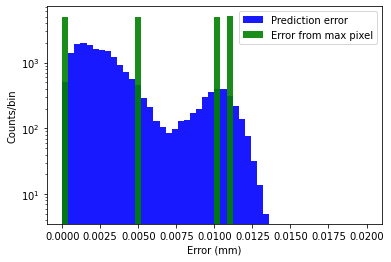

In [24]:
fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(6.0)

rng_max = 0.02
plt.hist(err_list,bins=50,color='blue',alpha=0.9,label="Prediction error",range=[0,rng_max])
plt.hist(dist_list,bins=50,color='green',alpha=0.9,label="Error from max pixel",range=[0,rng_max])
plt.legend()
plt.xlabel("Error (mm)")
plt.ylabel("Counts/bin")
plt.yscale("log")

In [ ]:
fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(6.0)

rng = 0.02
plt.hist(err_x,bins=100,color='blue',alpha=0.9,label="Prediction error",range=[-rng,rng])
plt.legend()
plt.xlabel("Error (mm)")
plt.ylabel("Counts/bin")

# Train the network (regression)

In [ ]:
modeldir = '/home/jrenner/local/jerenner/emsim/models'
lrate       = 1e-5   # Learning rate to use in the training.
load_model  = False   # Load an existing model
tr.augment  = False  # Enable/disable data augmentation
epoch_start = 0      # Number of initial epoch
epoch_end   = 200    # Number of final epoch
model_load_checkpoint = "{}/regression/model_basicCNN_regression_vector_11x11.pt".format(modeldir)

# "Real-data-like" dataset: occupancy 11, noise_mean=683, noise_sigma=11.2
dset_train = tr.EMDataset("../dataframes/EM_5um_front_3M_100keV.pkl",noise_mean=0,noise_sigma=20,add_noise=False,add_shift=-1,nstart=20000)
dset_val = tr.EMDataset("../dataframes/EM_5um_front_3M_100keV.pkl",noise_mean=0,noise_sigma=20,add_noise=False,add_shift=-1,nstart=0,nend=20000)
#dataset_train   = tr.EMFrameDataset(dset,frame_size=50,nelec_mean=11,nelec_sigma=0.5,noise_mean=683,noise_sigma=11.2)
dataset_train = tr.EMFrameDataset(dset_train,frame_size=11,nelec_mean=2,nelec_sigma=0.1,noise_mean=683,noise_sigma=11.2,m_line=-2.0,b_line=30.0,res_factor=1)
dataset_val = tr.EMFrameDataset(dset_val,frame_size=11,nelec_mean=2,nelec_sigma=0.1,noise_mean=683,noise_sigma=11.2,m_line=-2.0,b_line=30.0,res_factor=1)

# Create the loaders.
train_loader = DataLoader(dataset_train, batch_size=50, shuffle=False, collate_fn=tr.my_collate_unet, num_workers=1)

# Define the model.
model = emnet.basicCNN_reg()
#model = emnet.FCNet()
model.cuda()

optimizer = optim.RMSprop(model.parameters(), lr=lrate, weight_decay=1e-8, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

# Load the model from file.
if(load_model):
    model.load_state_dict(torch.load(model_load_checkpoint))
    #model.load_state_dict(torch.load(model_load_checkpoint,map_location=torch.device('cpu')))
    model.eval()

In [ ]:
# Run the training.
for epoch in range(epoch_start,epoch_end):
    print("Epoch: ",epoch)
    model.train()
    train_loss = tr.train_regression(model, epoch, train_loader, optimizer)
    scheduler.step(train_loss)
    #if(epoch % 50 == 0):
    torch.save(model.state_dict(), "{}/model_init_{}.pt".format(modeldir,epoch))

In [ ]:
# Plot the training loss and accuracy.
tloss = np.loadtxt("train.txt")

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

ax1 = fig.add_subplot(121);
plt.plot(tloss[:,0],tloss[:,1],label='training')
plt.legend()
plt.title("Loss")
plt.yscale('log')

ax2 = fig.add_subplot(122);
plt.plot(tloss[:,0],tloss[:,2],label='training')
plt.legend()
plt.title("Accuracy")

## Plot a test event

In [ ]:
sigmoid = nn.Sigmoid()
model.eval()

In [ ]:
evt_plt = 14273
evt_item = dataset_val[evt_plt]
evt_arr = np.array(evt_item[0])
evt_vec = np.array(evt_item[1])

# Send through the model.
data = torch.tensor(evt_arr).float().unsqueeze(0).unsqueeze(1).cuda()
#target = torch.tensor(evt_lbl).float().cuda()
output_score = model(data)

# Compute the predicted pixel and (x,y) values.
pred_vec = np.array(output_score.cpu().detach().numpy()).squeeze()

# Scale the errors.
# err_max = int(evt_arr.shape[0]-1)/2*emnet.PIXEL_SIZE
# err_rng = 2*err_max
# print("Max err is",err_max)
# evt_vec = (evt_vec*err_rng - err_max)/emnet.PIXEL_SIZE
# pred_vec = (pred_vec*err_rng - err_max)/emnet.PIXEL_SIZE

# Information for drawing the line.
nrows = evt_arr.shape[0]
ncols = evt_arr.shape[1]
indices = np.indices((nrows,ncols))
irows = indices[0]
icols = indices[1]
m = -2*nrows/ncols
b = 80
print("Line drawn: m = {}, b = {}".format(m,b))

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(18.0)

ax1 = fig.add_subplot(131)
plt.imshow(evt_arr)
#ax1.plot([evt_vec[0]],[evt_vec[1]],color='red',marker='o',markersize=10)
plt.colorbar()
plt.plot([5+evt_vec[1]],[5+evt_vec[0]],color='red',marker='o',markersize=10)
plt.plot([5+pred_vec[1]],[5+pred_vec[0]],color='green',marker='o',markersize=10)
plt.title("Event")
print("True vector is ({},{})".format(evt_vec[0],evt_vec[1]))
print("Predicted vector is ({},{})".format(pred_vec[0],pred_vec[1]))

# xfit = np.arange(0,ncols,0.1)
# yfit = m*xfit + b
# plt.plot(xfit[(yfit > 0) & (yfit < nrows)],yfit[(yfit > 0) & (yfit < nrows)])

### Evaluate several events

In [ ]:
err_list = []
dist_list = []
maxval_list = []
err_x = []
err_y = []

for evt in range(0,20000):

    evt_item = dataset_val[evt]
    evt_arr = np.array(evt_item[0])
    evt_vec = np.array(evt_item[1])

    # Record the maximum event value.
    maxval_list.append(np.max(evt_arr))
    
    # Send through the model.
    data = torch.tensor(evt_arr).float().unsqueeze(0).unsqueeze(1).cuda()
    output_score = model(data)

    # Compute the predicted pixel and (x,y) values.
    pred_vec = np.array(output_score.cpu().detach().numpy()).squeeze()
    
    # Scale the errors.
#     err_max = int(evt_arr.shape[0]-1)/2*emnet.PIXEL_SIZE
#     err_rng = 2*err_max
#     #print("Max err is",err_max)
#     evt_vec = (evt_vec*err_rng - err_max)/emnet.PIXEL_SIZE
#     pred_vec = (pred_vec*err_rng - err_max)/emnet.PIXEL_SIZE
    
    # Compute the error.
    err = ((evt_vec[0] - pred_vec[0])**2 + (evt_vec[1] - pred_vec[1])**2)**0.5
    dist = (evt_vec[0]**2 + evt_vec[1]**2)**0.5
    ex = evt_vec[1] - pred_vec[1]
    ey = evt_vec[0] - pred_vec[0]
    
    err_list.append(err)
    err_x.append(ex)
    err_y.append(ey)
    dist_list.append(dist)
    
    if(evt % 100 == 0):
        print("Event",evt)
        
err_list = np.array(err_list)
err_x = np.array(err_x)
err_y = np.array(err_y)
dist_list = np.array(dist_list)

In [ ]:
print(max(maxval_list))

In [ ]:
fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(6.0)

plt.hist(err_list*0.005,bins=50,color='blue',alpha=0.9,label="Prediction error",range=[0,0.005])
plt.hist(dist_list*0.005,bins=50,color='green',alpha=0.9,label="Error from max pixel",range=[0,0.005])
plt.legend()
plt.xlabel("Error (mm)")
plt.ylabel("Counts/bin")
#plt.yscale("log")

In [ ]:
fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(6.0)

rng = 0.05
plt.hist(err_x*0.005,bins=100,color='blue',alpha=0.9,label="Prediction error",range=[-rng,rng])
plt.legend()
plt.xlabel("Error (mm)")
plt.ylabel("Counts/bin")

In [ ]:
np.where(dist_list > 10)

# Generate random multi-electron events

In [ ]:
dset = tr.EMDataset("dataframes/EM_5um_front_3M_100keV.pkl",noise_mean=0,noise_sigma=20,add_noise=False,add_shift=0)

In [ ]:
frameset  = tr.EMFrameDataset(dset,frame_size=20,nelec_mean=2,nelec_sigma=0.1,noise_mean=683,noise_sigma=11.2,m_line=-2.0,b_line=30.0, lside = 0, res_factor=3)
#frameset = tr.EMFrameDataset(dset,frame_size=4855,nelec_mean=103713,nelec_sigma=0.5,noise_mean=683,noise_sigma=11.2)
#frameset = tr.EMFrameDataset(dset,frame_size=100,nelec_mean=88,nelec_sigma=2,noise_mean=0,noise_sigma=20)
#frameset = tr.EMFrameDataset(dset,frame_size=100,nelec_mean=10,nelec_sigma=1,noise_mean=0,noise_sigma=20)

##### Generate many frames and fit

In [ ]:
def fit_line(fit_img, th = 0.5, pct_rng = 0.2, nbins_hdist = 80):
    
    A = fit_img/np.mean(fit_img)
    nrows = A.shape[0]
    ncols = A.shape[1]
    ncts = np.sum(A[A >= th])
    nzeros = np.sum(1-A[A < th])
    wcts = 1 #nzeros/ncts
    indices = np.indices((nrows,ncols))
    irows = indices[0]
    icols = indices[1]
    print("nzeros = {}, ncts = {}, wcts = {}".format(nzeros,ncts,wcts))

    def count_loss(x):
        m,b = x

        # The loss L is:
        #
        # (number of 0s in the dark region) - wcts*(number of 1s in the dark region)
        # + wcts*(number of 1s in the light region) - (number of 0s in the dark region)
        # 
        # where wcts is the count weight, determined such that the number of counts multiplied by wcts is equal to
        # the number of zeros.
        L = 0
        L1 = np.sum(1-A[(irows < m*icols + b) & (A < th)])
        L2 = np.sum(A[(irows < m*icols + b) & (A >= th)])
        L3 = np.sum(A[(irows >= m*icols + b) & (A >= th)])
        L4 = np.sum(1-A[(irows >= m*icols + b) & (A < th)])

        L = L1 - wcts*L2 + wcts*L3 - L4
        #print("Loss is:",-L,"with L1 =",L1,"L2 =",L2,"L3 =",L3,"L4 =",L4)
        return -L
    
    initial_guess = [-1.5*nrows/ncols,2.0*nrows]
    result = optimize.minimize(count_loss,initial_guess,method='Nelder-Mead',tol=1e-5)
    m,b = result.x
    Lmin = result.fun
    print("m = ",m,"b = ",b,"Lmin=",Lmin)
    
    # Force m and b.
    m = -2.0
    b = 90.0
    print("NOTE: hard-coding m and b")
    
    # Get the loss over a range of the parameters.
    mrng = np.arange(m-pct_rng*m, m+pct_rng*m, 2*pct_rng*m/1000)
    Lrng_m = np.array([count_loss([mval,b])/Lmin for mval in mrng])
    brng = np.arange(b-pct_rng*b, b+pct_rng*b, 2*pct_rng*b/1000)
    Lrng_b = np.array([count_loss([m,bval])/Lmin for bval in brng])
    
    # Get the histogram of mean value vs. distance.
    dist = (5./3.)*(m*icols - irows + b) / (m**2 + 1)                          # compute distance to line for each point
    hw, bb = np.histogram(dist.flatten(),weights=A.flatten(),bins=nbins_hdist)  # weighted histogram
    hh, bb = np.histogram(dist.flatten(),bins=nbins_hdist)                      # unweighted (for normalization)
    hh[hh == 0] = 0.1
    hfinal = hw / hh                                                   # normalize the histogram
    bcenters = (bb[1:] + bb[:-1]) / 2                                  # determine the bin centers
    
    return m,b,Lmin,mrng,Lrng_m,brng,Lrng_b,hfinal,bcenters

In [ ]:
# Create some number of events and count them.
th_unet = 0.2
th_classical = 825/4.
evts = np.arange(0,100000)
l_frames, l_labels, l_ct_unet, l_ct_classical = [], [], [], []
for evt in evts:
    frame,label = frameset[evt]
    gnd_truth = label[0]
    
    # Send through the model.
    data = torch.tensor(frame).float().unsqueeze(0).unsqueeze(1).cuda()
    output_score = model(data)
    
    # Compute the predicted pixel values.
    prob = np.array(sigmoid(output_score).cpu().detach().numpy()).squeeze()
    ct_unet = (prob > th_unet)
    
    # Count with a single threshold.
    #ct_classical = (frame > th_classical)
    
    # Max argument classical truth.
    #ct_classical = np.zeros(frame.shape)
    #ct_classical[np.unravel_index(np.argmax(frame),frame.shape)] = 1
    
    # Threshold truth.
    ct_classical = label[1]
    
    l_frames.append(frame)
    l_labels.append(gnd_truth)
    l_ct_unet.append(ct_unet)
    l_ct_classical.append(ct_classical)
    
    if((evt-evts[0]) % (len(evts)/100) == 0):
            print("{}% done".format(int((evt-evts[0]) / (len(evts)/100))))
            
l_frames = np.array(l_frames)
l_labels = np.array(l_labels)
l_ct_unet = np.array(l_ct_unet)
l_ct_classical = np.array(l_ct_classical)

# Create a summed frame, label, and count arrays.
frame = np.sum(l_frames,axis=0)
label = np.sum(l_labels,axis=0)
ct_unet = np.sum(l_ct_unet,axis=0)
ct_classical = np.sum(l_ct_classical,axis=0)

In [ ]:
raw_th = 0.99
ct_th = 0.1
m_frame,b_frame,Lmin_frame,mrng_frame,Lrng_m_frame,brng_frame,Lrng_b_frame,hdist_frame,bcenters_frame = fit_line(frame,th=raw_th)
m_label,b_label,Lmin_label,mrng_label,Lrng_m_label,brng_label,Lrng_b_label,hdist_label,bcenters_label = fit_line(label,th=ct_th)
m_unet,b_unet,Lmin_unet,mrng_unet,Lrng_m_unet,brng_unet,Lrng_b_unet,hdist_unet,bcenters_unet = fit_line(ct_unet,th=ct_th)
m_classical,b_classical,Lmin_classical,mrng_classical,Lrng_m_classical,brng_classical,Lrng_b_classical,hdist_classical,bcenters_classical = fit_line(ct_classical,th=ct_th)

In [ ]:
#frame,label = frameset[0]
logscale = False
nrows = frame.shape[0]
ncols = frame.shape[1]

fig = plt.figure()
fig.set_figheight(12.0)
fig.set_figwidth(12.0)

ax1 = fig.add_subplot(221)
if(logscale):
    plt.imshow(np.log(frame))
    cbar = plt.colorbar()
    cbar.set_label("log(counts)")
    #plt.title("Raw frame (log counts, threshold = {})\nm = {:.2f}, b = {:.2f}".format(raw_th,m_frame,b_frame))
    plt.title("Raw frame (log counts)\nm = {:.2f}, b = {:.2f}".format(m_frame,b_frame))
else:
    plt.imshow(frame/np.max(frame))
    cbar = plt.colorbar()
    #plt.title("Raw frame (threshold = {})\nm = {:.2f}, b = {:.2f}".format(raw_th,m_frame,b_frame))
    plt.title("Raw frame\nm = {:.2f}, b = {:.2f}".format(m_frame,b_frame))
xfit = np.arange(0,ncols-1,0.1)
yfit = m_frame*xfit + b_frame
plt.plot(xfit[(yfit > 0) & (yfit < nrows-1)],yfit[(yfit > 0) & (yfit < nrows-1)],color='red',linewidth=2)

ax2 = fig.add_subplot(222)
plt.imshow(label/np.max(label))
#plt.title("Truth (threshold = {})\nm = {:.2f}, b = {:.2f}".format(ct_th,m_label,b_label))
plt.title("Truth\nm = {:.2f}, b = {:.2f}".format(m_label,b_label))
plt.colorbar()
xfit = np.arange(0,ncols-1,0.1)
yfit = m_label*xfit + b_label
plt.plot(xfit[(yfit > 0) & (yfit < nrows-1)],yfit[(yfit > 0) & (yfit < nrows-1)],color='red',linewidth=2)

ax3 = fig.add_subplot(223)
plt.imshow(ct_unet/np.max(ct_unet))
#plt.title("UNet counts (threshold = {})\nm = {:.2f}, b = {:.2f}".format(ct_th,m_unet,b_unet))
plt.title("UNet counts\nm = {:.2f}, b = {:.2f}".format(m_unet,b_unet))
plt.colorbar()
xfit = np.arange(0,ncols-1,0.1)
yfit = m_unet*xfit + b_unet
plt.plot(xfit[(yfit > 0) & (yfit < nrows-1)],yfit[(yfit > 0) & (yfit < nrows-1)],color='red',linewidth=2)

ax4 = fig.add_subplot(224)
plt.imshow(ct_classical/np.max(ct_classical))
#plt.title("Classical counts + line info (threshold = {})\nm = {:.2f}, b = {:.2f}".format(ct_th,m_classical,b_classical))
plt.title("Classical counts + line info\nm = {:.2f}, b = {:.2f}".format(m_classical,b_classical))
plt.colorbar()
xfit = np.arange(0,ncols-1,0.1)
yfit = m_classical*xfit + b_classical
plt.plot(xfit[(yfit > 0) & (yfit < nrows-1)],yfit[(yfit > 0) & (yfit < nrows-1)],color='red',linewidth=2)

print("Total counts, truth:",np.sum(label))
print("Total counts, classical:",np.sum(ct_classical))
print("Total counts, unet:",np.sum(ct_unet))

In [ ]:
fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

frame_mult = 1./(1.-min(hdist_frame))

ax1 = fig.add_subplot(121)
plt.plot(bcenters_frame,frame_mult*(hdist_frame-min(hdist_frame)),'.-',color='black',label='frame')
plt.plot(bcenters_label,hdist_label,'.-',color='green',label='true')
plt.plot(bcenters_unet,hdist_unet,'.-',color='blue',label='UNet')
plt.plot(bcenters_classical,hdist_classical,'.-',color='red',label='classical+line')
plt.xlim([-10,10])
plt.ylim([0.0,3.2])
plt.xlabel("Distance from line (micrometers)")
plt.ylabel("Mean number of normalized counts")
plt.legend()

In [ ]:
# Save s-curve information.
np.savez("scurve_edge_th08_epoch10.npz", bcenters_frame=bcenters_frame, hdist_frame=hdist_frame, bcenters_label=bcenters_label, hdist_label=hdist_label, 
         bcenters_unet=bcenters_unet, hdist_unet=hdist_unet, bcenters_classical=bcenters_classical, 
         hdist_classical=hdist_classical)

In [ ]:
fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

ax1 = fig.add_subplot(121)
plt.plot(mrng_frame/m_frame,Lrng_m_frame,color='black',label='frame')
plt.plot(mrng_label/m_label,Lrng_m_label,color='green',label='true')
plt.plot(mrng_unet/m_unet,Lrng_m_unet,color='blue',label='UNet')
plt.plot(mrng_classical/m_classical,Lrng_m_classical,color='red',label='classical')
plt.xlabel("Parameter m/m$_0$")
plt.ylabel("Relative loss L/L(m$_0$)")
plt.legend()

ax2 = fig.add_subplot(122)
plt.plot(brng_frame/b_frame,Lrng_b_frame,color='black',label='frame')
plt.plot(brng_label/b_label,Lrng_b_label,color='green',label='true')
plt.plot(brng_unet/b_unet,Lrng_b_unet,color='blue',label='UNet')
plt.plot(brng_classical/b_classical,Lrng_b_classical,color='red',label='classical')
plt.xlabel("Parameter b/b$_0$")
plt.ylabel("Relative loss L/L(b$_0$)")
plt.legend()

In [ ]:
np.savez("evt_arrays.npz",evt_arrays=l_evt_arr)

#### Plot s-curve data

In [ ]:
scurve_noedge = np.load("scurve_noedge_th088.npz")
bc_label_noedge = scurve_noedge['bcenters_label']
h_label_noedge = scurve_noedge['hdist_label']
bc_unet_noedge = scurve_noedge['bcenters_unet']
h_unet_noedge = scurve_noedge['hdist_unet']
bc_classical_noedge = scurve_noedge['bcenters_classical']
h_classical_noedge = scurve_noedge['hdist_classical']

scurve_edge = np.load("scurve_edge_th08.npz")
bc_frame_edge = scurve_edge['bcenters_frame']
h_frame_edge = scurve_edge['hdist_frame']
bc_label_edge = scurve_edge['bcenters_label']
h_label_edge = scurve_edge['hdist_label']
bc_unet_edge = scurve_edge['bcenters_unet']
h_unet_edge = scurve_edge['hdist_unet']
bc_classical_edge = scurve_edge['bcenters_classical']
h_classical_edge = scurve_edge['hdist_classical']

scurve_edge10 = np.load("scurve_edge_th08_epoch10.npz")
bc_label_edge10 = scurve_edge10['bcenters_label']
h_label_edge10 = scurve_edge10['hdist_label']
bc_unet_edge10 = scurve_edge10['bcenters_unet']
h_unet_edge10 = scurve_edge10['hdist_unet']
bc_classical_edge10 = scurve_edge10['bcenters_classical']
h_classical_edge10 = scurve_edge10['hdist_classical']

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

frame_mult = 1./(1.-min(h_frame_edge))

ax1 = fig.add_subplot(111)
plt.plot(bc_frame_edge,frame_mult*(h_frame_edge-min(h_frame_edge)),'.-',color='black',label='raw frame, scaled')
plt.plot(bc_classical_edge,h_classical_edge,'.-',color='red',label='classical')
plt.plot(bc_unet_noedge,h_unet_noedge,'.-',color='orange',label='UNet, no edge, epoch 500')
plt.plot(bc_unet_edge10,h_unet_edge10,'.-',color='cyan',label='UNet + edge, epoch 11')
plt.plot(bc_unet_edge,h_unet_edge,'.-',color='blue',label='UNet + edge, epoch 500')
plt.plot(bc_label_edge,h_label_edge,'.-',color='green',label='true')
plt.xlim([-5,5])
plt.ylim([0.0,1.0])
plt.xlabel("Distance from line (pixels)")
plt.ylabel("Mean number of normalized counts")
plt.legend()

##### Examine a large generated frame

In [ ]:
plt.imshow(label[0,0:50,0:50])
plt.colorbar()

In [ ]:
img_sim = frame.flatten()

In [ ]:
#plt.hist(img_sim[(img_sim < 400)],bins=50)
plt.hist(img_sim,bins=50)
plt.xlabel("Pixel values")
plt.ylabel("Counts/bin")
plt.yscale("log")
print("Total pixels:",len(img_sim))
#plt.xlim([0,500])

In [ ]:
np.savez("frame_4855x4855_11occ.npz",frame=frame)

## Train a network (multi-electron)

In [ ]:
modeldir = '/home/jrenner/local/jerenner/emsim/models'
lrate       = 1e-3   # Learning rate to use in the training.
load_model  = True   # Load an existing model
tr.augment  = False  # Enable/disable data augmentation
epoch_start = 0      # Number of initial epoch
epoch_end   = 200    # Number of final epoch
model_load_checkpoint = "{}/model_init_199.pt".format(modeldir)

# Create the dataset.
# 576x576: 2927 +/- 71
# 100x100: 88 +/- 2
# 50x50: 22 +/- 0.5
#dset = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=False,add_shift=0)

# "Real-data-like" dataset: occupancy 11, noise_mean=683, noise_sigma=11.2
dset = tr.EMDataset("dataframes/EM_5um_front_3M_100keV.pkl",noise_mean=0,noise_sigma=20,add_noise=False,add_shift=0)
#dataset_train   = tr.EMFrameDataset(dset,frame_size=50,nelec_mean=11,nelec_sigma=0.5,noise_mean=683,noise_sigma=11.2)
dataset_train = tr.EMFrameDataset(dset,frame_size=20,nelec_mean=2,nelec_sigma=0.1,noise_mean=683,noise_sigma=11.2,m_line=-2.0,b_line=30.0,res_factor=3)

# Create the loaders.
train_loader = DataLoader(dataset_train, batch_size=50, shuffle=False, collate_fn=tr.my_collate_unet, num_workers=1)

# Define the model.
model = UNet(n_channels=1, n_classes=1)
model.cuda()

optimizer = optim.RMSprop(model.parameters(), lr=lrate, weight_decay=1e-8, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

# Load the model from file.
if(load_model):
    model.load_state_dict(torch.load(model_load_checkpoint))
    #model.load_state_dict(torch.load(model_load_checkpoint,map_location=torch.device('cpu')))
    model.eval()

In [ ]:
# Run the training.
for epoch in range(epoch_start,epoch_end):
    print("Epoch: ",epoch)
    model.train()
    train_loss = tr.train_unet(model, epoch, train_loader, optimizer)
    scheduler.step(train_loss)
    #if(epoch % 50 == 0):
    torch.save(model.state_dict(), "{}/model_init_{}.pt".format(modeldir,epoch))

In [ ]:
torch.save(model.state_dict(), "{}/model_frames_20x20_noise683_2e_bcsloss_noedge_unweighted_front_1em4_100kev_{}.pt".format(modeldir,epoch))

In [ ]:
# Plot the training loss and accuracy.
tloss = np.loadtxt("train.txt")

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

ax1 = fig.add_subplot(121);
plt.plot(tloss[:,0],tloss[:,1],label='training')
plt.legend()
plt.title("Loss")
plt.yscale('log')

ax2 = fig.add_subplot(122);
plt.plot(tloss[:,0],tloss[:,2],label='training')
plt.legend()
plt.title("Accuracy")

#### Test the net

In [ ]:
sigmoid = nn.Sigmoid()
#dset = tr.EMDataset("dataframes/EM_5um_front_3M_100keV.pkl",noise_mean=0,noise_sigma=20,add_noise=False,add_shift=0)
#dataset_train   = tr.EMFrameDataset(dset,frame_size=50,nelec_mean=11,nelec_sigma=0.5,noise_mean=683,noise_sigma=11.2)
model.eval()

In [ ]:
# Loop over many events and evaluate the true positives and false positives.
# Store in arrays as:
#
#  [tp0 tp1 tp2 tp3 ... tpN], each number corresponding to a different NN threshold or classical threshold
#
tp_unet = []; fp_unet = []
tp_classical = []; fp_classical = []
#nn_thresholds = np.arange(0.05,1.0,0.1)
nn_thresholds = np.concatenate((np.logspace(-4,-0.1,500), np.logspace(-0.1,0,500)))
#nn_thresholds = np.logspace(-3,0,1000)
classical_thresholds = np.arange(600/4,7000/4,10)
evts = np.arange(100000,101000)
for evt in evts:
    
    # Get the event and truth.
    evt_item = dataset_train[evt]
    evt_arr = evt_item[0]
    evt_lbl = evt_item[1][0]
    
    # Send through the model.
    data = torch.tensor(evt_arr).float().unsqueeze(0).unsqueeze(1).cuda()
    output_score = model(data)
    
    # Compute the predicted pixel values.
    prob = np.array(sigmoid(output_score).cpu().detach().numpy()).squeeze()
    
    # Compute the TP and FP values for unet.
    temp_tp = []; temp_fp = []
    for th in nn_thresholds:
        pred = (prob > th)
        tp = np.sum((evt_lbl == 1) & (pred == True))
        fn = np.sum((evt_lbl == 1) & (pred == False))
        if( (tp + fn) > 0): tp = tp / (tp + fn)
        else: tp = 1
        fp = np.sum((evt_lbl == 0) & (pred == True))
        tn = np.sum((evt_lbl == 0) & (pred == False))
        if( (fp + tn) > 0): fp = fp / (fp + tn)
        else: fp = 0
        temp_tp.append(tp)
        temp_fp.append(fp)
    tp_unet.append(temp_tp)
    fp_unet.append(temp_fp)
    
    # Compute the TP and FP values for the classical threshold.
    temp_tp = []; temp_fp = []
    for th in classical_thresholds:
        #pred = (evt_arr > th)
        pred = np.zeros(evt_arr.shape)
        pred[np.unravel_index(np.argmax(evt_arr),evt_arr.shape)] = 1
        tp = np.sum((evt_lbl == 1) & (pred == True))
        fn = np.sum((evt_lbl == 1) & (pred == False))
        if( (tp + fn) > 0): tp = tp / (tp + fn)
        else: tp = 1
        fp = np.sum((evt_lbl == 0) & (pred == True))
        tn = np.sum((evt_lbl == 0) & (pred == False))
        if( (tp + tn) > 0): fp = fp / (fp + tn)
        else: tp = 0
        temp_tp.append(tp)
        temp_fp.append(fp)
    tp_classical.append(temp_tp)
    fp_classical.append(temp_fp)
    
    if((evt-evts[0]) % (len(evts)/100) == 0):
            print("{}% done".format(int((evt-evts[0]) / (len(evts)/100))))
    
tp_unet = np.array(tp_unet)
fp_unet = np.array(fp_unet)
tp_classical = np.array(tp_classical)
fp_classical = np.array(fp_classical)

In [ ]:
tp_rate_unet = np.mean(tp_unet,axis=0)
tp_err_unet = np.std(tp_unet,axis=0)/np.sqrt(tp_unet.shape[0])
fp_rate_unet = np.mean(fp_unet,axis=0)
fp_err_unet = np.std(fp_unet,axis=0)/np.sqrt(fp_unet.shape[0])
tp_rate_classical = np.mean(tp_classical,axis=0)
tp_err_classical = np.std(tp_classical,axis=0)/np.sqrt(tp_classical.shape[0])
fp_rate_classical = np.mean(fp_classical,axis=0)
fp_err_classical = np.std(fp_classical,axis=0)/np.sqrt(fp_classical.shape[0])

plt.errorbar(fp_rate_unet,tp_rate_unet,xerr=fp_err_unet,yerr=tp_err_unet,label='Unet')
plt.errorbar(fp_rate_classical,tp_rate_classical,xerr=fp_err_classical,yerr=tp_err_classical,label='Basic threshold')
plt.xlim([0,0.02])
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")

In [ ]:
print("NN ------------------")
for tpr,fpr,th in zip(tp_rate_unet,fp_rate_unet,nn_thresholds):
    print("[Threshold {}] TP = {}, FP = {}".format(th,tpr,fpr))
print("Classical threshold ------------------")
for tpr,fpr,th in zip(tp_rate_classical,fp_rate_classical,classical_thresholds):
    print("[Threshold {}] TP = {}, FP = {}".format(th,tpr,fpr))

In [ ]:
evt_plt = 10008
evt_item = dataset_train[evt_plt]
evt_arr = evt_item[0]
evt_lbl = evt_item[1][1]

# Send through the model.
data = torch.tensor(evt_arr).float().unsqueeze(0).unsqueeze(1).cuda()
#target = torch.tensor(evt_lbl).float().cuda()
output_score = model(data)

# Compute the predicted pixel and (x,y) values.
prob = np.array(sigmoid(output_score).cpu().detach().numpy()).squeeze()

# Threshold
# prob = np.zeros(evt_arr.shape)
# prob[evt_arr > 80] = 1

# Determine number of correct pixels
th = 0.2
pred = (prob > th)
nelec = int(np.sum(evt_lbl == 1))
nelec_pred = int(np.sum(pred))
nspace = int(np.sum(evt_lbl == 0))
nelec_coinc = np.sum((evt_lbl == 1) & (pred == True))
nspace_coinc = np.sum((evt_lbl == 0) & (pred == False))
print("{}/{} electrons predicted".format(nelec_pred,nelec))
print("{}/{} electrons coincided exactly".format(nelec_coinc,nelec))
print("{}/{} empty spaces coincided exactly".format(nspace_coinc,nspace))

# Information for drawing the line.
nrows = evt_arr.shape[0]
ncols = evt_arr.shape[1]
indices = np.indices((nrows,ncols))
irows = indices[0]
icols = indices[1]
m = -2*nrows/ncols
b = 80
print("Line drawn: m = {}, b = {}".format(m,b))

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(18.0)

ax1 = fig.add_subplot(131)
plt.imshow(evt_arr)
plt.colorbar()
plt.title("Event")

# xfit = np.arange(0,ncols,0.1)
# yfit = m*xfit + b
# plt.plot(xfit[(yfit > 0) & (yfit < nrows)],yfit[(yfit > 0) & (yfit < nrows)])

ax2 = fig.add_subplot(132)
plt.imshow(evt_lbl)
plt.colorbar()
plt.title("Target")

ax3 = fig.add_subplot(133)
#plt.imshow(np.log10(prob))
plt.imshow(prob)
plt.colorbar()
plt.title("{}/{} electrons predicted\n{}/{} electrons coincided exactly\n{}/{} empty spaces coincided exactly".format(nelec_pred,nelec,nelec_coinc,nelec,nspace_coinc,nspace))

#### Test loss function

In [ ]:
# Construct output and label arrays for 5 events.
frames,outputs,labels = [], [], []
for iframe in range(50):
    frame,label = frameset[iframe]
    frames.append(frame)
    outputs.append(label[1])
    labels.append(label)
frames = np.array(frames)
outputs = np.array(outputs)
labels = np.array(labels)
print("Frames shape is:",frames.shape)
print("Outputs shape is:",outputs.shape)
print("Labels shape is:",labels.shape)

# Convert to tensors.
outputs[outputs == 0] = 1e-10
outputs[outputs == 1] = 0.99999999
frames = torch.tensor(frames)
output = torch.tensor(np.log(outputs/(1-outputs)))
target = torch.tensor(labels)

# Compute the loss.
sigma_dist = 1
real_truth = target[:,0,:,:]
th_truth = target[:,1,:,:]
edge_truth = target[:,2,:,:]
dist = target[:,3,:,:]

final_truth = th_truth * edge_truth

wts     = torch.sum(torch.exp(-(dist)**2/(2*sigma_dist**2))*th_truth,axis=(1,2))
wt_norm = torch.sum(th_truth,axis=(1,2))
wt_norm[wt_norm == 0] = 1
wts /= wt_norm
print("Weights are: ",wts)

w_edge = 100
bce_loss = torch.nn.BCEWithLogitsLoss(reduce=False)
sigmoid = torch.nn.Sigmoid()
loss0 = bce_loss(output,final_truth)
loss1 = w_edge*sigmoid(output)*(1-edge_truth)
loss0W = torch.exp(-(dist)**2/(2*sigma_dist**2))*(loss0)
loss1W = torch.exp(-(dist)**2/(2*sigma_dist**2))*(loss1)
loss = torch.mean(torch.exp(-(dist)**2/(2*sigma_dist**2))*(loss0 + loss1))
print("Mean loss is ",loss)
print("Mean loss0 is ",torch.mean(loss0))
print("Mean loss0W is ",torch.mean(loss0W))
print("Mean loss1 is ",torch.mean(loss1))
print("Mean loss1W is ",torch.mean(loss1W))

In [ ]:
dist_mod = torch.sum(torch.abs(dist*(edge_truth-1)),axis=(1,2))
dist_mod.shape

In [ ]:
iframe = 2
show_sum = False

fig = plt.figure()
fig.set_figheight(6.0)
fig.set_figwidth(16.0)

ax1 = fig.add_subplot(241)
if(show_sum): plt.imshow(np.sum(np.array(sigmoid(output)),axis=0),interpolation=None)
else: plt.imshow(np.array(sigmoid(output[iframe])),interpolation=None)
plt.colorbar()
plt.title("sigmoid(Output)")

ax2 = fig.add_subplot(242)
if(show_sum): plt.imshow(np.sum(np.array(th_truth),axis=0),interpolation=None)
else: plt.imshow(np.array(real_truth[iframe]),interpolation=None)
plt.colorbar()
plt.title("Real truth")

ax3 = fig.add_subplot(243)
if(show_sum): plt.imshow(np.sum(np.array(edge_truth), axis=0))
else: plt.imshow(np.array(edge_truth[iframe]))
plt.colorbar()
plt.title("Edge truth")

ax4 = fig.add_subplot(244)
if(show_sum): plt.imshow(np.sum(np.array(torch.exp(-(dist)**2/(2*sigma_dist**2))),axis=0))
else: plt.imshow(np.array(torch.exp(-(dist)**2/(2*sigma_dist**2))[iframe]))
plt.colorbar()
plt.title("Distance")

ax5 = fig.add_subplot(245)
if(show_sum): plt.imshow(np.sum(np.array(loss0), axis=0))
else: plt.imshow(np.array(loss0[iframe]))
plt.colorbar()
plt.title("Loss0")

ax6 = fig.add_subplot(246)
if(show_sum): plt.imshow(np.sum(np.array(loss1),axis=0))
else: plt.imshow(np.array(loss1[iframe]))
plt.colorbar()
plt.title("Loss1")

ax7 = fig.add_subplot(247)
if(show_sum): plt.imshow(np.sum(np.array(loss0W + loss1W),axis=0))
else: plt.imshow(np.array(loss0W[iframe] + loss1W[iframe]))
# if(show_sum): plt.imshow(np.sum(np.array(dist_mod),axis=0))
# else: plt.imshow(np.array(dist_mod[iframe]))
plt.colorbar()
plt.title("LossW")

In [ ]:
iframe = 2
show_sum = False

fig = plt.figure()
fig.set_figheight(3.0)
fig.set_figwidth(20.0)

ax1 = fig.add_subplot(151)
if(show_sum): plt.imshow(np.sum(frames,axis=0)/np.max(np.sum(frames,axis=0)),interpolation=None)
else: plt.imshow(np.array(frames[iframe]),interpolation=None)
plt.colorbar()
plt.title("Event")

ax2 = fig.add_subplot(152)
if(show_sum): plt.imshow(np.sum(np.array(real_truth),axis=0),interpolation=None)
else: plt.imshow(np.array(real_truth[iframe]),interpolation=None)
plt.colorbar()
plt.title("Real truth")

ax3 = fig.add_subplot(153)
if(show_sum): plt.imshow(np.sum(np.array(th_truth),axis=0),interpolation=None)
else: plt.imshow(np.array(th_truth[iframe]),interpolation=None)
plt.colorbar()
plt.title("Classical threshold")

ax4 = fig.add_subplot(154)
if(show_sum): plt.imshow(np.sum(np.array(edge_truth), axis=0))
else: plt.imshow(np.array(edge_truth[iframe]))
plt.colorbar()
plt.title("Edge truth")

ax5 = fig.add_subplot(155)
if(show_sum): plt.imshow(np.sum(np.array(final_truth), axis=0))
else: plt.imshow(np.array(final_truth[iframe]))
plt.colorbar()
plt.title("Combined truth")

##### Test on real data

In [ ]:
# Evaluate real data
img_data_cut = img_data[-1023:,-1440:]/12
img_data_torch = torch.tensor(img_data_cut).float().unsqueeze(0).unsqueeze(1).cuda()
output_score = model(img_data_torch)
prob = np.array(sigmoid(output_score).cpu().detach().numpy()).squeeze()

In [ ]:
# Plot the results of the real data evaluation
logscale = False
view_row_low = -350
view_row_high = -300
view_col_low = -350
view_col_high = -300

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

ax1 = fig.add_subplot(121);
if(logscale):
    plt.imshow(np.log(img_data_cut[view_row_low:view_row_high,view_col_low:view_col_high]),interpolation='none')
    cbar = plt.colorbar()
    cbar.set_label("log(counts)")
    plt.title("Scaled data (log counts)")
else:
    plt.imshow(img_data_cut[view_row_low:view_row_high,view_col_low:view_col_high],interpolation='none') #np.log(frame))
    cbar = plt.colorbar()
    plt.title("Scaled data")

ax2 = fig.add_subplot(122);
plt.imshow(prob[view_row_low:view_row_high,view_col_low:view_col_high],interpolation='none')
plt.title("U-net output")
plt.colorbar()

In [ ]:
prob.shape

## Real data

In [ ]:
import struct
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as optimize

In [ ]:
# From https://stackoverflow.com/questions/1035340/reading-binary-file-and-looping-over-each-byte
def bytes_from_file(filename, chunksize=4):
    with open(filename, "rb") as f:
        while True:
            chunk = f.read(chunksize)
            if chunk:
                yield struct.unpack('@I', chunk)[0]
            else:
                break

In [ ]:
datfile = "/home/jrenner/local/data/electronsim/stack_1.dat"
freader = iter(bytes_from_file(datfile))

In [ ]:
img = []
for i in range(5760*4092):
    img.append(next(freader))
img = np.array(img)

In [ ]:
# Prepare for input to a NN
img_data = img.reshape([4092,5760])

In [ ]:
#plt.imshow(np.log(img.reshape([5760,4092])),vmin=9.5,vmax=10.5)
#plt.imshow(img.reshape([5760,4092])[-100:,0:100],vmin=750,vmax=10000)
plt.imshow(img_data,interpolation='none',vmin=750,vmax=15000)
plt.colorbar()

## Attempt to fit the edge

In [ ]:
noise_th = 750*12
max_th = 751*12
fit_img = np.copy(img_data)
fit_img[fit_img < noise_th] = 0
fit_img[fit_img >= noise_th] = max_th
fit_img = fit_img/np.max(fit_img)
fit_img = np.array(fit_img,dtype=np.uint8)
print("Min value:",np.min(fit_img),"; max value:",np.max(fit_img))

In [ ]:
plt.imshow(fit_img,interpolation='none')
plt.colorbar()

In [ ]:
A = fit_img
th = 0.5
nrows = A.shape[0]
ncols = A.shape[1]
ncts = np.sum(A >= th)
nzeros = np.sum(A < th)
wcts = nzeros/ncts
indices = np.indices((nrows,ncols))
irows = indices[0]
icols = indices[1]

def count_loss(x):
    m,b = x
    
    # The loss L is:
    #
    # (number of 0s in the dark region) - wcts*(number of 1s in the dark region)
    # + wcts*(number of 1s in the light region) - (number of 0s in the dark region)
    # 
    # where wcts is the count weight, determined such that the number of counts multiplied by wcts is equal to
    # the number of zeros.
    L = 0
    L1 = np.sum((irows < m*icols + b) & (A < th))
    L2 = np.sum((irows < m*icols + b) & (A >= th))
    L3 = np.sum((irows >= m*icols + b) & (A >= th))
    L4 = np.sum((irows >= m*icols + b) & (A < th))
    
    L = L1 - wcts*L2 + wcts*L3 - L4
    print("Loss is:",-L,"with L1 =",L1,"L2 =",L2,"L3 =",L3,"L4 =",L4)
    return -L

In [ ]:
initial_guess = [-nrows/ncols,nrows]
result = optimize.minimize(count_loss,initial_guess,method='Nelder-Mead',tol=1e-6)
m,b = result.x
Lmin = result.fun
print("m = ",m,"b = ",b,"Lmin=",Lmin)

In [ ]:
plt.imshow(fit_img,interpolation='none')
xfit = np.arange(ncols)
yfit = m*xfit + b
plt.plot(xfit[(yfit > 0) & (yfit < nrows)],yfit[(yfit > 0) & (yfit < nrows)])

In [ ]:
# Plot the loss in a range near the parameters.
mrng = np.arange(m-0.1*m, m+0.1*m, 0.2*m/100)
Lrng = np.array([count_loss([mval,b])/Lmin for mval in mrng])
print(mrng)
plt.plot(mrng,Lrng)
plt.xlabel("Parameter m")
plt.ylabel("Relative loss L/L(m$_0$)")

In [ ]:
def auto_canny(image, sigma=0.1):
    v = 255/2. #np.median(image)
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    print("Lower =",lower,", upper=",upper)
    return cv2.Canny(image, lower, upper)

edges = auto_canny(image=fit_img) 

# Show images for testing
#cv2.imshow('edges', edges)
plt.imshow(edges)
plt.colorbar()

## Fit the noise peak

In [ ]:
fscale = 12.

def gauss(x, amp, mu, sigma):
    if sigma <= 0.:
        return np.inf
    return amp/(2*np.pi)**(0.5)/sigma * np.exp(-0.5*(x-mu)**2./sigma**2)

def gaussexpo(x, amp, mu, sigma, const, mean, x0):
    if sigma <= 0.:
        return np.inf
    return amp/(2*np.pi)**(0.5)/sigma * np.exp(-0.5*(x-mu)**2./sigma**2) + const * np.exp(-(x-x0)/mean)


yh, xh, _ = plt.hist(img[(img/fscale > 7000/fscale) & (img/fscale < 9300/fscale)]/fscale,bins=50)
xh = (xh[1:] + xh[0:-1])/2

#popt, pcov = curve_fit(gaussexpo, xh, yh, [3.0e6, 8200, 300, 1000, 10, -1])
popt, pcov = curve_fit(gauss, xh, yh, [3.0e6, 8200/fscale, 135/fscale])
xfit = np.linspace(xh[0],xh[-1],100)
plt.plot(xfit,gauss(xfit,*popt))
plt.xlabel("Pixel values")
plt.ylabel("Counts/bin")
print("Fit mean:",popt[1])
print("Fit sigma:",popt[2])

In [ ]:
fn = np.load("frame_4855x4855_11occ.npz")
img_sim = fn['frame'].flatten()

In [ ]:
#plt.hist(img[(img > 0) & (img < 10000)],bins=50)
plt.hist(img_sim,bins=50,range=[0,10000],label='MC')
plt.hist(img/12,bins=50,range=[0,10000],label='data')

plt.xlabel("Pixel values")
plt.ylabel("Counts/bin")
plt.yscale("log")
plt.legend()
print("Total pixels:",len(img))
print("Counts near peak",np.sum(img[(img > 29) & (img < 33)]))

In [ ]:
177383690/935130034.

In [ ]:
plt.hist(np.abs(np.random.normal(loc=0,scale=50,size=1000)))

## Train a network (single-electrons)

In [ ]:
#modeldir = '/home/jrenner/local/jerenner/emsim/models'\
modeldir = '/home/jrenner/temp/nersc'
lrate       = 1e-3   # Learning rate to use in the training.
load_model  = True   # Load an existing model
tr.augment  = False  # Enable/disable data augmentation
epoch_start = 0      # Number of initial epoch
epoch_end   = 2000    # Number of final epoch
model_load_checkpoint = "{}/run_11x11_chi32_60/model_init_599.pt".format(modeldir)

# Create the datasets.
dataset_all   = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=True,add_shift=0)
dataset_train = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=True,nstart=0,nend=-20000,add_shift=0)
dataset_val   = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=True,nstart=-20000,add_shift=0)

# Create the loaders.
train_loader = DataLoader(dataset_train, batch_size=1000, shuffle=True, collate_fn=tr.my_collate, num_workers=8)
val_loader = DataLoader(dataset_val, batch_size=1000, shuffle=True, collate_fn=tr.my_collate, num_workers=8)
#val_loader = DataLoader(dataset_val, batch_size=15, shuffle=True, collate_fn=tr.my_collate, num_workers=4)
#test_loader = DataLoader(dataset_test, batch_size=15, shuffle=True, collate_fn=tr.my_collate, num_workers=4)

# Define the model.
#model = emnet.FCNet()
model = emnet.basicCNN()
model.cuda()

optimizer = optim.Adam(model.parameters(), lr=lrate, betas=(0.9, 0.999), eps=1e-6, weight_decay=0.01, amsgrad=True)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

# Load the model from file.
if(load_model):
    model.load_state_dict(torch.load(model_load_checkpoint))
    #model.load_state_dict(torch.load(model_load_checkpoint,map_location=torch.device('cpu')))
    model.eval()

In [ ]:
# Run the training.
#print("Training with weights",sort_clsweights)
for epoch in range(epoch_start,epoch_end):
    print("Epoch: ",epoch)
    model.train()
    tr.train(model, epoch, train_loader, optimizer)
    with torch.no_grad():
        model.eval()
        val_loss = tr.val(model, epoch, val_loader)
        scheduler.step(val_loss)
#     if(epoch % 50 == 0):
#         torch.save(model.state_dict(), "{}/model_init_{}.pt".format(modeldir,epoch))

In [ ]:
torch.save(model.state_dict(), "{}/model_short_training_{}.pt".format(modeldir,epoch))

### Plot the training and validation loss

In [ ]:
# Plot the training and validation losses.
tloss = np.loadtxt("/home/jrenner/temp/nersc/run_11x11_chi32_60_val2_trainsched/train.txt")
vloss = np.loadtxt("/home/jrenner/temp/nersc/run_11x11_chi32_60_val2_trainsched/val.txt")
#vloss = np.loadtxt("/home/jrenner/local/jerenner/emsim/val.txt")

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

ax1 = fig.add_subplot(121);
plt.plot(tloss[:,0],tloss[:,1],label='training')
plt.plot(vloss[:,0],vloss[:,1],label='validation')
plt.legend()
plt.title("Loss")
plt.yscale('log')

ax2 = fig.add_subplot(122);
plt.plot(tloss[:,0],tloss[:,2],label='training')
plt.plot(vloss[:,0],vloss[:,2],label='validation')
plt.legend()
plt.title("Accuracy")

### Evaluate all events from a dataset

In [ ]:
dset = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=True,add_shift=0)
model.eval()

In [ ]:
evts = np.arange(100000,110000)
df, evts = emsim_utils.construct_evt_dataframe(dset,evts,model)

In [ ]:
xvals = df['xc_3x3'].values
yvals = df['yc_3x3'].values
rngval = 0.002
plt.hist2d(xvals,yvals,bins=10,range=[[-rngval,rngval],[-rngval,rngval]])
plt.colorbar()

In [ ]:
axes = pd.plotting.scatter_matrix(df[["error_r_NN","error_r_maxpt","error_r_3x3","error_r_3x3_th","error_r_5x5","error_r_5x5_th"]], 
                                  figsize=[15,15], alpha=0.2, hist_kwds={'bins':100})
for i, axs in enumerate(axes):
    for j, ax in enumerate(axs):
        #if i == j:  # only the histograms
        #ax.set_yscale('log')
        ax.set_xlim(0,0.01)
        ax.set_ylim(0,0.01)
            
plt.savefig("errors_scatter_matrix.pdf")

In [ ]:
err_cut = 0.1
rng_cut = 0.005
sigma_cut = 1e9
nbins = 50

df_plt_NN  = df[(df.error_r_3x3 < err_cut)] # & (df.sigma_r_NN < sigma_cut)]
df_plt_3x3 = df[(df.error_r_3x3 < err_cut)] # & (df.sigma_r_NN < sigma_cut)]

plt.hist(df_plt_NN.error_r_NN,range=(0,rng_cut),alpha=0.8,bins=nbins,color='blue',label='NN error')
plt.hist(df_plt_3x3.error_r_3x3,range=(0,rng_cut),alpha=0.8,bins=nbins,color='green',label='3x3 centroid')
plt.xlabel("error $\sqrt{\Delta x^2 + \Delta y^2}$ (mm)")
plt.ylabel("counts/bin")
#plt.yscale('log')
plt.legend()

print("NN events:",len(df_plt_NN[df_plt_NN.error_r_NN < rng_cut]))
print("3x3 events:",len(df_plt_3x3[df_plt_3x3.error_r_3x3 < rng_cut]))
print("Mean NN error:",np.mean(df_plt_NN[df_plt_NN.error_r_NN < rng_cut].error_r_NN))
print("Mean 3x3 error:",np.mean(df_plt_3x3[df_plt_3x3.error_r_3x3 < rng_cut].error_r_3x3))

In [ ]:
print("Mean 3x3 error:",df[(df.error_r_3x3 < err_cut) & (df.sigma_r_NN < sigma_cut)].error_r_3x3.mean())
print("Mean NN error: ",df[(df.error_r_NN < err_cut) & (df.sigma_r_NN < sigma_cut)].error_r_NN.mean())

In [ ]:
df["error_r_diff"] = df.error_r_NN - df.error_r_3x3

In [ ]:
err_diff_cut = 0.005
plt.hist(df[(df.error_r_diff < err_diff_cut) & (df.error_r_diff > -err_diff_cut) & (df.sigma_r_NN < 0.011)].error_r_diff,alpha=0.8,bins=50,color='blue',label='NN error')
plt.yscale("log")
plt.xlabel("error difference (NN - 3x3-method)")

In [ ]:
df[df.x_true > 0.02][['event','x_true']]

In [ ]:
# Save dataframe and event arrays.
df.to_pickle("evts_80000_to_90000.pkl")
np.savez("evt_arrays.npz",evt_arrays=l_evt_arr)

In [ ]:
df = pd.read_pickle("evts_80000_to_90000.pkl")

In [ ]:
cut_sigma = 0.011

fig = plt.figure()
fig.set_figheight(6.0)
fig.set_figwidth(15.0)

ax1 = fig.add_subplot(121)
plt.hist(df[df.sigma_r_NN < cut_sigma].error_r_NN,bins=50)
plt.yscale("log")
plt.xlabel("error $\sqrt{\Delta x^2 + \Delta y^2}$ (mm)")
plt.ylabel("Counts/bin")

ax2 = fig.add_subplot(122)
plt.hist(df[df.sigma_r_NN < cut_sigma].sigma_r_NN,bins=50)
plt.xlabel("$\sqrt{\sigma_x^2 + \sigma_y^2}$ of probability distribution (mm)")
plt.ylabel("Counts/bin")

In [ ]:
eff, mean_err = [], []
cut_sigmas = np.arange(0.003,0.4,0.0005)
for cut_sigma in cut_sigmas:
    df_cut = df[df.sigma_r_NN < cut_sigma]
    
    eff.append(len(df_cut)/len(df))
    mean_err.append(df_cut.error_r_NN.mean())
    
    print("[SIGMA = {}]: EFF = {}, ERR = {}".format(cut_sigma,len(df_cut)/len(df),df_cut.error_r_NN.mean()))

eff = np.array(eff)
mean_err = np.array(mean_err)
plt.plot(mean_err,eff,'.-')
plt.xlabel("Mean error (mm)")
plt.ylabel("Efficiency")


### Test the net for individual events

In [ ]:
dset = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=True,add_shift=0)
softmax = nn.Softmax(dim=1)
model.eval()

In [ ]:
evt_plt = 80388
evt_item = dset[evt_plt]
evt_arr = evt_item[0]
evt_lbl = evt_item[1]
evt_err_ind = evt_item[2]

SHIFTED_ERR_RANGE_MIN = emnet.PIXEL_ERR_RANGE_MIN # - dset.add_shift*emnet.PIXEL_SIZE
SHIFTED_ERR_RANGE_MAX = emnet.PIXEL_ERR_RANGE_MAX # + dset.add_shift*emnet.PIXEL_SIZE
#ERR_PIXEL_SIZE = emnet.PIXEL_SIZE*(2*dset.add_shift+1)/emnet.ERR_SIZE
ERR_PIXEL_SIZE = (emnet.PIXEL_ERR_RANGE_MAX - emnet.PIXEL_ERR_RANGE_MIN)/emnet.ERR_SIZE
print("Error grid pixel size is {}".format(ERR_PIXEL_SIZE))

x_errgrid = np.arange(0,emnet.ERR_SIZE)*ERR_PIXEL_SIZE + SHIFTED_ERR_RANGE_MIN + ERR_PIXEL_SIZE/2
y_errgrid = np.arange(0,emnet.ERR_SIZE)*ERR_PIXEL_SIZE + SHIFTED_ERR_RANGE_MIN + ERR_PIXEL_SIZE/2
print(x_errgrid)

xbin = int(emnet.ERR_SIZE*(evt_lbl[0] - SHIFTED_ERR_RANGE_MIN)/(SHIFTED_ERR_RANGE_MAX - SHIFTED_ERR_RANGE_MIN))
xbin = max(xbin,0)
xbin = min(xbin,emnet.ERR_SIZE-1)

ybin = int(emnet.ERR_SIZE*(evt_lbl[1] - SHIFTED_ERR_RANGE_MIN)/(SHIFTED_ERR_RANGE_MAX - SHIFTED_ERR_RANGE_MIN))
ybin = max(ybin,0)
ybin = min(ybin,emnet.ERR_SIZE-1)

print("Computed index:",(ybin*emnet.ERR_SIZE) + xbin,"for max added shift:",dset.add_shift)

# Send through the model.
data = torch.tensor(evt_arr).float().unsqueeze(0).unsqueeze(1).cuda()
target = torch.tensor(np.array(evt_err_ind)).long().cuda()
output_score = model(data)

# Compute the predicted pixel and (x,y) values.
prob = np.array(softmax(output_score).cpu().detach().numpy()).reshape([emnet.ERR_SIZE,emnet.ERR_SIZE])
ipred = np.argmax(prob)
xpred = int(ipred % emnet.ERR_SIZE)*ERR_PIXEL_SIZE + SHIFTED_ERR_RANGE_MIN + ERR_PIXEL_SIZE/2
ypred = int(ipred / emnet.ERR_SIZE)*ERR_PIXEL_SIZE + SHIFTED_ERR_RANGE_MIN + ERR_PIXEL_SIZE/2
#print("[Evt",evt,"]: Index is",evt_err_ind,"with predicted",ipred,"; x = {} (predicted {}), y = {} (predicted {})".format(evt_lbl[0],xpred,evt_lbl[1],ypred))

# Compute the sigmas of the distribution.
sigma_x0, sigma_y0 = emsim_utils.compute_sigmas(prob,ERR_PIXEL_SIZE,SHIFTED_ERR_RANGE_MIN)
popt, pcov = emsim_utils.fit_sigmas(prob,x_errgrid,y_errgrid,xpred,ypred,sigma_x0,sigma_y0,ERR_PIXEL_SIZE)
fit_data = emsim_utils.mult_gaussFun_Fit((x_errgrid,y_errgrid),*popt).reshape([emnet.ERR_SIZE,emnet.ERR_SIZE])
print("Gaussian fit parameters A*exp(-0.5*((x-x0)**2/varX + (y-y0)**2/varY)) + C:")
print("A = {}".format(popt[0]))
print("(x0, y0) = ({},{})".format(popt[1],popt[2]))
print("(sigma_x, sigma_y) = ({},{})".format(popt[3]**0.5,popt[4]**0.5))
print("C = {}".format(popt[5]))

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(18.0)

ax1 = fig.add_subplot(131)
plt.imshow(evt_arr)
plt.colorbar()
plt.title("Event {}; shift ({:.3e},{:.3e}); index {}".format(evt_plt,evt_lbl[0],evt_lbl[1],evt_err_ind))

ax2 = fig.add_subplot(132)
ax2.plot([xbin],[ybin],color='red',marker='o',markersize=10)
plt.imshow(prob)
plt.colorbar()
plt.title("Incidence point within prediction grid")

ax3 = fig.add_subplot(133)
plt.imshow(fit_data)
plt.colorbar()
plt.title("2D Gaussian fit")

# Misc. code

In [ ]:
# Look at many events:
xpred_err, ypred_err = [], []
for evt_plt in np.arange(8000,9999):
    
    evt_item = dset[evt_plt]
    evt_arr = evt_item[0]
    evt_lbl = evt_item[1]
    evt_err_ind = evt_item[2]

    # Send through the model.
    data = torch.tensor(evt_arr).float().unsqueeze(0).unsqueeze(1).cuda()
    target = torch.tensor(np.array(evt_err_ind)).long().cuda()

    output_score = model(data)
    prob = np.argmax(np.array(softmax(output_score).cpu().detach().numpy()).reshape([10,10]))
    xpred = (prob % tr.ERR_SIZE)*0.005/tr.ERR_SIZE + tr.ERR_RANGE_MIN + 0.005/tr.ERR_SIZE/2
    ypred = (prob / tr.ERR_SIZE)*0.005/tr.ERR_SIZE + tr.ERR_RANGE_MIN + 0.005/tr.ERR_SIZE/2
    print("[Evt",evt_plt,"]: Index is",evt_err_ind,"with predicted",prob,"; x = {} (predicted {}), y = {} (predicted {})".format(evt_lbl[0],xpred,evt_lbl[1],ypred))
    
    xpred_err.append(xpred-evt_lbl[0])
    ypred_err.append(ypred-evt_lbl[1])
xpred_err = np.array(xpred_err)
ypred_err = np.array(ypred_err)

In [ ]:
fig = plt.figure()
fig.set_figheight(6.0)
fig.set_figwidth(15.0)

ax1 = fig.add_subplot(121);
plt.hist(xpred_err)
plt.xlabel("error in x-prediction (mm)")
print(np.where(abs(xpred_err) > 0.001))

ax2 = fig.add_subplot(122)
plt.hist(ypred_err)
plt.xlabel("error in y-prediction (mm)")


#### For debugging the 3x3 sum operations

In [ ]:
aa = np.ones([6,6])
aa[0,2] = 4
aa[1,2] = 2
aa[3,2] = 8
aa[4,2] = -2
aa[3,1] = 5
aa[5,0] = 10
aa

In [ ]:
max_init   = np.unravel_index(aa.argmax(),aa.shape)
nbsum_init = tr.sum_neighbors(aa,max_init,remove=True)
print("Max at",max_init,"and neighbor sum",nbsum_init)
aa

### Evaluate a dataset for noise

In [ ]:
Nevts = 1000
noise_arr = np.arange(0.,100.,50.)
r_mean, r_sigma = [], []
for noise in noise_arr:
    print("Running for noise",noise)
    dset = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",0,noise)
    
    shifts_x, shifts_y, shifts_r = [], [], []
    for evt in range(Nevts):
        evt_arr,evt_lbl = dset[evt]
        xs,ys = evt_lbl[0],evt_lbl[1]
        shifts_x.append(xs)
        shifts_y.append(ys)
        shifts_r.append((xs**2 + ys**2)**0.5)
    
    shifts_r = np.array(shifts_r)
    r_mean.append(np.mean(shifts_r))
    r_sigma.append(np.std(shifts_r))

In [ ]:
plt.errorbar(noise_arr,r_mean,yerr=np.array(r_sigma)/Nevts**0.5)
plt.xlabel("$\sigma$ noise (electrons)")
plt.ylabel("r-error (mm)")

### Read a dataset and examine individual events

In [ ]:
dset = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_shift=10,add_noise=True)

In [ ]:
evt_plt = 8
evt_item = dset[evt_plt]
evt_arr = evt_item[0]
evt_lbl = evt_item[1]
evt_err_ind = evt_item[2]
plt.imshow(evt_arr)
plt.colorbar()
plt.title("Event {}; shift {}; index {}".format(evt_plt,evt_lbl,evt_err_ind))

In [ ]:
shifts_x, shifts_y, shifts_r = [], [], []
for evt in range(1000):
    evt_arr,evt_lbl,evt_err_ind = dset[evt]
    xs,ys = evt_lbl[0],evt_lbl[1]
    shifts_x.append(xs)
    shifts_y.append(ys)
    shifts_r.append((xs**2 + ys**2)**0.5)

In [ ]:
plt.hist(shifts_r,bins=100)
plt.yscale('log')

### Plot events directly from dataframe

In [ ]:
df = pd.read_pickle("dataframes/EM_4um_back_10M_300keV.pkl")

In [ ]:
evt_plt = 97
evt_arr = np.zeros([101,101])
df_evt = df[df.event == evt_plt]
for row,col,counts in zip(df_evt['row'].values,df_evt['col'].values,df_evt['counts'].values):
    evt_arr[row,col] += counts
plt.imshow(np.log(0.1 + evt_arr))
plt.colorbar()
plt.title("Event {}; max at {}".format(evt_plt,np.unravel_index(evt_arr.argmax(),evt_arr.shape)))